In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import lsqlin
from scipy import stats
import copy 
from sklearn import svm
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [2]:
vix_df = pd.read_excel( 'VIXfutures_2008_20210326.xlsx' )

vix_df = vix_df.sort_values( by = ['Date'], ascending = True )

x_df = vix_df[ [ 'Date', 'VIX', 'w', \
                       'CMF30', 'CMF60', 'CMF90', 'CMF120', 'CMF150', \
                       'roll30', 'roll60', 'roll90', 'roll120', 'roll150', \
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9' ] ]

# for eache row, if it contains a non-number element in a column, then drop the entire row
x_df = x_df.dropna()

# for eache row, if it contains a 0 element in a column, then drop the entire row
#x_df = x_df.loc[ ( x_df != 0 ).all( axis = 1 ) ]

# reset the index
x_df= x_df.reset_index( drop = True )

dates = x_df[ 'Date' ]

In [3]:
vix = x_df.VIX 
T = len(vix)

v_1 = x_df.CMF30 
v_2 = x_df.CMF60 
v_3 = x_df.CMF90 
v_4 = x_df.CMF120 
v_5 = x_df.CMF150 

d_theta_log_v_1 = x_df.roll30 
d_theta_log_v_2 = x_df.roll60 
d_theta_log_v_3 = x_df.roll90 
d_theta_log_v_4 = x_df.roll120 
d_theta_log_v_5 = x_df.roll150 

In [4]:
vix_etn_number = 10
x_row = vix_etn_number + 1  #  plus 1 here is for the VIX
x_column = len( v_1 );
X = np.ones( ( x_row, x_column ) )

X[ 0, : ] =  np.log( vix )

X[ 1, : ] =  np.log( v_1 )
X[ 2, : ] =  np.log( v_2 )
X[ 3, : ] =  np.log( v_3 )
X[ 4, : ] =  np.log( v_4 )
X[ 5, : ] =  np.log( v_5 )

X[ 6, : ] = d_theta_log_v_1
X[ 7, : ] = d_theta_log_v_2
X[ 8, : ] = d_theta_log_v_3
X[ 9, : ] = d_theta_log_v_4
X[ 10, : ] = d_theta_log_v_5

In [5]:
#######################################################
####
#### 1-month and 5-month rolling futures portfolios
####
#######################################################

dt = 1/252;
r = .03
vxx = np.zeros(T)
vxz = np.zeros(T)
vxx[0]=100
vxz[0]=100
for t in range(T-1):
    vxx[t+1] = vxx[t]*(1+r*dt + X[ 6, t+1 ]*dt  + (X[ 1, t+1 ]-X[ 1, t ])/X[ 1, t ]  )
    vxz[t+1] = vxz[t]*(1+r*dt + X[ 10, t+1 ]*dt  + (X[ 5, t+1 ]-X[ 5, t ])/X[ 5, t ]  )
    
r_trade = -np.diff(vxx)/vxx[:-1] + 2*np.diff(vxz)/vxz[:-1] 


sign_trade = (np.sign(r_trade)+1)/2  ### sign of returns, to be predicted by classifier


In [6]:
#######################################################
####
#### divide data into training and testing
####
#######################################################

T_train = int(np.round(T/2))

ind_train = np.arange(0,T_train )
X_train = X[:,ind_train]
y_train = sign_trade[ind_train]

ind_test = np.arange(T_train ,T-1)
X_test = X[:,ind_test]
y_test = sign_trade[ind_test]

In [7]:
#######################################################
####
#### build and train deep neural network
####
#######################################################



relu_parameter = 0.1
neuron_num = 1000
activation_function = lambda x: tf.keras.activations.sigmoid( x )  # Sigmoid
#activation_function = lambda x: tf.keras.activations.relu( x, relu_parameter ) # Parameteric rectified linear unit
#activation_function = lambda x: tf.keras.activations.softplus( x )  # SoftPlus

model = tf.keras.Sequential( )
model.add( tf.keras.layers.Flatten( input_shape = ( 11, ) ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( 1, activation = 'sigmoid'  ) )

model.compile( loss = 'binary_crossentropy', optimizer = 'adam',\
              metrics = [ 'accuracy', 'mean_absolute_error' ] )



model_history = model.fit( X_train.T, y_train, \
                  epochs = 20000, batch_size = 512, shuffle = True, validation_split = .2 )


Epoch 1/20000
3/3 [==============================] - 3s 583ms/step - loss: 1.2780 - accuracy: 0.6061 - mean_absolute_error: 0.4532 - val_loss: 0.8091 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5060
Epoch 2/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.9720 - accuracy: 0.3827 - mean_absolute_error: 0.5571 - val_loss: 0.6990 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4980
Epoch 3/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.7007 - accuracy: 0.6108 - mean_absolute_error: 0.4681 - val_loss: 0.9399 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4910
Epoch 4/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.7830 - accuracy: 0.6032 - mean_absolute_error: 0.4385 - val_loss: 0.7362 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4956
Epoch 5/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6694 - accuracy: 0.6139 - mean_absolute_error: 0.4713 - val_loss: 0.6938 - val_accuracy: 0.4860 - v

Epoch 41/20000
3/3 [==============================] - 0s 28ms/step - loss: 0.6706 - accuracy: 0.6059 - mean_absolute_error: 0.4772 - val_loss: 0.7118 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4969
Epoch 42/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6670 - accuracy: 0.6142 - mean_absolute_error: 0.4743 - val_loss: 0.7145 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4967
Epoch 43/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6703 - accuracy: 0.6068 - mean_absolute_error: 0.4755 - val_loss: 0.7105 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4970
Epoch 44/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6685 - accuracy: 0.6108 - mean_absolute_error: 0.4763 - val_loss: 0.7100 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4970
Epoch 45/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6718 - accuracy: 0.6034 - mean_absolute_error: 0.4786 - val_loss: 0.7097 - val_accuracy: 0.5140

3/3 [==============================] - 0s 26ms/step - loss: 0.6670 - accuracy: 0.6142 - mean_absolute_error: 0.4757 - val_loss: 0.7095 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4971
Epoch 120/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.6714 - accuracy: 0.6047 - mean_absolute_error: 0.4789 - val_loss: 0.7090 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4971
Epoch 121/20000
3/3 [==============================] - 0s 41ms/step - loss: 0.6675 - accuracy: 0.6134 - mean_absolute_error: 0.4758 - val_loss: 0.7138 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4968
Epoch 122/20000
3/3 [==============================] - 0s 28ms/step - loss: 0.6677 - accuracy: 0.6122 - mean_absolute_error: 0.4744 - val_loss: 0.7092 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4971
Epoch 123/20000
3/3 [==============================] - 0s 28ms/step - loss: 0.6704 - accuracy: 0.6068 - mean_absolute_error: 0.4784 - val_loss: 0.7085 - val_accuracy: 0.5140 - val_mean

3/3 [==============================] - 0s 25ms/step - loss: 0.6718 - accuracy: 0.6056 - mean_absolute_error: 0.4751 - val_loss: 0.7064 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4973
Epoch 198/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6712 - accuracy: 0.6056 - mean_absolute_error: 0.4806 - val_loss: 0.7073 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4972
Epoch 199/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6696 - accuracy: 0.6083 - mean_absolute_error: 0.4770 - val_loss: 0.7218 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4963
Epoch 200/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6696 - accuracy: 0.6108 - mean_absolute_error: 0.4707 - val_loss: 0.7138 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4968
Epoch 201/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6672 - accuracy: 0.6132 - mean_absolute_error: 0.4747 - val_loss: 0.7050 - val_accuracy: 0.5140 - val_mean

3/3 [==============================] - 0s 25ms/step - loss: 0.6716 - accuracy: 0.6042 - mean_absolute_error: 0.4752 - val_loss: 0.7198 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4964
Epoch 276/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6679 - accuracy: 0.6127 - mean_absolute_error: 0.4714 - val_loss: 0.7090 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4971
Epoch 277/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.6665 - accuracy: 0.6156 - mean_absolute_error: 0.4765 - val_loss: 0.7051 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4974
Epoch 278/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6693 - accuracy: 0.6100 - mean_absolute_error: 0.4790 - val_loss: 0.7135 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4968
Epoch 279/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6715 - accuracy: 0.6042 - mean_absolute_error: 0.4763 - val_loss: 0.7148 - val_accuracy: 0.5140 - val_mean

3/3 [==============================] - 0s 25ms/step - loss: 0.6116 - accuracy: 0.6892 - mean_absolute_error: 0.4190 - val_loss: 0.7095 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4918
Epoch 354/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.6133 - accuracy: 0.6753 - mean_absolute_error: 0.4291 - val_loss: 0.6999 - val_accuracy: 0.5545 - val_mean_absolute_error: 0.4875
Epoch 355/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6152 - accuracy: 0.6694 - mean_absolute_error: 0.4149 - val_loss: 0.7007 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4911
Epoch 356/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6100 - accuracy: 0.6848 - mean_absolute_error: 0.4311 - val_loss: 0.6966 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4890
Epoch 357/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6212 - accuracy: 0.6606 - mean_absolute_error: 0.4271 - val_loss: 0.6973 - val_accuracy: 0.5483 - val_mean

3/3 [==============================] - 0s 26ms/step - loss: 0.6106 - accuracy: 0.6801 - mean_absolute_error: 0.4259 - val_loss: 0.6996 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4922
Epoch 432/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6129 - accuracy: 0.6750 - mean_absolute_error: 0.4234 - val_loss: 0.6986 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4899
Epoch 433/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6024 - accuracy: 0.6848 - mean_absolute_error: 0.4153 - val_loss: 0.7023 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4925
Epoch 434/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6135 - accuracy: 0.6792 - mean_absolute_error: 0.4292 - val_loss: 0.6981 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4882
Epoch 435/20000
3/3 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.6914 - mean_absolute_error: 0.40 - 0s 26ms/step - loss: 0.6086 - accuracy: 0.6728 - mean_abs

3/3 [==============================] - 0s 36ms/step - loss: 0.6106 - accuracy: 0.6724 - mean_absolute_error: 0.4202 - val_loss: 0.6998 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4859
Epoch 510/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.6095 - accuracy: 0.6731 - mean_absolute_error: 0.4148 - val_loss: 0.7086 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4938
Epoch 511/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6070 - accuracy: 0.6828 - mean_absolute_error: 0.4245 - val_loss: 0.7010 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4879
Epoch 512/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6059 - accuracy: 0.6794 - mean_absolute_error: 0.4136 - val_loss: 0.7007 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4887
Epoch 513/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6014 - accuracy: 0.6815 - mean_absolute_error: 0.4144 - val_loss: 0.6975 - val_accuracy: 0.5514 - val_mean

3/3 [==============================] - 0s 25ms/step - loss: 0.6061 - accuracy: 0.6778 - mean_absolute_error: 0.4208 - val_loss: 0.6926 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4846
Epoch 588/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.6092 - accuracy: 0.6729 - mean_absolute_error: 0.4161 - val_loss: 0.6945 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4846
Epoch 589/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6041 - accuracy: 0.6818 - mean_absolute_error: 0.4148 - val_loss: 0.7061 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4909
Epoch 590/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6093 - accuracy: 0.6737 - mean_absolute_error: 0.4148 - val_loss: 0.6995 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4842
Epoch 591/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6070 - accuracy: 0.6795 - mean_absolute_error: 0.4049 - val_loss: 0.7009 - val_accuracy: 0.5545 - val_mean

3/3 [==============================] - 0s 27ms/step - loss: 0.6050 - accuracy: 0.6819 - mean_absolute_error: 0.4156 - val_loss: 0.7018 - val_accuracy: 0.5763 - val_mean_absolute_error: 0.4870
Epoch 666/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5986 - accuracy: 0.6847 - mean_absolute_error: 0.4125 - val_loss: 0.6995 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4842
Epoch 667/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6037 - accuracy: 0.6844 - mean_absolute_error: 0.4047 - val_loss: 0.6929 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4871
Epoch 668/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6047 - accuracy: 0.6859 - mean_absolute_error: 0.4222 - val_loss: 0.6908 - val_accuracy: 0.5670 - val_mean_absolute_error: 0.4873
Epoch 669/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.6037 - accuracy: 0.6817 - mean_absolute_error: 0.4206 - val_loss: 0.6944 - val_accuracy: 0.5514 - val_mean

3/3 [==============================] - 0s 25ms/step - loss: 0.6025 - accuracy: 0.6778 - mean_absolute_error: 0.4125 - val_loss: 0.6933 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4814
Epoch 744/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5881 - accuracy: 0.6873 - mean_absolute_error: 0.4013 - val_loss: 0.6962 - val_accuracy: 0.5888 - val_mean_absolute_error: 0.4877
Epoch 745/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5967 - accuracy: 0.6847 - mean_absolute_error: 0.4170 - val_loss: 0.7004 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4765
Epoch 746/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5990 - accuracy: 0.6757 - mean_absolute_error: 0.4047 - val_loss: 0.6901 - val_accuracy: 0.5670 - val_mean_absolute_error: 0.4815
Epoch 747/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5953 - accuracy: 0.6846 - mean_absolute_error: 0.4122 - val_loss: 0.6923 - val_accuracy: 0.5514 - val_mean

3/3 [==============================] - 0s 28ms/step - loss: 0.5844 - accuracy: 0.6887 - mean_absolute_error: 0.4042 - val_loss: 0.6981 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4769
Epoch 822/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.5984 - accuracy: 0.6748 - mean_absolute_error: 0.4100 - val_loss: 0.6993 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4896
Epoch 823/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5919 - accuracy: 0.6871 - mean_absolute_error: 0.4092 - val_loss: 0.7074 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4789
Epoch 824/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5800 - accuracy: 0.6868 - mean_absolute_error: 0.3899 - val_loss: 0.7050 - val_accuracy: 0.5763 - val_mean_absolute_error: 0.4884
Epoch 825/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.6008 - accuracy: 0.6691 - mean_absolute_error: 0.4207 - val_loss: 0.7063 - val_accuracy: 0.5389 - val_mean

3/3 [==============================] - 0s 27ms/step - loss: 0.5886 - accuracy: 0.6848 - mean_absolute_error: 0.4089 - val_loss: 0.6967 - val_accuracy: 0.5794 - val_mean_absolute_error: 0.4743
Epoch 900/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5813 - accuracy: 0.6899 - mean_absolute_error: 0.3933 - val_loss: 0.7025 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4863
Epoch 901/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5887 - accuracy: 0.6802 - mean_absolute_error: 0.4030 - val_loss: 0.6958 - val_accuracy: 0.5576 - val_mean_absolute_error: 0.4781
Epoch 902/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5829 - accuracy: 0.6910 - mean_absolute_error: 0.3979 - val_loss: 0.6932 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4785
Epoch 903/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5861 - accuracy: 0.6821 - mean_absolute_error: 0.4065 - val_loss: 0.6935 - val_accuracy: 0.5389 - val_mean

3/3 [==============================] - 0s 26ms/step - loss: 0.5874 - accuracy: 0.6823 - mean_absolute_error: 0.4062 - val_loss: 0.6983 - val_accuracy: 0.5826 - val_mean_absolute_error: 0.4762
Epoch 978/20000
3/3 [==============================] - 0s 28ms/step - loss: 0.5838 - accuracy: 0.6884 - mean_absolute_error: 0.3928 - val_loss: 0.7072 - val_accuracy: 0.5794 - val_mean_absolute_error: 0.4720
Epoch 979/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5819 - accuracy: 0.7149 - mean_absolute_error: 0.3865 - val_loss: 0.6919 - val_accuracy: 0.5576 - val_mean_absolute_error: 0.4755
Epoch 980/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5695 - accuracy: 0.7171 - mean_absolute_error: 0.4023 - val_loss: 0.6942 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4768
Epoch 981/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.5749 - accuracy: 0.7196 - mean_absolute_error: 0.3991 - val_loss: 0.7053 - val_accuracy: 0.5763 - val_mean

3/3 [==============================] - 0s 25ms/step - loss: 0.5657 - accuracy: 0.7222 - mean_absolute_error: 0.3872 - val_loss: 0.6922 - val_accuracy: 0.5826 - val_mean_absolute_error: 0.4734
Epoch 1056/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5626 - accuracy: 0.7275 - mean_absolute_error: 0.3910 - val_loss: 0.6959 - val_accuracy: 0.5919 - val_mean_absolute_error: 0.4661
Epoch 1057/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5646 - accuracy: 0.7245 - mean_absolute_error: 0.3822 - val_loss: 0.7059 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4740
Epoch 1058/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5614 - accuracy: 0.7268 - mean_absolute_error: 0.3883 - val_loss: 0.7092 - val_accuracy: 0.5576 - val_mean_absolute_error: 0.4749
Epoch 1059/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5599 - accuracy: 0.7319 - mean_absolute_error: 0.3809 - val_loss: 0.7125 - val_accuracy: 0.5452 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.5706 - accuracy: 0.7091 - mean_absolute_error: 0.3910 - val_loss: 0.7220 - val_accuracy: 0.5826 - val_mean_absolute_error: 0.4641
Epoch 1134/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5619 - accuracy: 0.7131 - mean_absolute_error: 0.3706 - val_loss: 0.7162 - val_accuracy: 0.5545 - val_mean_absolute_error: 0.4752
Epoch 1135/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5629 - accuracy: 0.7228 - mean_absolute_error: 0.3889 - val_loss: 0.7254 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4773
Epoch 1136/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5579 - accuracy: 0.7274 - mean_absolute_error: 0.3817 - val_loss: 0.7276 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4639
Epoch 1137/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5537 - accuracy: 0.7275 - mean_absolute_error: 0.3737 - val_loss: 0.7126 - val_accuracy: 0.5919 - val_

Epoch 1172/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5488 - accuracy: 0.7403 - mean_absolute_error: 0.3767 - val_loss: 0.7325 - val_accuracy: 0.5763 - val_mean_absolute_error: 0.4636
Epoch 1173/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5315 - accuracy: 0.7529 - mean_absolute_error: 0.3543 - val_loss: 0.7571 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4834
Epoch 1174/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5508 - accuracy: 0.7333 - mean_absolute_error: 0.3769 - val_loss: 0.7199 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4678
Epoch 1175/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5626 - accuracy: 0.7145 - mean_absolute_error: 0.3806 - val_loss: 0.7394 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4762
Epoch 1176/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5395 - accuracy: 0.7430 - mean_absolute_error: 0.3636 - val_loss: 0.7209 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.5372 - accuracy: 0.7487 - mean_absolute_error: 0.3691 - val_loss: 0.7491 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4818
Epoch 1251/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5381 - accuracy: 0.7424 - mean_absolute_error: 0.3760 - val_loss: 0.7502 - val_accuracy: 0.5826 - val_mean_absolute_error: 0.4659
Epoch 1252/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5259 - accuracy: 0.7514 - mean_absolute_error: 0.3534 - val_loss: 0.7576 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4747
Epoch 1253/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.5342 - accuracy: 0.7500 - mean_absolute_error: 0.3612 - val_loss: 0.7532 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4735
Epoch 1254/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.5274 - accuracy: 0.7493 - mean_absolute_error: 0.3576 - val_loss: 0.7345 - val_accuracy: 0.5826 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.5285 - accuracy: 0.7491 - mean_absolute_error: 0.3586 - val_loss: 0.7670 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4649
Epoch 1329/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.5337 - accuracy: 0.7463 - mean_absolute_error: 0.3535 - val_loss: 0.8012 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4799
Epoch 1330/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.5345 - accuracy: 0.7458 - mean_absolute_error: 0.3496 - val_loss: 0.7633 - val_accuracy: 0.5826 - val_mean_absolute_error: 0.4627
Epoch 1331/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5287 - accuracy: 0.7474 - mean_absolute_error: 0.3519 - val_loss: 0.7724 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4779
Epoch 1332/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.5412 - accuracy: 0.7396 - mean_absolute_error: 0.3638 - val_loss: 0.7565 - val_accuracy: 0.5794 - val_

Epoch 1406/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5262 - accuracy: 0.7486 - mean_absolute_error: 0.3457 - val_loss: 0.7728 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4638
Epoch 1407/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5114 - accuracy: 0.7617 - mean_absolute_error: 0.3447 - val_loss: 0.7626 - val_accuracy: 0.5794 - val_mean_absolute_error: 0.4567
Epoch 1408/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5244 - accuracy: 0.7453 - mean_absolute_error: 0.3486 - val_loss: 0.7812 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4766
Epoch 1409/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5539 - accuracy: 0.7184 - mean_absolute_error: 0.3722 - val_loss: 0.8211 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4852
Epoch 1410/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5432 - accuracy: 0.7366 - mean_absolute_error: 0.3399 - val_loss: 0.8233 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.4819 - accuracy: 0.7789 - mean_absolute_error: 0.3226 - val_loss: 0.7819 - val_accuracy: 0.5763 - val_mean_absolute_error: 0.4552
Epoch 1485/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4838 - accuracy: 0.7761 - mean_absolute_error: 0.3283 - val_loss: 0.8044 - val_accuracy: 0.5763 - val_mean_absolute_error: 0.4665
Epoch 1486/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4936 - accuracy: 0.7689 - mean_absolute_error: 0.3349 - val_loss: 0.7987 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4553
Epoch 1487/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4856 - accuracy: 0.7774 - mean_absolute_error: 0.3150 - val_loss: 0.7906 - val_accuracy: 0.5670 - val_mean_absolute_error: 0.4640
Epoch 1488/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.4906 - accuracy: 0.7683 - mean_absolute_error: 0.3404 - val_loss: 0.8041 - val_accuracy: 0.5670 - val_

Epoch 1523/20000
3/3 [==============================] - 0s 35ms/step - loss: 0.4785 - accuracy: 0.7763 - mean_absolute_error: 0.3224 - val_loss: 0.7907 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4565
Epoch 1524/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4801 - accuracy: 0.7758 - mean_absolute_error: 0.3226 - val_loss: 0.7876 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4564
Epoch 1525/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4917 - accuracy: 0.7709 - mean_absolute_error: 0.3306 - val_loss: 0.7902 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4541
Epoch 1526/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4779 - accuracy: 0.7799 - mean_absolute_error: 0.3165 - val_loss: 0.7933 - val_accuracy: 0.5670 - val_mean_absolute_error: 0.4603
Epoch 1527/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4824 - accuracy: 0.7811 - mean_absolute_error: 0.3325 - val_loss: 0.7910 - val_accura

3/3 [==============================] - 0s 24ms/step - loss: 0.4648 - accuracy: 0.7783 - mean_absolute_error: 0.3101 - val_loss: 0.8225 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4604
Epoch 1602/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4573 - accuracy: 0.7897 - mean_absolute_error: 0.3066 - val_loss: 0.8435 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4637
Epoch 1603/20000
3/3 [==============================] - 0s 35ms/step - loss: 0.4721 - accuracy: 0.7778 - mean_absolute_error: 0.3091 - val_loss: 0.7984 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4513
Epoch 1604/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.4643 - accuracy: 0.7890 - mean_absolute_error: 0.3205 - val_loss: 0.7939 - val_accuracy: 0.5794 - val_mean_absolute_error: 0.4472
Epoch 1605/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4618 - accuracy: 0.7918 - mean_absolute_error: 0.2981 - val_loss: 0.8155 - val_accuracy: 0.5732 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.4432 - accuracy: 0.7936 - mean_absolute_error: 0.2988 - val_loss: 0.8194 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4542
Epoch 1680/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4440 - accuracy: 0.7913 - mean_absolute_error: 0.3072 - val_loss: 0.8615 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4670
Epoch 1681/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4506 - accuracy: 0.7804 - mean_absolute_error: 0.3014 - val_loss: 0.8486 - val_accuracy: 0.5794 - val_mean_absolute_error: 0.4523
Epoch 1682/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.4272 - accuracy: 0.8006 - mean_absolute_error: 0.2880 - val_loss: 0.8455 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4551
Epoch 1683/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.4299 - accuracy: 0.8030 - mean_absolute_error: 0.2934 - val_loss: 0.8560 - val_accuracy: 0.5670 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.4015 - accuracy: 0.8212 - mean_absolute_error: 0.2761 - val_loss: 0.8445 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4449
Epoch 1758/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4343 - accuracy: 0.7906 - mean_absolute_error: 0.2856 - val_loss: 0.9134 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4688
Epoch 1759/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4209 - accuracy: 0.8044 - mean_absolute_error: 0.2823 - val_loss: 0.8801 - val_accuracy: 0.5670 - val_mean_absolute_error: 0.4553
Epoch 1760/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.4082 - accuracy: 0.8189 - mean_absolute_error: 0.2824 - val_loss: 0.8733 - val_accuracy: 0.5763 - val_mean_absolute_error: 0.4460
Epoch 1761/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.4095 - accuracy: 0.8143 - mean_absolute_error: 0.2673 - val_loss: 0.8683 - val_accuracy: 0.5639 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.3881 - accuracy: 0.8295 - mean_absolute_error: 0.2642 - val_loss: 0.9924 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4454
Epoch 1836/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.3785 - accuracy: 0.8277 - mean_absolute_error: 0.2480 - val_loss: 0.8890 - val_accuracy: 0.5545 - val_mean_absolute_error: 0.4501
Epoch 1837/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4287 - accuracy: 0.7815 - mean_absolute_error: 0.2992 - val_loss: 0.9393 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4473
Epoch 1838/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.4089 - accuracy: 0.8164 - mean_absolute_error: 0.2501 - val_loss: 0.9198 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4536
Epoch 1839/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4428 - accuracy: 0.7947 - mean_absolute_error: 0.3026 - val_loss: 0.9979 - val_accuracy: 0.5545 - val_

3/3 [==============================] - 0s 24ms/step - loss: 0.3584 - accuracy: 0.8354 - mean_absolute_error: 0.2446 - val_loss: 0.9576 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4476
Epoch 1914/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.3481 - accuracy: 0.8490 - mean_absolute_error: 0.2362 - val_loss: 0.9566 - val_accuracy: 0.5763 - val_mean_absolute_error: 0.4540
Epoch 1915/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.3594 - accuracy: 0.8407 - mean_absolute_error: 0.2479 - val_loss: 0.9881 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4468
Epoch 1916/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.3568 - accuracy: 0.8378 - mean_absolute_error: 0.2317 - val_loss: 0.9795 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4482
Epoch 1917/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.3636 - accuracy: 0.8337 - mean_absolute_error: 0.2524 - val_loss: 1.0048 - val_accuracy: 0.5545 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.3533 - accuracy: 0.8438 - mean_absolute_error: 0.2350 - val_loss: 0.9920 - val_accuracy: 0.5670 - val_mean_absolute_error: 0.4455
Epoch 1992/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.3425 - accuracy: 0.8420 - mean_absolute_error: 0.2343 - val_loss: 1.0462 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4553
Epoch 1993/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.3389 - accuracy: 0.8571 - mean_absolute_error: 0.2213 - val_loss: 0.9638 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4504
Epoch 1994/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.3678 - accuracy: 0.8399 - mean_absolute_error: 0.2540 - val_loss: 1.0599 - val_accuracy: 0.5545 - val_mean_absolute_error: 0.4552
Epoch 1995/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.3663 - accuracy: 0.8397 - mean_absolute_error: 0.2220 - val_loss: 1.0132 - val_accuracy: 0.5296 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.2906 - accuracy: 0.8769 - mean_absolute_error: 0.2055 - val_loss: 1.1120 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4546
Epoch 2070/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2824 - accuracy: 0.8745 - mean_absolute_error: 0.1959 - val_loss: 1.1285 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4632
Epoch 2071/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2996 - accuracy: 0.8658 - mean_absolute_error: 0.2076 - val_loss: 1.1719 - val_accuracy: 0.5670 - val_mean_absolute_error: 0.4568
Epoch 2072/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.3197 - accuracy: 0.8558 - mean_absolute_error: 0.2155 - val_loss: 1.1110 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4620
Epoch 2073/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.3149 - accuracy: 0.8540 - mean_absolute_error: 0.2144 - val_loss: 1.1533 - val_accuracy: 0.5265 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.2646 - accuracy: 0.8873 - mean_absolute_error: 0.1796 - val_loss: 1.2954 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4724
Epoch 2148/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2711 - accuracy: 0.8791 - mean_absolute_error: 0.1894 - val_loss: 1.3409 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4703
Epoch 2149/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2709 - accuracy: 0.8844 - mean_absolute_error: 0.1739 - val_loss: 1.3248 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4696
Epoch 2150/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.2987 - accuracy: 0.8671 - mean_absolute_error: 0.2017 - val_loss: 1.3041 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4709
Epoch 2151/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2699 - accuracy: 0.8861 - mean_absolute_error: 0.1848 - val_loss: 1.3714 - val_accuracy: 0.5296 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.2859 - accuracy: 0.8784 - mean_absolute_error: 0.1852 - val_loss: 1.5186 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4874
Epoch 2226/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2851 - accuracy: 0.8753 - mean_absolute_error: 0.1836 - val_loss: 1.4659 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4671
Epoch 2227/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2632 - accuracy: 0.8895 - mean_absolute_error: 0.1715 - val_loss: 1.5369 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4820
Epoch 2228/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2909 - accuracy: 0.8751 - mean_absolute_error: 0.1876 - val_loss: 1.6101 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4704
Epoch 2229/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.2827 - accuracy: 0.8761 - mean_absolute_error: 0.1804 - val_loss: 1.4636 - val_accuracy: 0.5358 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.2114 - accuracy: 0.9120 - mean_absolute_error: 0.1462 - val_loss: 1.6675 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4804
Epoch 2304/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2104 - accuracy: 0.9132 - mean_absolute_error: 0.1434 - val_loss: 1.6784 - val_accuracy: 0.5109 - val_mean_absolute_error: 0.4865
Epoch 2305/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2174 - accuracy: 0.9082 - mean_absolute_error: 0.1541 - val_loss: 1.6885 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4753
Epoch 2306/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2115 - accuracy: 0.9113 - mean_absolute_error: 0.1447 - val_loss: 1.7341 - val_accuracy: 0.5171 - val_mean_absolute_error: 0.4839
Epoch 2307/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2225 - accuracy: 0.9010 - mean_absolute_error: 0.1543 - val_loss: 1.7091 - val_accuracy: 0.5140 - val_

Epoch 2342/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2064 - accuracy: 0.9087 - mean_absolute_error: 0.1413 - val_loss: 1.8027 - val_accuracy: 0.5109 - val_mean_absolute_error: 0.4822
Epoch 2343/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1953 - accuracy: 0.9189 - mean_absolute_error: 0.1372 - val_loss: 1.7547 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4779
Epoch 2344/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2082 - accuracy: 0.9115 - mean_absolute_error: 0.1405 - val_loss: 1.8242 - val_accuracy: 0.5109 - val_mean_absolute_error: 0.4822
Epoch 2345/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2149 - accuracy: 0.9038 - mean_absolute_error: 0.1442 - val_loss: 1.7367 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4674
Epoch 2346/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2095 - accuracy: 0.9084 - mean_absolute_error: 0.1440 - val_loss: 1.7779 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.1828 - accuracy: 0.9233 - mean_absolute_error: 0.1269 - val_loss: 1.8279 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4681
Epoch 2421/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1787 - accuracy: 0.9252 - mean_absolute_error: 0.1289 - val_loss: 1.8771 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4652
Epoch 2422/20000
3/3 [==============================] - 0s 33ms/step - loss: 0.1970 - accuracy: 0.9218 - mean_absolute_error: 0.1269 - val_loss: 1.8208 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4681
Epoch 2423/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2054 - accuracy: 0.9052 - mean_absolute_error: 0.1457 - val_loss: 1.9126 - val_accuracy: 0.5171 - val_mean_absolute_error: 0.4741
Epoch 2424/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2191 - accuracy: 0.9086 - mean_absolute_error: 0.1393 - val_loss: 1.8430 - val_accuracy: 0.5202 - val_

3/3 [==============================] - 0s 24ms/step - loss: 0.2143 - accuracy: 0.9020 - mean_absolute_error: 0.1354 - val_loss: 2.4276 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4773
Epoch 2499/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2129 - accuracy: 0.9007 - mean_absolute_error: 0.1223 - val_loss: 2.3353 - val_accuracy: 0.5047 - val_mean_absolute_error: 0.4875
Epoch 2500/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2729 - accuracy: 0.8799 - mean_absolute_error: 0.1562 - val_loss: 2.2284 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4702
Epoch 2501/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2404 - accuracy: 0.8955 - mean_absolute_error: 0.1354 - val_loss: 2.2112 - val_accuracy: 0.5078 - val_mean_absolute_error: 0.4893
Epoch 2502/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2838 - accuracy: 0.8839 - mean_absolute_error: 0.1608 - val_loss: 1.9882 - val_accuracy: 0.5234 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.4156 - accuracy: 0.8530 - mean_absolute_error: 0.1595 - val_loss: 2.3184 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4595
Epoch 2577/20000
3/3 [==============================] - 0s 28ms/step - loss: 0.3575 - accuracy: 0.8521 - mean_absolute_error: 0.1755 - val_loss: 2.3098 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4618
Epoch 2578/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.3099 - accuracy: 0.8760 - mean_absolute_error: 0.1388 - val_loss: 2.1883 - val_accuracy: 0.5109 - val_mean_absolute_error: 0.4822
Epoch 2579/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.3233 - accuracy: 0.8688 - mean_absolute_error: 0.1667 - val_loss: 2.2690 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4599
Epoch 2580/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2201 - accuracy: 0.9153 - mean_absolute_error: 0.1125 - val_loss: 2.2364 - val_accuracy: 0.5639 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.1499 - accuracy: 0.9496 - mean_absolute_error: 0.0765 - val_loss: 2.5172 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4735
Epoch 2655/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.1353 - accuracy: 0.9337 - mean_absolute_error: 0.0875 - val_loss: 2.7519 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4591
Epoch 2656/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1268 - accuracy: 0.9479 - mean_absolute_error: 0.0760 - val_loss: 2.7128 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4633
Epoch 2657/20000
3/3 [==============================] - 0s 32ms/step - loss: 0.1030 - accuracy: 0.9574 - mean_absolute_error: 0.0731 - val_loss: 2.6611 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4645
Epoch 2658/20000
3/3 [==============================] - 0s 33ms/step - loss: 0.0926 - accuracy: 0.9591 - mean_absolute_error: 0.0678 - val_loss: 2.8673 - val_accuracy: 0.5421 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.0981 - accuracy: 0.9558 - mean_absolute_error: 0.0693 - val_loss: 2.6854 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4574
Epoch 2733/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0841 - accuracy: 0.9663 - mean_absolute_error: 0.0582 - val_loss: 2.7189 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4702
Epoch 2734/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0711 - accuracy: 0.9776 - mean_absolute_error: 0.0521 - val_loss: 2.6178 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4713
Epoch 2735/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0793 - accuracy: 0.9698 - mean_absolute_error: 0.0588 - val_loss: 2.6680 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4736
Epoch 2736/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0687 - accuracy: 0.9784 - mean_absolute_error: 0.0507 - val_loss: 2.6440 - val_accuracy: 0.5327 - val_

Epoch 2771/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0426 - accuracy: 0.9861 - mean_absolute_error: 0.0333 - val_loss: 2.9890 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4701
Epoch 2772/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0442 - accuracy: 0.9840 - mean_absolute_error: 0.0346 - val_loss: 2.9515 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4725
Epoch 2773/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0486 - accuracy: 0.9816 - mean_absolute_error: 0.0382 - val_loss: 3.0376 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4830
Epoch 2774/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0538 - accuracy: 0.9790 - mean_absolute_error: 0.0371 - val_loss: 3.0045 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4672
Epoch 2775/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0438 - accuracy: 0.9846 - mean_absolute_error: 0.0328 - val_loss: 3.0623 - val_accura

3/3 [==============================] - 0s 27ms/step - loss: 0.1402 - accuracy: 0.9443 - mean_absolute_error: 0.0847 - val_loss: 2.4287 - val_accuracy: 0.5545 - val_mean_absolute_error: 0.4643
Epoch 2850/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.1668 - accuracy: 0.9256 - mean_absolute_error: 0.1010 - val_loss: 2.3608 - val_accuracy: 0.5545 - val_mean_absolute_error: 0.4587
Epoch 2851/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1663 - accuracy: 0.9369 - mean_absolute_error: 0.0901 - val_loss: 2.7724 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4618
Epoch 2852/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.1412 - accuracy: 0.9443 - mean_absolute_error: 0.0868 - val_loss: 2.4860 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4547
Epoch 2853/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1280 - accuracy: 0.9470 - mean_absolute_error: 0.0788 - val_loss: 2.6739 - val_accuracy: 0.5701 - val_

Epoch 2927/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0521 - accuracy: 0.9778 - mean_absolute_error: 0.0368 - val_loss: 3.0292 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4671
Epoch 2928/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0441 - accuracy: 0.9838 - mean_absolute_error: 0.0339 - val_loss: 3.1540 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4858
Epoch 2929/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0445 - accuracy: 0.9852 - mean_absolute_error: 0.0334 - val_loss: 3.0031 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4660
Epoch 2930/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0412 - accuracy: 0.9839 - mean_absolute_error: 0.0304 - val_loss: 3.2540 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4649
Epoch 2931/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0435 - accuracy: 0.9854 - mean_absolute_error: 0.0333 - val_loss: 3.0781 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.0413 - accuracy: 0.9876 - mean_absolute_error: 0.0320 - val_loss: 3.1370 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4613
Epoch 3006/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0439 - accuracy: 0.9879 - mean_absolute_error: 0.0339 - val_loss: 3.0328 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4701
Epoch 3007/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0429 - accuracy: 0.9811 - mean_absolute_error: 0.0319 - val_loss: 3.0109 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4692
Epoch 3008/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0397 - accuracy: 0.9895 - mean_absolute_error: 0.0310 - val_loss: 3.0621 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4619
Epoch 3009/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0299 - accuracy: 0.9931 - mean_absolute_error: 0.0240 - val_loss: 3.0528 - val_accuracy: 0.5514 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0480 - accuracy: 0.9853 - mean_absolute_error: 0.0379 - val_loss: 3.1180 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4682
Epoch 3084/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0416 - accuracy: 0.9867 - mean_absolute_error: 0.0333 - val_loss: 3.1112 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4654
Epoch 3085/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0417 - accuracy: 0.9850 - mean_absolute_error: 0.0324 - val_loss: 3.0529 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4736
Epoch 3086/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0424 - accuracy: 0.9848 - mean_absolute_error: 0.0324 - val_loss: 3.1150 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4835
Epoch 3087/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0342 - accuracy: 0.9916 - mean_absolute_error: 0.0277 - val_loss: 3.0797 - val_accuracy: 0.5265 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0134 - accuracy: 0.9989 - mean_absolute_error: 0.0114 - val_loss: 3.3856 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4810
Epoch 3162/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0139 - accuracy: 0.9990 - mean_absolute_error: 0.0115 - val_loss: 3.4163 - val_accuracy: 0.5109 - val_mean_absolute_error: 0.4786
Epoch 3163/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0113 - accuracy: 0.9990 - mean_absolute_error: 0.0100 - val_loss: 3.4699 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4744
Epoch 3164/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0107 - accuracy: 0.9989 - mean_absolute_error: 0.0096 - val_loss: 3.4781 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4791
Epoch 3165/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0120 - accuracy: 0.9989 - mean_absolute_error: 0.0103 - val_loss: 3.4637 - val_accuracy: 0.5140 - val_

Epoch 3200/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0086 - accuracy: 0.9996 - mean_absolute_error: 0.0079 - val_loss: 3.5607 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4760
Epoch 3201/20000
3/3 [==============================] - 0s 29ms/step - loss: 0.0116 - accuracy: 0.9989 - mean_absolute_error: 0.0081 - val_loss: 3.5503 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4833
Epoch 3202/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0104 - accuracy: 0.9977 - mean_absolute_error: 0.0087 - val_loss: 3.6402 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4794
Epoch 3203/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0119 - accuracy: 0.9983 - mean_absolute_error: 0.0099 - val_loss: 3.6087 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4808
Epoch 3204/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0095 - accuracy: 0.9981 - mean_absolute_error: 0.0080 - val_loss: 3.6226 - val_accura

Epoch 3239/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0217 - accuracy: 0.9956 - mean_absolute_error: 0.0181 - val_loss: 3.3350 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4653
Epoch 3240/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0222 - accuracy: 0.9961 - mean_absolute_error: 0.0185 - val_loss: 3.2404 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4665
Epoch 3241/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0196 - accuracy: 0.9961 - mean_absolute_error: 0.0167 - val_loss: 3.2213 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4643
Epoch 3242/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0178 - accuracy: 0.9970 - mean_absolute_error: 0.0152 - val_loss: 3.2233 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4651
Epoch 3243/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0168 - accuracy: 0.9987 - mean_absolute_error: 0.0149 - val_loss: 3.2346 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.1551 - accuracy: 0.9446 - mean_absolute_error: 0.0650 - val_loss: 3.5088 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4522
Epoch 3318/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1264 - accuracy: 0.9572 - mean_absolute_error: 0.0463 - val_loss: 3.4462 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4769
Epoch 3319/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1619 - accuracy: 0.9434 - mean_absolute_error: 0.0694 - val_loss: 3.4911 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4569
Epoch 3320/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1363 - accuracy: 0.9534 - mean_absolute_error: 0.0544 - val_loss: 3.1596 - val_accuracy: 0.5171 - val_mean_absolute_error: 0.4857
Epoch 3321/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1490 - accuracy: 0.9445 - mean_absolute_error: 0.0635 - val_loss: 3.2711 - val_accuracy: 0.5514 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.0057 - accuracy: 1.0000 - mean_absolute_error: 0.0055 - val_loss: 3.3884 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4704
Epoch 3396/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0053 - accuracy: 1.0000 - mean_absolute_error: 0.0051 - val_loss: 3.4079 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4700
Epoch 3397/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0049 - accuracy: 1.0000 - mean_absolute_error: 0.0047 - val_loss: 3.4208 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4697
Epoch 3398/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0053 - accuracy: 1.0000 - mean_absolute_error: 0.0051 - val_loss: 3.4181 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4691
Epoch 3399/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0048 - accuracy: 1.0000 - mean_absolute_error: 0.0046 - val_loss: 3.4168 - val_accuracy: 0.5327 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0535 - accuracy: 0.9820 - mean_absolute_error: 0.0307 - val_loss: 3.1538 - val_accuracy: 0.5545 - val_mean_absolute_error: 0.4522
Epoch 3474/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0380 - accuracy: 0.9880 - mean_absolute_error: 0.0274 - val_loss: 3.2799 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4580
Epoch 3475/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0315 - accuracy: 0.9896 - mean_absolute_error: 0.0217 - val_loss: 3.2073 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4587
Epoch 3476/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0295 - accuracy: 0.9913 - mean_absolute_error: 0.0205 - val_loss: 3.1318 - val_accuracy: 0.5545 - val_mean_absolute_error: 0.4564
Epoch 3477/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0234 - accuracy: 0.9954 - mean_absolute_error: 0.0186 - val_loss: 3.2781 - val_accuracy: 0.5576 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0035 - accuracy: 1.0000 - mean_absolute_error: 0.0034 - val_loss: 3.4480 - val_accuracy: 0.5171 - val_mean_absolute_error: 0.4747
Epoch 3552/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0039 - accuracy: 1.0000 - mean_absolute_error: 0.0036 - val_loss: 3.4531 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4759
Epoch 3553/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0036 - accuracy: 1.0000 - mean_absolute_error: 0.0035 - val_loss: 3.4805 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4753
Epoch 3554/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0033 - accuracy: 1.0000 - mean_absolute_error: 0.0032 - val_loss: 3.4892 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4749
Epoch 3555/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0032 - accuracy: 1.0000 - mean_absolute_error: 0.0031 - val_loss: 3.4722 - val_accuracy: 0.5202 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.1034 - accuracy: 0.9667 - mean_absolute_error: 0.0542 - val_loss: 3.0776 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4481
Epoch 3630/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0763 - accuracy: 0.9741 - mean_absolute_error: 0.0475 - val_loss: 2.9435 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4463
Epoch 3631/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0890 - accuracy: 0.9735 - mean_absolute_error: 0.0534 - val_loss: 3.0557 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4345
Epoch 3632/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0731 - accuracy: 0.9716 - mean_absolute_error: 0.0426 - val_loss: 2.9400 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4434
Epoch 3633/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0733 - accuracy: 0.9790 - mean_absolute_error: 0.0420 - val_loss: 2.8835 - val_accuracy: 0.5607 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.0041 - accuracy: 1.0000 - mean_absolute_error: 0.0040 - val_loss: 3.2820 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4557
Epoch 3708/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0042 - accuracy: 1.0000 - mean_absolute_error: 0.0040 - val_loss: 3.2835 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4572
Epoch 3709/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0045 - accuracy: 1.0000 - mean_absolute_error: 0.0044 - val_loss: 3.2922 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4570
Epoch 3710/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0038 - accuracy: 1.0000 - mean_absolute_error: 0.0037 - val_loss: 3.2913 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4566
Epoch 3711/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0039 - accuracy: 1.0000 - mean_absolute_error: 0.0037 - val_loss: 3.2820 - val_accuracy: 0.5389 - val_

Epoch 3746/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0031 - accuracy: 1.0000 - mean_absolute_error: 0.0030 - val_loss: 3.3992 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4584
Epoch 3747/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0032 - accuracy: 1.0000 - mean_absolute_error: 0.0031 - val_loss: 3.3966 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4568
Epoch 3748/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0030 - accuracy: 1.0000 - mean_absolute_error: 0.0029 - val_loss: 3.3882 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4566
Epoch 3749/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0032 - accuracy: 1.0000 - mean_absolute_error: 0.0031 - val_loss: 3.3888 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4579
Epoch 3750/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0030 - accuracy: 1.0000 - mean_absolute_error: 0.0029 - val_loss: 3.4036 - val_accura

3/3 [==============================] - 0s 26ms/step - loss: 0.0046 - accuracy: 0.9996 - mean_absolute_error: 0.0043 - val_loss: 3.3260 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4532
Epoch 3825/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0042 - accuracy: 1.0000 - mean_absolute_error: 0.0041 - val_loss: 3.3304 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4510
Epoch 3826/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0051 - accuracy: 0.9994 - mean_absolute_error: 0.0046 - val_loss: 3.3235 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4521
Epoch 3827/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0044 - accuracy: 1.0000 - mean_absolute_error: 0.0042 - val_loss: 3.3062 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4530
Epoch 3828/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0042 - accuracy: 1.0000 - mean_absolute_error: 0.0040 - val_loss: 3.3017 - val_accuracy: 0.5545 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.0443 - accuracy: 0.9864 - mean_absolute_error: 0.0336 - val_loss: 2.6763 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4377
Epoch 3903/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0460 - accuracy: 0.9861 - mean_absolute_error: 0.0340 - val_loss: 2.5544 - val_accuracy: 0.5576 - val_mean_absolute_error: 0.4459
Epoch 3904/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0346 - accuracy: 0.9911 - mean_absolute_error: 0.0269 - val_loss: 2.6333 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4580
Epoch 3905/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0286 - accuracy: 0.9947 - mean_absolute_error: 0.0229 - val_loss: 2.6952 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4540
Epoch 3906/20000
3/3 [==============================] - 0s 34ms/step - loss: 0.0254 - accuracy: 0.9960 - mean_absolute_error: 0.0200 - val_loss: 2.7520 - val_accuracy: 0.5514 - val_

Epoch 3980/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0042 - accuracy: 0.9989 - mean_absolute_error: 0.0037 - val_loss: 3.2362 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4596
Epoch 3981/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0039 - accuracy: 0.9996 - mean_absolute_error: 0.0035 - val_loss: 3.2470 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4588
Epoch 3982/20000
3/3 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000 - mean_absolute_error: 0.00 - 0s 25ms/step - loss: 0.0030 - accuracy: 1.0000 - mean_absolute_error: 0.0030 - val_loss: 3.2640 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4584
Epoch 3983/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0076 - accuracy: 0.9982 - mean_absolute_error: 0.0054 - val_loss: 3.2502 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4588
Epoch 3984/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0041 - accura

Epoch 4019/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0023 - accuracy: 1.0000 - mean_absolute_error: 0.0022 - val_loss: 3.3370 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4631
Epoch 4020/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0024 - accuracy: 1.0000 - mean_absolute_error: 0.0024 - val_loss: 3.3452 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4625
Epoch 4021/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 1.0000 - mean_absolute_error: 0.0022 - val_loss: 3.3501 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4623
Epoch 4022/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0022 - accuracy: 1.0000 - mean_absolute_error: 0.0022 - val_loss: 3.3430 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4628
Epoch 4023/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 1.0000 - mean_absolute_error: 0.0021 - val_loss: 3.3394 - val_accura

3/3 [==============================] - 0s 27ms/step - loss: 0.0015 - accuracy: 1.0000 - mean_absolute_error: 0.0015 - val_loss: 3.5003 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4645
Epoch 4098/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0016 - accuracy: 1.0000 - mean_absolute_error: 0.0016 - val_loss: 3.5115 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4642
Epoch 4099/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 3.5062 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4642
Epoch 4100/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0015 - accuracy: 1.0000 - mean_absolute_error: 0.0015 - val_loss: 3.5045 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4642
Epoch 4101/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0016 - val_loss: 3.5104 - val_accuracy: 0.5296 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.1364 - accuracy: 0.9553 - mean_absolute_error: 0.0552 - val_loss: 2.9518 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4721
Epoch 4176/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2212 - accuracy: 0.9244 - mean_absolute_error: 0.0834 - val_loss: 3.1901 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4408
Epoch 4177/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2032 - accuracy: 0.9342 - mean_absolute_error: 0.0702 - val_loss: 3.1894 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4496
Epoch 4178/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.2904 - accuracy: 0.9233 - mean_absolute_error: 0.0923 - val_loss: 2.9932 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4381
Epoch 4179/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2247 - accuracy: 0.9242 - mean_absolute_error: 0.0861 - val_loss: 3.2112 - val_accuracy: 0.5545 - val_

Epoch 4214/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0229 - accuracy: 0.9943 - mean_absolute_error: 0.0166 - val_loss: 3.0092 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4509
Epoch 4215/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0151 - accuracy: 0.9985 - mean_absolute_error: 0.0133 - val_loss: 3.0817 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4449
Epoch 4216/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0190 - accuracy: 0.9959 - mean_absolute_error: 0.0150 - val_loss: 3.0420 - val_accuracy: 0.5576 - val_mean_absolute_error: 0.4483
Epoch 4217/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0139 - accuracy: 0.9975 - mean_absolute_error: 0.0121 - val_loss: 3.0236 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4479
Epoch 4218/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0101 - accuracy: 1.0000 - mean_absolute_error: 0.0095 - val_loss: 3.0284 - val_accura

3/3 [==============================] - 0s 24ms/step - loss: 0.0022 - accuracy: 1.0000 - mean_absolute_error: 0.0021 - val_loss: 3.2883 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4591
Epoch 4293/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0021 - accuracy: 1.0000 - mean_absolute_error: 0.0020 - val_loss: 3.3076 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4595
Epoch 4294/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 1.0000 - mean_absolute_error: 0.0020 - val_loss: 3.3128 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4602
Epoch 4295/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.0022 - accuracy: 1.0000 - mean_absolute_error: 0.0022 - val_loss: 3.3088 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4605
Epoch 4296/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0020 - accuracy: 1.0000 - mean_absolute_error: 0.0020 - val_loss: 3.3107 - val_accuracy: 0.5234 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0013 - accuracy: 1.0000 - mean_absolute_error: 0.0013 - val_loss: 3.4606 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4633
Epoch 4371/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0013 - accuracy: 1.0000 - mean_absolute_error: 0.0013 - val_loss: 3.4571 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4631
Epoch 4372/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0013 - accuracy: 1.0000 - mean_absolute_error: 0.0012 - val_loss: 3.4560 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4628
Epoch 4373/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0013 - accuracy: 1.0000 - mean_absolute_error: 0.0013 - val_loss: 3.4569 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4626
Epoch 4374/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0012 - accuracy: 1.0000 - mean_absolute_error: 0.0012 - val_loss: 3.4603 - val_accuracy: 0.5296 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.0039 - accuracy: 1.0000 - mean_absolute_error: 0.0037 - val_loss: 3.1490 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4583
Epoch 4449/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0039 - accuracy: 1.0000 - mean_absolute_error: 0.0037 - val_loss: 3.1349 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4558
Epoch 4450/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0044 - accuracy: 0.9994 - mean_absolute_error: 0.0041 - val_loss: 3.1304 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4550
Epoch 4451/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0041 - accuracy: 0.9989 - mean_absolute_error: 0.0037 - val_loss: 3.1540 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4562
Epoch 4452/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0036 - accuracy: 1.0000 - mean_absolute_error: 0.0035 - val_loss: 3.1591 - val_accuracy: 0.5514 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0065 - accuracy: 1.0000 - mean_absolute_error: 0.0063 - val_loss: 2.8689 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4587
Epoch 4527/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0060 - accuracy: 1.0000 - mean_absolute_error: 0.0058 - val_loss: 2.8636 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4570
Epoch 4528/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0059 - accuracy: 1.0000 - mean_absolute_error: 0.0057 - val_loss: 2.8579 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4584
Epoch 4529/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0055 - accuracy: 1.0000 - mean_absolute_error: 0.0053 - val_loss: 2.8582 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4601
Epoch 4530/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0056 - accuracy: 1.0000 - mean_absolute_error: 0.0054 - val_loss: 2.8535 - val_accuracy: 0.5327 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 1.0000 - mean_absolute_error: 0.0021 - val_loss: 3.0694 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4621
Epoch 4605/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 1.0000 - mean_absolute_error: 0.0022 - val_loss: 3.0735 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4620
Epoch 4606/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 1.0000 - mean_absolute_error: 0.0021 - val_loss: 3.0755 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4618
Epoch 4607/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 1.0000 - mean_absolute_error: 0.0019 - val_loss: 3.0788 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4619
Epoch 4608/20000
3/3 [==============================] - 0s 32ms/step - loss: 0.0021 - accuracy: 1.0000 - mean_absolute_error: 0.0021 - val_loss: 3.0784 - val_accuracy: 0.5358 - val_

3/3 [==============================] - 0s 27ms/step - loss: 0.0014 - accuracy: 1.0000 - mean_absolute_error: 0.0013 - val_loss: 3.2224 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4631
Epoch 4683/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0014 - accuracy: 1.0000 - mean_absolute_error: 0.0014 - val_loss: 3.2270 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4631
Epoch 4684/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0014 - accuracy: 1.0000 - mean_absolute_error: 0.0013 - val_loss: 3.2274 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4629
Epoch 4685/20000
3/3 [==============================] - 0s 35ms/step - loss: 0.0014 - accuracy: 1.0000 - mean_absolute_error: 0.0014 - val_loss: 3.2237 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4629
Epoch 4686/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0014 - accuracy: 1.0000 - mean_absolute_error: 0.0014 - val_loss: 3.2218 - val_accuracy: 0.5358 - val_

Epoch 4760/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.7480e-04 - accuracy: 1.0000 - mean_absolute_error: 9.6976e-04 - val_loss: 3.3529 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4639
Epoch 4761/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.7570e-04 - accuracy: 1.0000 - mean_absolute_error: 9.7070e-04 - val_loss: 3.3551 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4639
Epoch 4762/20000
3/3 [==============================] - 0s 26ms/step - loss: 9.5457e-04 - accuracy: 1.0000 - mean_absolute_error: 9.4967e-04 - val_loss: 3.3539 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4639
Epoch 4763/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.7403e-04 - accuracy: 1.0000 - mean_absolute_error: 9.6819e-04 - val_loss: 3.3524 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4637
Epoch 4764/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.8542e-04 - accuracy: 1.0000 - mean_absolute_error: 9.

Epoch 4798/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.4860e-04 - accuracy: 1.0000 - mean_absolute_error: 9.4026e-04 - val_loss: 3.4091 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4637
Epoch 4799/20000
3/3 [==============================] - 0s 24ms/step - loss: 7.8570e-04 - accuracy: 1.0000 - mean_absolute_error: 7.8288e-04 - val_loss: 3.4052 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4638
Epoch 4800/20000
3/3 [==============================] - 0s 35ms/step - loss: 8.3237e-04 - accuracy: 1.0000 - mean_absolute_error: 8.2682e-04 - val_loss: 3.4079 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4638
Epoch 4801/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.3501e-04 - accuracy: 1.0000 - mean_absolute_error: 8.3181e-04 - val_loss: 3.4164 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4640
Epoch 4802/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.5401e-04 - accuracy: 1.0000 - mean_absolute_error: 8.

Epoch 4836/20000
3/3 [==============================] - 0s 28ms/step - loss: 7.5277e-04 - accuracy: 1.0000 - mean_absolute_error: 7.4998e-04 - val_loss: 3.4653 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4633
Epoch 4837/20000
3/3 [==============================] - 0s 27ms/step - loss: 6.8748e-04 - accuracy: 1.0000 - mean_absolute_error: 6.8478e-04 - val_loss: 3.4651 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4635
Epoch 4838/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.6242e-04 - accuracy: 1.0000 - mean_absolute_error: 6.6013e-04 - val_loss: 3.4675 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4635
Epoch 4839/20000
3/3 [==============================] - 0s 27ms/step - loss: 7.3293e-04 - accuracy: 1.0000 - mean_absolute_error: 7.3042e-04 - val_loss: 3.4689 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4634
Epoch 4840/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.5838e-04 - accuracy: 1.0000 - mean_absolute_error: 6.

Epoch 4874/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.7404e-04 - accuracy: 1.0000 - mean_absolute_error: 6.7066e-04 - val_loss: 3.5234 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4638
Epoch 4875/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.3533e-04 - accuracy: 1.0000 - mean_absolute_error: 6.3279e-04 - val_loss: 3.5200 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4638
Epoch 4876/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.3571e-04 - accuracy: 1.0000 - mean_absolute_error: 6.3361e-04 - val_loss: 3.5134 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4637
Epoch 4877/20000
3/3 [==============================] - 0s 24ms/step - loss: 6.2109e-04 - accuracy: 1.0000 - mean_absolute_error: 6.1921e-04 - val_loss: 3.5127 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4637
Epoch 4878/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.4823e-04 - accuracy: 1.0000 - mean_absolute_error: 6.

Epoch 4912/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.3909e-04 - accuracy: 1.0000 - mean_absolute_error: 6.3611e-04 - val_loss: 3.5850 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4637
Epoch 4913/20000
3/3 [==============================] - 0s 29ms/step - loss: 6.2089e-04 - accuracy: 1.0000 - mean_absolute_error: 6.1674e-04 - val_loss: 3.5794 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4635
Epoch 4914/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.5066e-04 - accuracy: 1.0000 - mean_absolute_error: 5.4920e-04 - val_loss: 3.5733 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4633
Epoch 4915/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.7772e-04 - accuracy: 1.0000 - mean_absolute_error: 5.7504e-04 - val_loss: 3.5745 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4635
Epoch 4916/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.5462e-04 - accuracy: 1.0000 - mean_absolute_error: 5.

Epoch 4950/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.3579e-04 - accuracy: 1.0000 - mean_absolute_error: 5.3420e-04 - val_loss: 3.6207 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4639
Epoch 4951/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.1595e-04 - accuracy: 1.0000 - mean_absolute_error: 5.1451e-04 - val_loss: 3.6234 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4639
Epoch 4952/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.1034e-04 - accuracy: 1.0000 - mean_absolute_error: 5.0904e-04 - val_loss: 3.6237 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4638
Epoch 4953/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.6357e-04 - accuracy: 1.0000 - mean_absolute_error: 5.5693e-04 - val_loss: 3.6298 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4638
Epoch 4954/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.5302e-04 - accuracy: 1.0000 - mean_absolute_error: 5.

3/3 [==============================] - 0s 34ms/step - loss: 0.0037 - accuracy: 1.0000 - mean_absolute_error: 0.0036 - val_loss: 2.9415 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4533
Epoch 5028/20000
3/3 [==============================] - 0s 67ms/step - loss: 0.0038 - accuracy: 1.0000 - mean_absolute_error: 0.0037 - val_loss: 2.9253 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4522
Epoch 5029/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0036 - accuracy: 1.0000 - mean_absolute_error: 0.0035 - val_loss: 2.9381 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4526
Epoch 5030/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0035 - accuracy: 1.0000 - mean_absolute_error: 0.0034 - val_loss: 2.9637 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4525
Epoch 5031/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0043 - accuracy: 1.0000 - mean_absolute_error: 0.0041 - val_loss: 2.9488 - val_accuracy: 0.5514 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0015 - accuracy: 1.0000 - mean_absolute_error: 0.0015 - val_loss: 3.1201 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4568
Epoch 5106/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0016 - accuracy: 1.0000 - mean_absolute_error: 0.0015 - val_loss: 3.1131 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4574
Epoch 5107/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 3.1130 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4581
Epoch 5108/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 3.1119 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4579
Epoch 5109/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 1.0000 - mean_absolute_error: 0.0015 - val_loss: 3.1195 - val_accuracy: 0.5452 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0011 - accuracy: 1.0000 - mean_absolute_error: 0.0011 - val_loss: 3.2296 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4615
Epoch 5184/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0010 - accuracy: 1.0000 - mean_absolute_error: 0.0010 - val_loss: 3.2314 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4616
Epoch 5185/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0011 - accuracy: 1.0000 - mean_absolute_error: 0.0010 - val_loss: 3.2359 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4615
Epoch 5186/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0011 - accuracy: 1.0000 - mean_absolute_error: 0.0010 - val_loss: 3.2374 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4615
Epoch 5187/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0011 - accuracy: 1.0000 - mean_absolute_error: 0.0011 - val_loss: 3.2442 - val_accuracy: 0.5296 - val_

3/3 [==============================] - 0s 26ms/step - loss: 7.6553e-04 - accuracy: 1.0000 - mean_absolute_error: 7.6236e-04 - val_loss: 3.3288 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4643
Epoch 5259/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.2858e-04 - accuracy: 1.0000 - mean_absolute_error: 7.2468e-04 - val_loss: 3.3312 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4643
Epoch 5260/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.8583e-04 - accuracy: 1.0000 - mean_absolute_error: 7.8082e-04 - val_loss: 3.3439 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4640
Epoch 5261/20000
3/3 [==============================] - 0s 24ms/step - loss: 8.3453e-04 - accuracy: 1.0000 - mean_absolute_error: 8.2807e-04 - val_loss: 3.3480 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4636
Epoch 5262/20000
3/3 [==============================] - 0s 68ms/step - loss: 7.8865e-04 - accuracy: 1.0000 - mean_absolute_error: 7.8490e-04 - val_lo

Epoch 5296/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.8340e-04 - accuracy: 1.0000 - mean_absolute_error: 6.8138e-04 - val_loss: 3.3802 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4649
Epoch 5297/20000
3/3 [==============================] - 0s 31ms/step - loss: 6.6022e-04 - accuracy: 1.0000 - mean_absolute_error: 6.5694e-04 - val_loss: 3.3824 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4647
Epoch 5298/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.0539e-04 - accuracy: 1.0000 - mean_absolute_error: 7.0184e-04 - val_loss: 3.3892 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4647
Epoch 5299/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.4491e-04 - accuracy: 1.0000 - mean_absolute_error: 7.3898e-04 - val_loss: 3.3831 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4647
Epoch 5300/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.8746e-04 - accuracy: 1.0000 - mean_absolute_error: 6.

Epoch 5334/20000
3/3 [==============================] - 0s 28ms/step - loss: 6.1330e-04 - accuracy: 1.0000 - mean_absolute_error: 6.1117e-04 - val_loss: 3.4189 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4654
Epoch 5335/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.7999e-04 - accuracy: 1.0000 - mean_absolute_error: 5.7845e-04 - val_loss: 3.4176 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4654
Epoch 5336/20000
3/3 [==============================] - 0s 28ms/step - loss: 5.7065e-04 - accuracy: 1.0000 - mean_absolute_error: 5.6883e-04 - val_loss: 3.4260 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4651
Epoch 5337/20000
3/3 [==============================] - 0s 27ms/step - loss: 5.5494e-04 - accuracy: 1.0000 - mean_absolute_error: 5.5336e-04 - val_loss: 3.4397 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4648
Epoch 5338/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.9970e-04 - accuracy: 1.0000 - mean_absolute_error: 5.

Epoch 5372/20000
3/3 [==============================] - 0s 24ms/step - loss: 5.4636e-04 - accuracy: 1.0000 - mean_absolute_error: 5.4448e-04 - val_loss: 3.4604 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4664
Epoch 5373/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.1784e-04 - accuracy: 1.0000 - mean_absolute_error: 5.1648e-04 - val_loss: 3.4670 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4663
Epoch 5374/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.5905e-04 - accuracy: 1.0000 - mean_absolute_error: 5.5749e-04 - val_loss: 3.4748 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4660
Epoch 5375/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.5295e-04 - accuracy: 1.0000 - mean_absolute_error: 5.5131e-04 - val_loss: 3.4760 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4659
Epoch 5376/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.0757e-04 - accuracy: 1.0000 - mean_absolute_error: 5.

Epoch 5447/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1265e-04 - accuracy: 1.0000 - mean_absolute_error: 4.1149e-04 - val_loss: 3.5481 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4666
Epoch 5448/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.2199e-04 - accuracy: 1.0000 - mean_absolute_error: 4.2114e-04 - val_loss: 3.5505 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4666
Epoch 5449/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4092e-04 - accuracy: 1.0000 - mean_absolute_error: 4.3824e-04 - val_loss: 3.5413 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4667
Epoch 5450/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.2113e-04 - accuracy: 1.0000 - mean_absolute_error: 4.2034e-04 - val_loss: 3.5346 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4666
Epoch 5451/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.5335e-04 - accuracy: 1.0000 - mean_absolute_error: 4.

Epoch 5485/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.1539e-04 - accuracy: 1.0000 - mean_absolute_error: 4.1427e-04 - val_loss: 3.5852 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4668
Epoch 5486/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1020e-04 - accuracy: 1.0000 - mean_absolute_error: 4.0915e-04 - val_loss: 3.5793 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4668
Epoch 5487/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.8909e-04 - accuracy: 1.0000 - mean_absolute_error: 3.8832e-04 - val_loss: 3.5813 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4666
Epoch 5488/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7731e-04 - accuracy: 1.0000 - mean_absolute_error: 3.7643e-04 - val_loss: 3.5868 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4664
Epoch 5489/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.5757e-04 - accuracy: 1.0000 - mean_absolute_error: 3.

Epoch 5523/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.6316e-04 - accuracy: 1.0000 - mean_absolute_error: 3.6248e-04 - val_loss: 3.6134 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4671
Epoch 5524/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.4855e-04 - accuracy: 1.0000 - mean_absolute_error: 3.4766e-04 - val_loss: 3.6170 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4670
Epoch 5525/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7134e-04 - accuracy: 1.0000 - mean_absolute_error: 3.7036e-04 - val_loss: 3.6237 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4669
Epoch 5526/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9804e-04 - accuracy: 1.0000 - mean_absolute_error: 3.9649e-04 - val_loss: 3.6214 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4668
Epoch 5527/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.4879e-04 - accuracy: 1.0000 - mean_absolute_error: 3.

Epoch 5561/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.4023e-04 - accuracy: 1.0000 - mean_absolute_error: 3.3963e-04 - val_loss: 3.6516 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4670
Epoch 5562/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.3262e-04 - accuracy: 1.0000 - mean_absolute_error: 3.3207e-04 - val_loss: 3.6588 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4668
Epoch 5563/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.2196e-04 - accuracy: 1.0000 - mean_absolute_error: 3.2149e-04 - val_loss: 3.6605 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4667
Epoch 5564/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.2147e-04 - accuracy: 1.0000 - mean_absolute_error: 3.2097e-04 - val_loss: 3.6550 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4669
Epoch 5565/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.0938e-04 - accuracy: 1.0000 - mean_absolute_error: 3.

Epoch 5599/20000
3/3 [==============================] - 0s 24ms/step - loss: 2.8760e-04 - accuracy: 1.0000 - mean_absolute_error: 2.8713e-04 - val_loss: 3.6817 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4676
Epoch 5600/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.8463e-04 - accuracy: 1.0000 - mean_absolute_error: 2.8419e-04 - val_loss: 3.6845 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4675
Epoch 5601/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.9956e-04 - accuracy: 1.0000 - mean_absolute_error: 2.9911e-04 - val_loss: 3.6837 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4675
Epoch 5602/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.7900e-04 - accuracy: 1.0000 - mean_absolute_error: 2.7862e-04 - val_loss: 3.6795 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4676
Epoch 5603/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.8425e-04 - accuracy: 1.0000 - mean_absolute_error: 2.

Epoch 5637/20000
3/3 [==============================] - 0s 24ms/step - loss: 2.8982e-04 - accuracy: 1.0000 - mean_absolute_error: 2.8928e-04 - val_loss: 3.7188 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4674
Epoch 5638/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.6579e-04 - accuracy: 1.0000 - mean_absolute_error: 2.6535e-04 - val_loss: 3.7085 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4676
Epoch 5639/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.5966e-04 - accuracy: 1.0000 - mean_absolute_error: 2.5935e-04 - val_loss: 3.7010 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4679
Epoch 5640/20000
3/3 [==============================] - 0s 24ms/step - loss: 2.6303e-04 - accuracy: 1.0000 - mean_absolute_error: 2.6273e-04 - val_loss: 3.7016 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4682
Epoch 5641/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.5920e-04 - accuracy: 1.0000 - mean_absolute_error: 2.

Epoch 5675/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.3801e-04 - accuracy: 1.0000 - mean_absolute_error: 2.3775e-04 - val_loss: 3.7349 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4681
Epoch 5676/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.4120e-04 - accuracy: 1.0000 - mean_absolute_error: 2.4093e-04 - val_loss: 3.7345 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4681
Epoch 5677/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.4915e-04 - accuracy: 1.0000 - mean_absolute_error: 2.4885e-04 - val_loss: 3.7332 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4681
Epoch 5678/20000
3/3 [==============================] - 0s 24ms/step - loss: 2.3834e-04 - accuracy: 1.0000 - mean_absolute_error: 2.3807e-04 - val_loss: 3.7350 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4680
Epoch 5679/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.2677e-04 - accuracy: 1.0000 - mean_absolute_error: 2.

Epoch 5713/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.2284e-04 - accuracy: 1.0000 - mean_absolute_error: 2.2260e-04 - val_loss: 3.7568 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4690
Epoch 5714/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.2730e-04 - accuracy: 1.0000 - mean_absolute_error: 2.2694e-04 - val_loss: 3.7592 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4690
Epoch 5715/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.1042e-04 - accuracy: 1.0000 - mean_absolute_error: 2.1018e-04 - val_loss: 3.7612 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4689
Epoch 5716/20000
3/3 [==============================] - 0s 35ms/step - loss: 2.1651e-04 - accuracy: 1.0000 - mean_absolute_error: 2.1630e-04 - val_loss: 3.7640 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4688
Epoch 5717/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.1627e-04 - accuracy: 1.0000 - mean_absolute_error: 2.

Epoch 5751/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.0291e-04 - accuracy: 1.0000 - mean_absolute_error: 2.0271e-04 - val_loss: 3.7886 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4691
Epoch 5752/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.1144e-04 - accuracy: 1.0000 - mean_absolute_error: 2.1122e-04 - val_loss: 3.7874 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4691
Epoch 5753/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.9614e-04 - accuracy: 1.0000 - mean_absolute_error: 1.9594e-04 - val_loss: 3.7855 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4691
Epoch 5754/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.9097e-04 - accuracy: 1.0000 - mean_absolute_error: 1.9078e-04 - val_loss: 3.7866 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4690
Epoch 5755/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.0318e-04 - accuracy: 1.0000 - mean_absolute_error: 2.

Epoch 5789/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.8639e-04 - accuracy: 1.0000 - mean_absolute_error: 1.8622e-04 - val_loss: 3.8103 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4690
Epoch 5790/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.8555e-04 - accuracy: 1.0000 - mean_absolute_error: 1.8537e-04 - val_loss: 3.8139 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4691
Epoch 5791/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.8503e-04 - accuracy: 1.0000 - mean_absolute_error: 1.8486e-04 - val_loss: 3.8177 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4691
Epoch 5792/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.8541e-04 - accuracy: 1.0000 - mean_absolute_error: 1.8524e-04 - val_loss: 3.8177 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4692
Epoch 5793/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.8149e-04 - accuracy: 1.0000 - mean_absolute_error: 1.

Epoch 5827/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.7111e-04 - accuracy: 1.0000 - mean_absolute_error: 1.7097e-04 - val_loss: 3.8402 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4695
Epoch 5828/20000
3/3 [==============================] - 0s 28ms/step - loss: 1.7144e-04 - accuracy: 1.0000 - mean_absolute_error: 1.7130e-04 - val_loss: 3.8409 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4694
Epoch 5829/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.7026e-04 - accuracy: 1.0000 - mean_absolute_error: 1.7011e-04 - val_loss: 3.8485 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4693
Epoch 5830/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.7098e-04 - accuracy: 1.0000 - mean_absolute_error: 1.7084e-04 - val_loss: 3.8532 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4693
Epoch 5831/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.6335e-04 - accuracy: 1.0000 - mean_absolute_error: 1.

Epoch 5865/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.6781e-04 - accuracy: 1.0000 - mean_absolute_error: 1.6767e-04 - val_loss: 3.8646 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4698
Epoch 5866/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.5381e-04 - accuracy: 1.0000 - mean_absolute_error: 1.5367e-04 - val_loss: 3.8688 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4699
Epoch 5867/20000
3/3 [==============================] - 0s 33ms/step - loss: 1.6166e-04 - accuracy: 1.0000 - mean_absolute_error: 1.6154e-04 - val_loss: 3.8729 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4698
Epoch 5868/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.5871e-04 - accuracy: 1.0000 - mean_absolute_error: 1.5859e-04 - val_loss: 3.8762 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4696
Epoch 5869/20000
3/3 [==============================] - 0s 27ms/step - loss: 1.6160e-04 - accuracy: 1.0000 - mean_absolute_error: 1.

Epoch 5903/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.4866e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4853e-04 - val_loss: 3.8978 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4697
Epoch 5904/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4395e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4385e-04 - val_loss: 3.9019 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4697
Epoch 5905/20000
3/3 [==============================] - 0s 67ms/step - loss: 1.4813e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4802e-04 - val_loss: 3.9066 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4698
Epoch 5906/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4991e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4979e-04 - val_loss: 3.9046 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4700
Epoch 5907/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4085e-04 - accuracy: 1.0000 - mean_absolute_error: 1.

Epoch 5941/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4126e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4115e-04 - val_loss: 3.9242 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4701
Epoch 5942/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.3360e-04 - accuracy: 1.0000 - mean_absolute_error: 1.3351e-04 - val_loss: 3.9177 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4701
Epoch 5943/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4343e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4319e-04 - val_loss: 3.9169 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4700
Epoch 5944/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.3633e-04 - accuracy: 1.0000 - mean_absolute_error: 1.3624e-04 - val_loss: 3.9300 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4695
Epoch 5945/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.9605e-04 - accuracy: 1.0000 - mean_absolute_error: 1.

Epoch 5980/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.5442 - accuracy: 0.7199 - mean_absolute_error: 0.3807 - val_loss: 0.7634 - val_accuracy: 0.4953 - val_mean_absolute_error: 0.4759
Epoch 5981/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.5542 - accuracy: 0.6947 - mean_absolute_error: 0.3682 - val_loss: 0.7625 - val_accuracy: 0.5794 - val_mean_absolute_error: 0.4803
Epoch 5982/20000
3/3 [==============================] - 0s 29ms/step - loss: 0.5360 - accuracy: 0.7284 - mean_absolute_error: 0.3745 - val_loss: 0.7522 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4803
Epoch 5983/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5381 - accuracy: 0.7051 - mean_absolute_error: 0.3664 - val_loss: 0.7647 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4779
Epoch 5984/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.5376 - accuracy: 0.7190 - mean_absolute_error: 0.3693 - val_loss: 0.7787 - val_accura

3/3 [==============================] - 0s 24ms/step - loss: 0.4596 - accuracy: 0.7783 - mean_absolute_error: 0.3106 - val_loss: 0.8552 - val_accuracy: 0.5950 - val_mean_absolute_error: 0.4671
Epoch 6059/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4597 - accuracy: 0.7815 - mean_absolute_error: 0.3037 - val_loss: 0.9421 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4841
Epoch 6060/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.4810 - accuracy: 0.7640 - mean_absolute_error: 0.3342 - val_loss: 0.8505 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4595
Epoch 6061/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4721 - accuracy: 0.7637 - mean_absolute_error: 0.3092 - val_loss: 0.9798 - val_accuracy: 0.5109 - val_mean_absolute_error: 0.4954
Epoch 6062/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4857 - accuracy: 0.7602 - mean_absolute_error: 0.3295 - val_loss: 0.8410 - val_accuracy: 0.5857 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.3977 - accuracy: 0.8204 - mean_absolute_error: 0.2540 - val_loss: 1.0912 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4814
Epoch 6137/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4125 - accuracy: 0.8228 - mean_absolute_error: 0.2874 - val_loss: 1.1130 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.4957
Epoch 6138/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4094 - accuracy: 0.8182 - mean_absolute_error: 0.2586 - val_loss: 1.0685 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4700
Epoch 6139/20000
3/3 [==============================] - 0s 67ms/step - loss: 0.4034 - accuracy: 0.8191 - mean_absolute_error: 0.2797 - val_loss: 1.1369 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5083
Epoch 6140/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.3947 - accuracy: 0.8169 - mean_absolute_error: 0.2622 - val_loss: 1.0823 - val_accuracy: 0.5732 - val_

Epoch 6214/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.3344 - accuracy: 0.8440 - mean_absolute_error: 0.2158 - val_loss: 1.2433 - val_accuracy: 0.5047 - val_mean_absolute_error: 0.4939
Epoch 6215/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.3168 - accuracy: 0.8494 - mean_absolute_error: 0.2099 - val_loss: 1.2308 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4719
Epoch 6216/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.3408 - accuracy: 0.8502 - mean_absolute_error: 0.2359 - val_loss: 1.2821 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5062
Epoch 6217/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.3357 - accuracy: 0.8540 - mean_absolute_error: 0.2144 - val_loss: 1.1995 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4748
Epoch 6218/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.3385 - accuracy: 0.8535 - mean_absolute_error: 0.2219 - val_loss: 1.2437 - val_accura

3/3 [==============================] - 0s 34ms/step - loss: 0.2879 - accuracy: 0.8735 - mean_absolute_error: 0.1869 - val_loss: 1.4624 - val_accuracy: 0.4953 - val_mean_absolute_error: 0.5043
Epoch 6293/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2867 - accuracy: 0.8742 - mean_absolute_error: 0.1877 - val_loss: 1.4343 - val_accuracy: 0.4984 - val_mean_absolute_error: 0.4940
Epoch 6294/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2767 - accuracy: 0.8780 - mean_absolute_error: 0.1940 - val_loss: 1.4078 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4823
Epoch 6295/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2820 - accuracy: 0.8656 - mean_absolute_error: 0.1950 - val_loss: 1.5133 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5051
Epoch 6296/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.2896 - accuracy: 0.8684 - mean_absolute_error: 0.1737 - val_loss: 1.4468 - val_accuracy: 0.5234 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.2559 - accuracy: 0.8826 - mean_absolute_error: 0.1611 - val_loss: 1.5068 - val_accuracy: 0.5016 - val_mean_absolute_error: 0.4974
Epoch 6371/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2352 - accuracy: 0.8930 - mean_absolute_error: 0.1648 - val_loss: 1.6657 - val_accuracy: 0.5078 - val_mean_absolute_error: 0.5028
Epoch 6372/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2317 - accuracy: 0.9001 - mean_absolute_error: 0.1610 - val_loss: 1.6174 - val_accuracy: 0.5171 - val_mean_absolute_error: 0.4928
Epoch 6373/20000
3/3 [==============================] - 0s 69ms/step - loss: 0.2276 - accuracy: 0.8952 - mean_absolute_error: 0.1542 - val_loss: 1.5720 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5128
Epoch 6374/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2304 - accuracy: 0.8927 - mean_absolute_error: 0.1626 - val_loss: 1.5536 - val_accuracy: 0.5016 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.2082 - accuracy: 0.9042 - mean_absolute_error: 0.1339 - val_loss: 1.8279 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5079
Epoch 6449/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.2056 - accuracy: 0.9071 - mean_absolute_error: 0.1393 - val_loss: 1.7945 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5034
Epoch 6450/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.2136 - accuracy: 0.9106 - mean_absolute_error: 0.1499 - val_loss: 1.9011 - val_accuracy: 0.4829 - val_mean_absolute_error: 0.5054
Epoch 6451/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.2086 - accuracy: 0.9095 - mean_absolute_error: 0.1411 - val_loss: 1.8590 - val_accuracy: 0.5016 - val_mean_absolute_error: 0.4949
Epoch 6452/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2460 - accuracy: 0.8809 - mean_absolute_error: 0.1535 - val_loss: 1.8109 - val_accuracy: 0.4984 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.1720 - accuracy: 0.9256 - mean_absolute_error: 0.1216 - val_loss: 2.0008 - val_accuracy: 0.4953 - val_mean_absolute_error: 0.5005
Epoch 6527/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1671 - accuracy: 0.9224 - mean_absolute_error: 0.1175 - val_loss: 2.0364 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5121
Epoch 6528/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1781 - accuracy: 0.9242 - mean_absolute_error: 0.1234 - val_loss: 1.9371 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4975
Epoch 6529/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.2226 - accuracy: 0.9011 - mean_absolute_error: 0.1347 - val_loss: 1.9338 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4942
Epoch 6530/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1999 - accuracy: 0.9129 - mean_absolute_error: 0.1198 - val_loss: 2.0256 - val_accuracy: 0.4891 - val_

3/3 [==============================] - 0s 28ms/step - loss: 0.1476 - accuracy: 0.9411 - mean_absolute_error: 0.0996 - val_loss: 2.2862 - val_accuracy: 0.5109 - val_mean_absolute_error: 0.4945
Epoch 6605/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.1528 - accuracy: 0.9307 - mean_absolute_error: 0.1063 - val_loss: 2.1847 - val_accuracy: 0.5016 - val_mean_absolute_error: 0.5058
Epoch 6606/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1552 - accuracy: 0.9269 - mean_absolute_error: 0.1037 - val_loss: 2.2732 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5092
Epoch 6607/20000
3/3 [==============================] - 0s 67ms/step - loss: 0.1496 - accuracy: 0.9244 - mean_absolute_error: 0.0986 - val_loss: 2.2559 - val_accuracy: 0.5047 - val_mean_absolute_error: 0.4994
Epoch 6608/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.1402 - accuracy: 0.9436 - mean_absolute_error: 0.1014 - val_loss: 2.2020 - val_accuracy: 0.5016 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.1518 - accuracy: 0.9306 - mean_absolute_error: 0.0977 - val_loss: 2.2665 - val_accuracy: 0.5047 - val_mean_absolute_error: 0.4951
Epoch 6683/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1473 - accuracy: 0.9355 - mean_absolute_error: 0.0947 - val_loss: 2.4030 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5143
Epoch 6684/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.1893 - accuracy: 0.9199 - mean_absolute_error: 0.1032 - val_loss: 2.3379 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4876
Epoch 6685/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1796 - accuracy: 0.9144 - mean_absolute_error: 0.1124 - val_loss: 2.4782 - val_accuracy: 0.4829 - val_mean_absolute_error: 0.5218
Epoch 6686/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1600 - accuracy: 0.9299 - mean_absolute_error: 0.1028 - val_loss: 2.3048 - val_accuracy: 0.5047 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.1605 - accuracy: 0.9278 - mean_absolute_error: 0.0849 - val_loss: 2.4380 - val_accuracy: 0.4984 - val_mean_absolute_error: 0.4945
Epoch 6761/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1137 - accuracy: 0.9527 - mean_absolute_error: 0.0752 - val_loss: 2.5269 - val_accuracy: 0.5078 - val_mean_absolute_error: 0.4922
Epoch 6762/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1100 - accuracy: 0.9537 - mean_absolute_error: 0.0790 - val_loss: 2.4724 - val_accuracy: 0.5078 - val_mean_absolute_error: 0.4909
Epoch 6763/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.1050 - accuracy: 0.9585 - mean_absolute_error: 0.0723 - val_loss: 2.5459 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5153
Epoch 6764/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1044 - accuracy: 0.9582 - mean_absolute_error: 0.0692 - val_loss: 2.4744 - val_accuracy: 0.5109 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0640 - accuracy: 0.9806 - mean_absolute_error: 0.0486 - val_loss: 2.6447 - val_accuracy: 0.5047 - val_mean_absolute_error: 0.5002
Epoch 6839/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0802 - accuracy: 0.9711 - mean_absolute_error: 0.0588 - val_loss: 2.6681 - val_accuracy: 0.4829 - val_mean_absolute_error: 0.5067
Epoch 6840/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0745 - accuracy: 0.9704 - mean_absolute_error: 0.0534 - val_loss: 2.6736 - val_accuracy: 0.5047 - val_mean_absolute_error: 0.5043
Epoch 6841/20000
3/3 [==============================] - 0s 67ms/step - loss: 0.0722 - accuracy: 0.9717 - mean_absolute_error: 0.0524 - val_loss: 2.6972 - val_accuracy: 0.5016 - val_mean_absolute_error: 0.5045
Epoch 6842/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.0776 - accuracy: 0.9699 - mean_absolute_error: 0.0569 - val_loss: 2.6514 - val_accuracy: 0.5016 - val_

Epoch 6877/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0879 - accuracy: 0.9698 - mean_absolute_error: 0.0571 - val_loss: 2.6680 - val_accuracy: 0.4984 - val_mean_absolute_error: 0.5073
Epoch 6878/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1048 - accuracy: 0.9592 - mean_absolute_error: 0.0630 - val_loss: 2.6889 - val_accuracy: 0.4984 - val_mean_absolute_error: 0.5057
Epoch 6879/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0826 - accuracy: 0.9703 - mean_absolute_error: 0.0555 - val_loss: 2.7367 - val_accuracy: 0.5016 - val_mean_absolute_error: 0.5000
Epoch 6880/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.0792 - accuracy: 0.9729 - mean_absolute_error: 0.0561 - val_loss: 2.6808 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5164
Epoch 6881/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0724 - accuracy: 0.9776 - mean_absolute_error: 0.0535 - val_loss: 2.7416 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.0648 - accuracy: 0.9788 - mean_absolute_error: 0.0507 - val_loss: 2.8908 - val_accuracy: 0.5016 - val_mean_absolute_error: 0.5084
Epoch 6956/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0628 - accuracy: 0.9811 - mean_absolute_error: 0.0458 - val_loss: 2.9517 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5251
Epoch 6957/20000
3/3 [==============================] - 0s 28ms/step - loss: 0.0689 - accuracy: 0.9718 - mean_absolute_error: 0.0498 - val_loss: 2.9148 - val_accuracy: 0.4922 - val_mean_absolute_error: 0.5099
Epoch 6958/20000
3/3 [==============================] - 0s 67ms/step - loss: 0.0514 - accuracy: 0.9865 - mean_absolute_error: 0.0407 - val_loss: 2.9364 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5132
Epoch 6959/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0461 - accuracy: 0.9892 - mean_absolute_error: 0.0374 - val_loss: 2.9350 - val_accuracy: 0.4860 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0415 - accuracy: 0.9858 - mean_absolute_error: 0.0329 - val_loss: 3.2082 - val_accuracy: 0.4984 - val_mean_absolute_error: 0.5110
Epoch 7034/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0423 - accuracy: 0.9876 - mean_absolute_error: 0.0338 - val_loss: 3.2661 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5161
Epoch 7035/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0426 - accuracy: 0.9839 - mean_absolute_error: 0.0320 - val_loss: 3.1972 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5146
Epoch 7036/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0433 - accuracy: 0.9853 - mean_absolute_error: 0.0345 - val_loss: 3.1910 - val_accuracy: 0.4891 - val_mean_absolute_error: 0.5107
Epoch 7037/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0406 - accuracy: 0.9903 - mean_absolute_error: 0.0332 - val_loss: 3.1727 - val_accuracy: 0.4891 - val_

Epoch 7111/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0376 - accuracy: 0.9894 - mean_absolute_error: 0.0307 - val_loss: 3.2305 - val_accuracy: 0.4891 - val_mean_absolute_error: 0.5160
Epoch 7112/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0412 - accuracy: 0.9874 - mean_absolute_error: 0.0326 - val_loss: 3.2881 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5337
Epoch 7113/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0380 - accuracy: 0.9894 - mean_absolute_error: 0.0302 - val_loss: 3.2425 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5258
Epoch 7114/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0345 - accuracy: 0.9938 - mean_absolute_error: 0.0284 - val_loss: 3.2825 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5222
Epoch 7115/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0368 - accuracy: 0.9892 - mean_absolute_error: 0.0299 - val_loss: 3.2790 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.2179 - accuracy: 0.9238 - mean_absolute_error: 0.0881 - val_loss: 3.5529 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5109
Epoch 7190/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2134 - accuracy: 0.9373 - mean_absolute_error: 0.0770 - val_loss: 3.6429 - val_accuracy: 0.4829 - val_mean_absolute_error: 0.5056
Epoch 7191/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.3293 - accuracy: 0.9026 - mean_absolute_error: 0.1020 - val_loss: 3.1035 - val_accuracy: 0.5016 - val_mean_absolute_error: 0.5066
Epoch 7192/20000
3/3 [==============================] - 0s 68ms/step - loss: 0.2068 - accuracy: 0.9168 - mean_absolute_error: 0.0894 - val_loss: 3.7542 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5163
Epoch 7193/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.2733 - accuracy: 0.9034 - mean_absolute_error: 0.1036 - val_loss: 2.9964 - val_accuracy: 0.4953 - val_

3/3 [==============================] - 0s 26ms/step - loss: 0.0172 - accuracy: 0.9982 - mean_absolute_error: 0.0151 - val_loss: 3.6105 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5289
Epoch 7268/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.0183 - accuracy: 0.9957 - mean_absolute_error: 0.0154 - val_loss: 3.6196 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5280
Epoch 7269/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0202 - accuracy: 0.9960 - mean_absolute_error: 0.0171 - val_loss: 3.6363 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5335
Epoch 7270/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0167 - accuracy: 0.9986 - mean_absolute_error: 0.0150 - val_loss: 3.6173 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5284
Epoch 7271/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0201 - accuracy: 0.9958 - mean_absolute_error: 0.0165 - val_loss: 3.6345 - val_accuracy: 0.4735 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0629 - accuracy: 0.9749 - mean_absolute_error: 0.0375 - val_loss: 3.8357 - val_accuracy: 0.4891 - val_mean_absolute_error: 0.5193
Epoch 7346/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0526 - accuracy: 0.9806 - mean_absolute_error: 0.0320 - val_loss: 3.9296 - val_accuracy: 0.4361 - val_mean_absolute_error: 0.5540
Epoch 7347/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0664 - accuracy: 0.9769 - mean_absolute_error: 0.0352 - val_loss: 3.8775 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5267
Epoch 7348/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0643 - accuracy: 0.9752 - mean_absolute_error: 0.0351 - val_loss: 3.8648 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5212
Epoch 7349/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0448 - accuracy: 0.9885 - mean_absolute_error: 0.0252 - val_loss: 3.8684 - val_accuracy: 0.4735 - val_

Epoch 7423/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0217 - accuracy: 0.9926 - mean_absolute_error: 0.0172 - val_loss: 3.7736 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5247
Epoch 7424/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0186 - accuracy: 0.9971 - mean_absolute_error: 0.0153 - val_loss: 3.8179 - val_accuracy: 0.4953 - val_mean_absolute_error: 0.5244
Epoch 7425/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0148 - accuracy: 0.9976 - mean_absolute_error: 0.0128 - val_loss: 3.8630 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5323
Epoch 7426/20000
3/3 [==============================] - 0s 65ms/step - loss: 0.0148 - accuracy: 0.9968 - mean_absolute_error: 0.0125 - val_loss: 3.8219 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5274
Epoch 7427/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0144 - accuracy: 0.9970 - mean_absolute_error: 0.0123 - val_loss: 3.7868 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.0254 - accuracy: 0.9925 - mean_absolute_error: 0.0181 - val_loss: 4.3282 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5255
Epoch 7502/20000
3/3 [==============================] - 0s 35ms/step - loss: 0.0598 - accuracy: 0.9741 - mean_absolute_error: 0.0316 - val_loss: 4.1669 - val_accuracy: 0.4829 - val_mean_absolute_error: 0.5202
Epoch 7503/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0170 - accuracy: 0.9957 - mean_absolute_error: 0.0133 - val_loss: 4.2130 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5327
Epoch 7504/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0187 - accuracy: 0.9928 - mean_absolute_error: 0.0140 - val_loss: 4.2383 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5307
Epoch 7505/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0262 - accuracy: 0.9917 - mean_absolute_error: 0.0178 - val_loss: 4.1526 - val_accuracy: 0.4642 - val_

Epoch 7540/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.0470 - accuracy: 0.9845 - mean_absolute_error: 0.0283 - val_loss: 3.7341 - val_accuracy: 0.5016 - val_mean_absolute_error: 0.5202
Epoch 7541/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.0381 - accuracy: 0.9886 - mean_absolute_error: 0.0279 - val_loss: 3.7399 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5282
Epoch 7542/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0306 - accuracy: 0.9928 - mean_absolute_error: 0.0241 - val_loss: 3.6580 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5305
Epoch 7543/20000
3/3 [==============================] - 0s 66ms/step - loss: 0.0221 - accuracy: 0.9957 - mean_absolute_error: 0.0183 - val_loss: 3.6627 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5408
Epoch 7544/20000
3/3 [==============================] - 0s 28ms/step - loss: 0.0257 - accuracy: 0.9943 - mean_absolute_error: 0.0195 - val_loss: 3.6458 - val_accura

Epoch 7618/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0062 - accuracy: 1.0000 - mean_absolute_error: 0.0058 - val_loss: 4.2609 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5291
Epoch 7619/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0064 - accuracy: 1.0000 - mean_absolute_error: 0.0060 - val_loss: 4.2710 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5288
Epoch 7620/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0053 - accuracy: 1.0000 - mean_absolute_error: 0.0051 - val_loss: 4.2754 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5275
Epoch 7621/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0058 - accuracy: 1.0000 - mean_absolute_error: 0.0054 - val_loss: 4.2804 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 7622/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0058 - accuracy: 1.0000 - mean_absolute_error: 0.0055 - val_loss: 4.2717 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.0047 - accuracy: 0.9996 - mean_absolute_error: 0.0044 - val_loss: 4.4684 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5287
Epoch 7697/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0048 - accuracy: 0.9996 - mean_absolute_error: 0.0045 - val_loss: 4.4969 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5371
Epoch 7698/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0050 - accuracy: 0.9996 - mean_absolute_error: 0.0046 - val_loss: 4.4856 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5328
Epoch 7699/20000
3/3 [==============================] - 0s 29ms/step - loss: 0.0054 - accuracy: 0.9994 - mean_absolute_error: 0.0048 - val_loss: 4.4672 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5307
Epoch 7700/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0071 - accuracy: 0.9989 - mean_absolute_error: 0.0062 - val_loss: 4.4954 - val_accuracy: 0.4673 - val_

Epoch 7774/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.0949 - accuracy: 0.9661 - mean_absolute_error: 0.0421 - val_loss: 4.9920 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5428
Epoch 7775/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.1910 - accuracy: 0.9424 - mean_absolute_error: 0.0617 - val_loss: 4.4336 - val_accuracy: 0.4829 - val_mean_absolute_error: 0.5150
Epoch 7776/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.4002 - accuracy: 0.8990 - mean_absolute_error: 0.1052 - val_loss: 5.2072 - val_accuracy: 0.4829 - val_mean_absolute_error: 0.5249
Epoch 7777/20000
3/3 [==============================] - 0s 69ms/step - loss: 1.0934 - accuracy: 0.8557 - mean_absolute_error: 0.1443 - val_loss: 3.7820 - val_accuracy: 0.5016 - val_mean_absolute_error: 0.5005
Epoch 7778/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.7070 - accuracy: 0.8598 - mean_absolute_error: 0.1432 - val_loss: 3.0917 - val_accura

3/3 [==============================] - 0s 24ms/step - loss: 0.0066 - accuracy: 1.0000 - mean_absolute_error: 0.0063 - val_loss: 4.1943 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5434
Epoch 7853/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0069 - accuracy: 1.0000 - mean_absolute_error: 0.0066 - val_loss: 4.2216 - val_accuracy: 0.4486 - val_mean_absolute_error: 0.5444
Epoch 7854/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0065 - accuracy: 1.0000 - mean_absolute_error: 0.0061 - val_loss: 4.1994 - val_accuracy: 0.4486 - val_mean_absolute_error: 0.5427
Epoch 7855/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0061 - accuracy: 1.0000 - mean_absolute_error: 0.0059 - val_loss: 4.1882 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5384
Epoch 7856/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0080 - accuracy: 0.9989 - mean_absolute_error: 0.0073 - val_loss: 4.1950 - val_accuracy: 0.4486 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0041 - accuracy: 1.0000 - mean_absolute_error: 0.0040 - val_loss: 4.6291 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5442
Epoch 7931/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0039 - accuracy: 1.0000 - mean_absolute_error: 0.0038 - val_loss: 4.6435 - val_accuracy: 0.4486 - val_mean_absolute_error: 0.5411
Epoch 7932/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0039 - accuracy: 1.0000 - mean_absolute_error: 0.0037 - val_loss: 4.6475 - val_accuracy: 0.4486 - val_mean_absolute_error: 0.5422
Epoch 7933/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0037 - accuracy: 1.0000 - mean_absolute_error: 0.0036 - val_loss: 4.6598 - val_accuracy: 0.4517 - val_mean_absolute_error: 0.5441
Epoch 7934/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0036 - accuracy: 1.0000 - mean_absolute_error: 0.0035 - val_loss: 4.6715 - val_accuracy: 0.4579 - val_

3/3 [==============================] - 0s 24ms/step - loss: 0.0132 - accuracy: 0.9975 - mean_absolute_error: 0.0112 - val_loss: 3.7397 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5224
Epoch 8009/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0150 - accuracy: 0.9959 - mean_absolute_error: 0.0124 - val_loss: 3.7019 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5256
Epoch 8010/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0153 - accuracy: 0.9975 - mean_absolute_error: 0.0125 - val_loss: 3.7171 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5344
Epoch 8011/20000
3/3 [==============================] - 0s 68ms/step - loss: 0.0134 - accuracy: 0.9967 - mean_absolute_error: 0.0113 - val_loss: 3.7282 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5288
Epoch 8012/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0177 - accuracy: 0.9949 - mean_absolute_error: 0.0144 - val_loss: 3.7702 - val_accuracy: 0.4704 - val_

Epoch 8086/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0040 - accuracy: 1.0000 - mean_absolute_error: 0.0039 - val_loss: 4.3017 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5318
Epoch 8087/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0047 - accuracy: 0.9994 - mean_absolute_error: 0.0042 - val_loss: 4.2905 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5349
Epoch 8088/20000
3/3 [==============================] - 0s 36ms/step - loss: 0.0050 - accuracy: 0.9994 - mean_absolute_error: 0.0045 - val_loss: 4.2939 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5356
Epoch 8089/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0037 - accuracy: 1.0000 - mean_absolute_error: 0.0035 - val_loss: 4.3108 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5326
Epoch 8090/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0045 - accuracy: 1.0000 - mean_absolute_error: 0.0042 - val_loss: 4.3021 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.0028 - accuracy: 1.0000 - mean_absolute_error: 0.0027 - val_loss: 4.5463 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5382
Epoch 8165/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0026 - accuracy: 1.0000 - mean_absolute_error: 0.0026 - val_loss: 4.5473 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5390
Epoch 8166/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0025 - accuracy: 1.0000 - mean_absolute_error: 0.0025 - val_loss: 4.5420 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5383
Epoch 8167/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0025 - accuracy: 1.0000 - mean_absolute_error: 0.0024 - val_loss: 4.5496 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5372
Epoch 8168/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0027 - accuracy: 1.0000 - mean_absolute_error: 0.0026 - val_loss: 4.5487 - val_accuracy: 0.4548 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0016 - accuracy: 1.0000 - mean_absolute_error: 0.0016 - val_loss: 4.7477 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5388
Epoch 8243/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 1.0000 - mean_absolute_error: 0.0019 - val_loss: 4.7510 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5379
Epoch 8244/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 4.7504 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5385
Epoch 8245/20000
3/3 [==============================] - 0s 67ms/step - loss: 0.0018 - accuracy: 1.0000 - mean_absolute_error: 0.0018 - val_loss: 4.7575 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5370
Epoch 8246/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0018 - accuracy: 1.0000 - mean_absolute_error: 0.0018 - val_loss: 4.7589 - val_accuracy: 0.4517 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0029 - accuracy: 1.0000 - mean_absolute_error: 0.0027 - val_loss: 5.0964 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5349
Epoch 8321/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0046 - accuracy: 0.9987 - mean_absolute_error: 0.0036 - val_loss: 5.0682 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5358
Epoch 8322/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0070 - accuracy: 0.9994 - mean_absolute_error: 0.0053 - val_loss: 5.1830 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5266
Epoch 8323/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0085 - accuracy: 0.9971 - mean_absolute_error: 0.0065 - val_loss: 5.0899 - val_accuracy: 0.4393 - val_mean_absolute_error: 0.5513
Epoch 8324/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0074 - accuracy: 0.9989 - mean_absolute_error: 0.0063 - val_loss: 5.1207 - val_accuracy: 0.4704 - val_

Epoch 8359/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0452 - accuracy: 0.9868 - mean_absolute_error: 0.0317 - val_loss: 3.4915 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5282
Epoch 8360/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0311 - accuracy: 0.9889 - mean_absolute_error: 0.0239 - val_loss: 3.6159 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5457
Epoch 8361/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0470 - accuracy: 0.9847 - mean_absolute_error: 0.0290 - val_loss: 3.4703 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5165
Epoch 8362/20000
3/3 [==============================] - 0s 67ms/step - loss: 0.0477 - accuracy: 0.9814 - mean_absolute_error: 0.0304 - val_loss: 3.7560 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5317
Epoch 8363/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0371 - accuracy: 0.9914 - mean_absolute_error: 0.0228 - val_loss: 3.7353 - val_accura

3/3 [==============================] - 0s 25ms/step - loss: 0.0027 - accuracy: 1.0000 - mean_absolute_error: 0.0026 - val_loss: 4.2084 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5307
Epoch 8438/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0032 - accuracy: 1.0000 - mean_absolute_error: 0.0031 - val_loss: 4.2236 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5311
Epoch 8439/20000
3/3 [==============================] - 0s 27ms/step - loss: 0.0028 - accuracy: 1.0000 - mean_absolute_error: 0.0027 - val_loss: 4.2240 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 8440/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0027 - accuracy: 1.0000 - mean_absolute_error: 0.0027 - val_loss: 4.2293 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5319
Epoch 8441/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0028 - accuracy: 1.0000 - mean_absolute_error: 0.0027 - val_loss: 4.2381 - val_accuracy: 0.4673 - val_

3/3 [==============================] - 0s 25ms/step - loss: 0.0018 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 4.6065 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5346
Epoch 8516/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0016 - val_loss: 4.6088 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5353
Epoch 8517/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0018 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 4.6094 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5351
Epoch 8518/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0018 - accuracy: 1.0000 - mean_absolute_error: 0.0018 - val_loss: 4.6126 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5346
Epoch 8519/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0020 - accuracy: 1.0000 - mean_absolute_error: 0.0020 - val_loss: 4.6172 - val_accuracy: 0.4548 - val_

Epoch 8593/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0013 - accuracy: 1.0000 - mean_absolute_error: 0.0013 - val_loss: 4.7975 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5390
Epoch 8594/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0014 - accuracy: 1.0000 - mean_absolute_error: 0.0014 - val_loss: 4.8020 - val_accuracy: 0.4517 - val_mean_absolute_error: 0.5387
Epoch 8595/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0014 - accuracy: 1.0000 - mean_absolute_error: 0.0014 - val_loss: 4.8067 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5382
Epoch 8596/20000
3/3 [==============================] - 0s 68ms/step - loss: 0.0013 - accuracy: 1.0000 - mean_absolute_error: 0.0012 - val_loss: 4.8036 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5375
Epoch 8597/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0013 - accuracy: 1.0000 - mean_absolute_error: 0.0012 - val_loss: 4.8055 - val_accura

3/3 [==============================] - 0s 34ms/step - loss: 0.0010 - accuracy: 1.0000 - mean_absolute_error: 0.0010 - val_loss: 4.9351 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5390
Epoch 8672/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.6070e-04 - accuracy: 1.0000 - mean_absolute_error: 9.5113e-04 - val_loss: 4.9335 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5393
Epoch 8673/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0011 - accuracy: 1.0000 - mean_absolute_error: 0.0010 - val_loss: 4.9399 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5384
Epoch 8674/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0010 - accuracy: 1.0000 - mean_absolute_error: 0.0010 - val_loss: 4.9403 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5380
Epoch 8675/20000
3/3 [==============================] - 0s 26ms/step - loss: 9.3759e-04 - accuracy: 1.0000 - mean_absolute_error: 9.2980e-04 - val_loss: 4.9462 - val_accurac

Epoch 8747/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0015 - accuracy: 1.0000 - mean_absolute_error: 0.0014 - val_loss: 5.1010 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5339
Epoch 8748/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0026 - accuracy: 0.9989 - mean_absolute_error: 0.0021 - val_loss: 5.0530 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5388
Epoch 8749/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0023 - accuracy: 0.9996 - mean_absolute_error: 0.0021 - val_loss: 5.1462 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5321
Epoch 8750/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0133 - accuracy: 0.9964 - mean_absolute_error: 0.0072 - val_loss: 4.9826 - val_accuracy: 0.4517 - val_mean_absolute_error: 0.5481
Epoch 8751/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.1143 - accuracy: 0.9660 - mean_absolute_error: 0.0372 - val_loss: 5.1426 - val_accura

Epoch 8786/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0191 - accuracy: 0.9996 - mean_absolute_error: 0.0176 - val_loss: 3.0804 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5376
Epoch 8787/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0197 - accuracy: 0.9994 - mean_absolute_error: 0.0183 - val_loss: 3.0404 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5308
Epoch 8788/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0181 - accuracy: 1.0000 - mean_absolute_error: 0.0167 - val_loss: 3.0532 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5302
Epoch 8789/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0171 - accuracy: 1.0000 - mean_absolute_error: 0.0159 - val_loss: 3.0890 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5337
Epoch 8790/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0152 - accuracy: 0.9996 - mean_absolute_error: 0.0142 - val_loss: 3.0778 - val_accura

Epoch 8825/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0082 - accuracy: 0.9996 - mean_absolute_error: 0.0077 - val_loss: 3.5131 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5323
Epoch 8826/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0076 - accuracy: 1.0000 - mean_absolute_error: 0.0071 - val_loss: 3.5088 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5306
Epoch 8827/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0077 - accuracy: 1.0000 - mean_absolute_error: 0.0074 - val_loss: 3.5279 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5319
Epoch 8828/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0069 - accuracy: 1.0000 - mean_absolute_error: 0.0065 - val_loss: 3.5209 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5301
Epoch 8829/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0062 - accuracy: 1.0000 - mean_absolute_error: 0.0060 - val_loss: 3.5371 - val_accura

3/3 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 1.0000 - mean_absolute_error: 0.0018 - val_loss: 4.1186 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5365
Epoch 8904/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 1.0000 - mean_absolute_error: 0.0018 - val_loss: 4.1223 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5355
Epoch 8905/20000
3/3 [==============================] - 0s 34ms/step - loss: 0.0018 - accuracy: 1.0000 - mean_absolute_error: 0.0018 - val_loss: 4.1268 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5361
Epoch 8906/20000
3/3 [==============================] - 0s 38ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 4.1335 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5371
Epoch 8907/20000
3/3 [==============================] - 0s 28ms/step - loss: 0.0018 - accuracy: 1.0000 - mean_absolute_error: 0.0018 - val_loss: 4.1339 - val_accuracy: 0.4642 - val_

Epoch 8942/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0158 - accuracy: 0.9971 - mean_absolute_error: 0.0062 - val_loss: 4.2939 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5395
Epoch 8943/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0194 - accuracy: 0.9951 - mean_absolute_error: 0.0084 - val_loss: 4.3069 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5402
Epoch 8944/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0369 - accuracy: 0.9900 - mean_absolute_error: 0.0143 - val_loss: 4.2772 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5256
Epoch 8945/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0344 - accuracy: 0.9895 - mean_absolute_error: 0.0157 - val_loss: 4.2299 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5327
Epoch 8946/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0432 - accuracy: 0.9872 - mean_absolute_error: 0.0176 - val_loss: 4.3444 - val_accura

3/3 [==============================] - 0s 28ms/step - loss: 0.0062 - accuracy: 1.0000 - mean_absolute_error: 0.0059 - val_loss: 3.6025 - val_accuracy: 0.4829 - val_mean_absolute_error: 0.5188
Epoch 9021/20000
3/3 [==============================] - 0s 28ms/step - loss: 0.0061 - accuracy: 1.0000 - mean_absolute_error: 0.0058 - val_loss: 3.6361 - val_accuracy: 0.4953 - val_mean_absolute_error: 0.5177
Epoch 9022/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0063 - accuracy: 1.0000 - mean_absolute_error: 0.0060 - val_loss: 3.6083 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5178
Epoch 9023/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0077 - accuracy: 1.0000 - mean_absolute_error: 0.0070 - val_loss: 3.6211 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5223
Epoch 9024/20000
3/3 [==============================] - 0s 24ms/step - loss: 0.0079 - accuracy: 0.9994 - mean_absolute_error: 0.0070 - val_loss: 3.6286 - val_accuracy: 0.4860 - val_

3/3 [==============================] - 0s 24ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 3.9857 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5229
Epoch 9099/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 3.9913 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5228
Epoch 9100/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 1.0000 - mean_absolute_error: 0.0018 - val_loss: 3.9941 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5231
Epoch 9101/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 3.9955 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5237
Epoch 9102/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0017 - accuracy: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 3.9996 - val_accuracy: 0.4798 - val_

3/3 [==============================] - 0s 27ms/step - loss: 0.0013 - accuracy: 1.0000 - mean_absolute_error: 0.0013 - val_loss: 4.2147 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5266
Epoch 9177/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0014 - accuracy: 1.0000 - mean_absolute_error: 0.0014 - val_loss: 4.2184 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5273
Epoch 9178/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0013 - accuracy: 1.0000 - mean_absolute_error: 0.0012 - val_loss: 4.2234 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5269
Epoch 9179/20000
3/3 [==============================] - 0s 26ms/step - loss: 0.0012 - accuracy: 1.0000 - mean_absolute_error: 0.0012 - val_loss: 4.2293 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5269
Epoch 9180/20000
3/3 [==============================] - 0s 25ms/step - loss: 0.0012 - accuracy: 1.0000 - mean_absolute_error: 0.0012 - val_loss: 4.2333 - val_accuracy: 0.4642 - val_

3/3 [==============================] - 0s 26ms/step - loss: 8.6031e-04 - accuracy: 1.0000 - mean_absolute_error: 8.5512e-04 - val_loss: 4.4079 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5272
Epoch 9254/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.9058e-04 - accuracy: 1.0000 - mean_absolute_error: 8.8438e-04 - val_loss: 4.4065 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5273
Epoch 9255/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.7539e-04 - accuracy: 1.0000 - mean_absolute_error: 8.6912e-04 - val_loss: 4.4144 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5275
Epoch 9256/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.2158e-04 - accuracy: 1.0000 - mean_absolute_error: 8.1677e-04 - val_loss: 4.4283 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5273
Epoch 9257/20000
3/3 [==============================] - 0s 28ms/step - loss: 8.2441e-04 - accuracy: 1.0000 - mean_absolute_error: 8.1900e-04 - val_lo

Epoch 9291/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.1521e-04 - accuracy: 1.0000 - mean_absolute_error: 7.1023e-04 - val_loss: 4.5866 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5256
Epoch 9292/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.4543e-04 - accuracy: 1.0000 - mean_absolute_error: 7.4123e-04 - val_loss: 4.6127 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5266
Epoch 9293/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.5790e-04 - accuracy: 1.0000 - mean_absolute_error: 7.5270e-04 - val_loss: 4.5931 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5266
Epoch 9294/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.0588e-04 - accuracy: 1.0000 - mean_absolute_error: 7.0174e-04 - val_loss: 4.5922 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5254
Epoch 9295/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.7036e-04 - accuracy: 1.0000 - mean_absolute_error: 6.

Epoch 9329/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.9624e-04 - accuracy: 1.0000 - mean_absolute_error: 5.9342e-04 - val_loss: 4.7330 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5244
Epoch 9330/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.5971e-04 - accuracy: 1.0000 - mean_absolute_error: 5.5678e-04 - val_loss: 4.7416 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5240
Epoch 9331/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.9043e-04 - accuracy: 1.0000 - mean_absolute_error: 5.8739e-04 - val_loss: 4.7480 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5233
Epoch 9332/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.7228e-04 - accuracy: 1.0000 - mean_absolute_error: 5.6951e-04 - val_loss: 4.7491 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5229
Epoch 9333/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.9131e-04 - accuracy: 1.0000 - mean_absolute_error: 5.

Epoch 9367/20000
3/3 [==============================] - 0s 27ms/step - loss: 4.9365e-04 - accuracy: 1.0000 - mean_absolute_error: 4.9183e-04 - val_loss: 4.8460 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5253
Epoch 9368/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.2762e-04 - accuracy: 1.0000 - mean_absolute_error: 5.2488e-04 - val_loss: 4.8453 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5246
Epoch 9369/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.9433e-04 - accuracy: 1.0000 - mean_absolute_error: 4.9211e-04 - val_loss: 4.8447 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5236
Epoch 9370/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.8637e-04 - accuracy: 1.0000 - mean_absolute_error: 4.8431e-04 - val_loss: 4.8510 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5242
Epoch 9371/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.7253e-04 - accuracy: 1.0000 - mean_absolute_error: 4.

Epoch 9405/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.1920e-04 - accuracy: 1.0000 - mean_absolute_error: 4.1774e-04 - val_loss: 4.9320 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5237
Epoch 9406/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.3097e-04 - accuracy: 1.0000 - mean_absolute_error: 4.2949e-04 - val_loss: 4.9348 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5236
Epoch 9407/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.6636e-04 - accuracy: 1.0000 - mean_absolute_error: 4.6457e-04 - val_loss: 4.9380 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5232
Epoch 9408/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4893e-04 - accuracy: 1.0000 - mean_absolute_error: 4.4707e-04 - val_loss: 4.9407 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5235
Epoch 9409/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.4407e-04 - accuracy: 1.0000 - mean_absolute_error: 4.

3/3 [==============================] - 0s 26ms/step - loss: 3.9537e-04 - accuracy: 1.0000 - mean_absolute_error: 3.9398e-04 - val_loss: 5.0067 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5249
Epoch 9443/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8152e-04 - accuracy: 1.0000 - mean_absolute_error: 3.8009e-04 - val_loss: 5.0072 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5239
Epoch 9444/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7934e-04 - accuracy: 1.0000 - mean_absolute_error: 3.7817e-04 - val_loss: 5.0104 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5239
Epoch 9445/20000
3/3 [==============================] - 0s 27ms/step - loss: 3.7933e-04 - accuracy: 1.0000 - mean_absolute_error: 3.7820e-04 - val_loss: 5.0142 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5243
Epoch 9446/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9080e-04 - accuracy: 1.0000 - mean_absolute_error: 3.8955e-04 - val_lo

Epoch 9517/20000
3/3 [==============================] - 0s 24ms/step - loss: 3.3057e-04 - accuracy: 1.0000 - mean_absolute_error: 3.2952e-04 - val_loss: 5.1352 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5257
Epoch 9518/20000
3/3 [==============================] - ETA: 0s - loss: 3.6288e-04 - accuracy: 1.0000 - mean_absolute_error: 3.6177e- - 0s 25ms/step - loss: 3.2524e-04 - accuracy: 1.0000 - mean_absolute_error: 3.2435e-04 - val_loss: 5.1361 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5251
Epoch 9519/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.1368e-04 - accuracy: 1.0000 - mean_absolute_error: 3.1288e-04 - val_loss: 5.1391 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5239
Epoch 9520/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.9815e-04 - accuracy: 1.0000 - mean_absolute_error: 2.9738e-04 - val_loss: 5.1396 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5244
Epoch 9521/20000
3/3 [==============================

Epoch 9592/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.4701e-04 - accuracy: 1.0000 - mean_absolute_error: 2.4640e-04 - val_loss: 5.2411 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5255
Epoch 9593/20000
3/3 [==============================] - 0s 24ms/step - loss: 2.6386e-04 - accuracy: 1.0000 - mean_absolute_error: 2.6314e-04 - val_loss: 5.2474 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5244
Epoch 9594/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.6347e-04 - accuracy: 1.0000 - mean_absolute_error: 2.6286e-04 - val_loss: 5.2502 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5246
Epoch 9595/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.7966e-04 - accuracy: 1.0000 - mean_absolute_error: 2.7900e-04 - val_loss: 5.2490 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5258
Epoch 9596/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.6883e-04 - accuracy: 1.0000 - mean_absolute_error: 2.

Epoch 9630/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.2891e-04 - accuracy: 1.0000 - mean_absolute_error: 2.2835e-04 - val_loss: 5.2981 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5258
Epoch 9631/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.3089e-04 - accuracy: 1.0000 - mean_absolute_error: 2.3046e-04 - val_loss: 5.2995 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5263
Epoch 9632/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.3971e-04 - accuracy: 1.0000 - mean_absolute_error: 2.3921e-04 - val_loss: 5.3063 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5239
Epoch 9633/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.4389e-04 - accuracy: 1.0000 - mean_absolute_error: 2.4328e-04 - val_loss: 5.3053 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5241
Epoch 9634/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.3735e-04 - accuracy: 1.0000 - mean_absolute_error: 2.

Epoch 9668/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.1166e-04 - accuracy: 1.0000 - mean_absolute_error: 2.1131e-04 - val_loss: 5.3433 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5254
Epoch 9669/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.1784e-04 - accuracy: 1.0000 - mean_absolute_error: 2.1746e-04 - val_loss: 5.3450 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5249
Epoch 9670/20000
3/3 [==============================] - 0s 24ms/step - loss: 2.1270e-04 - accuracy: 1.0000 - mean_absolute_error: 2.1233e-04 - val_loss: 5.3469 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5247
Epoch 9671/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.2084e-04 - accuracy: 1.0000 - mean_absolute_error: 2.2047e-04 - val_loss: 5.3488 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5255
Epoch 9672/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.3442e-04 - accuracy: 1.0000 - mean_absolute_error: 2.

Epoch 9706/20000
3/3 [==============================] - 0s 28ms/step - loss: 2.1149e-04 - accuracy: 1.0000 - mean_absolute_error: 2.1112e-04 - val_loss: 5.3963 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5236
Epoch 9707/20000
3/3 [==============================] - 0s 28ms/step - loss: 2.2419e-04 - accuracy: 1.0000 - mean_absolute_error: 2.2355e-04 - val_loss: 5.3939 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5252
Epoch 9708/20000
3/3 [==============================] - 0s 69ms/step - loss: 1.9822e-04 - accuracy: 1.0000 - mean_absolute_error: 1.9791e-04 - val_loss: 5.3939 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5262
Epoch 9709/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.9306e-04 - accuracy: 1.0000 - mean_absolute_error: 1.9276e-04 - val_loss: 5.3982 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5251
Epoch 9710/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.0685e-04 - accuracy: 1.0000 - mean_absolute_error: 2.

Epoch 9744/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.8661e-04 - accuracy: 1.0000 - mean_absolute_error: 1.8632e-04 - val_loss: 5.4384 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5252
Epoch 9745/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.8106e-04 - accuracy: 1.0000 - mean_absolute_error: 1.8080e-04 - val_loss: 5.4374 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5253
Epoch 9746/20000
3/3 [==============================] - 0s 28ms/step - loss: 1.7933e-04 - accuracy: 1.0000 - mean_absolute_error: 1.7909e-04 - val_loss: 5.4371 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5250
Epoch 9747/20000
3/3 [==============================] - ETA: 0s - loss: 2.2294e-04 - accuracy: 1.0000 - mean_absolute_error: 2.2258e- - 0s 26ms/step - loss: 1.9245e-04 - accuracy: 1.0000 - mean_absolute_error: 1.9216e-04 - val_loss: 5.4415 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5241
Epoch 9748/20000
3/3 [==============================

Epoch 9819/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.5060e-04 - accuracy: 1.0000 - mean_absolute_error: 1.5042e-04 - val_loss: 5.5274 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5268
Epoch 9820/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.4056e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4041e-04 - val_loss: 5.5283 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5271
Epoch 9821/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4051e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4035e-04 - val_loss: 5.5301 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5270
Epoch 9822/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.5265e-04 - accuracy: 1.0000 - mean_absolute_error: 1.5246e-04 - val_loss: 5.5308 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5276
Epoch 9823/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.6497e-04 - accuracy: 1.0000 - mean_absolute_error: 1.

Epoch 9857/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4297e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4280e-04 - val_loss: 5.5718 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5265
Epoch 9858/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.4842e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4823e-04 - val_loss: 5.5753 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5260
Epoch 9859/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.3925e-04 - accuracy: 1.0000 - mean_absolute_error: 1.3908e-04 - val_loss: 5.5742 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5268
Epoch 9860/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4129e-04 - accuracy: 1.0000 - mean_absolute_error: 1.4112e-04 - val_loss: 5.5750 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5270
Epoch 9861/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.4120e-04 - accuracy: 1.0000 - mean_absolute_error: 1.

Epoch 9895/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.3212e-04 - accuracy: 1.0000 - mean_absolute_error: 1.3197e-04 - val_loss: 5.6121 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5270
Epoch 9896/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.2131e-04 - accuracy: 1.0000 - mean_absolute_error: 1.2119e-04 - val_loss: 5.6122 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5277
Epoch 9897/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.2915e-04 - accuracy: 1.0000 - mean_absolute_error: 1.2903e-04 - val_loss: 5.6098 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5285
Epoch 9898/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.3889e-04 - accuracy: 1.0000 - mean_absolute_error: 1.3873e-04 - val_loss: 5.6130 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5273
Epoch 9899/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.2880e-04 - accuracy: 1.0000 - mean_absolute_error: 1.

Epoch 9933/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.2466e-04 - accuracy: 1.0000 - mean_absolute_error: 1.2452e-04 - val_loss: 5.6553 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5255
Epoch 9934/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.1902e-04 - accuracy: 1.0000 - mean_absolute_error: 1.1889e-04 - val_loss: 5.6517 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5269
Epoch 9935/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.2897e-04 - accuracy: 1.0000 - mean_absolute_error: 1.2882e-04 - val_loss: 5.6501 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5282
Epoch 9936/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.3818e-04 - accuracy: 1.0000 - mean_absolute_error: 1.3803e-04 - val_loss: 5.6528 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5274
Epoch 9937/20000
3/3 [==============================] - 0s 27ms/step - loss: 1.2535e-04 - accuracy: 1.0000 - mean_absolute_error: 1.

Epoch 9971/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.1384e-04 - accuracy: 1.0000 - mean_absolute_error: 1.1373e-04 - val_loss: 5.6909 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5270
Epoch 9972/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.1636e-04 - accuracy: 1.0000 - mean_absolute_error: 1.1626e-04 - val_loss: 5.6921 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5266
Epoch 9973/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.2520e-04 - accuracy: 1.0000 - mean_absolute_error: 1.2507e-04 - val_loss: 5.6944 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5265
Epoch 9974/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.1852e-04 - accuracy: 1.0000 - mean_absolute_error: 1.1841e-04 - val_loss: 5.6953 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5276
Epoch 9975/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.1355e-04 - accuracy: 1.0000 - mean_absolute_error: 1.

Epoch 10009/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0948e-04 - accuracy: 1.0000 - mean_absolute_error: 1.0937e-04 - val_loss: 5.7315 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5283
Epoch 10010/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0114e-04 - accuracy: 1.0000 - mean_absolute_error: 1.0106e-04 - val_loss: 5.7327 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5281
Epoch 10011/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.0560e-04 - accuracy: 1.0000 - mean_absolute_error: 1.0551e-04 - val_loss: 5.7333 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5282
Epoch 10012/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0523e-04 - accuracy: 1.0000 - mean_absolute_error: 1.0514e-04 - val_loss: 5.7351 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5278
Epoch 10013/20000
3/3 [==============================] - 0s 26ms/step - loss: 9.3348e-05 - accuracy: 1.0000 - mean_absolute_erro

Epoch 10046/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.9056e-05 - accuracy: 1.0000 - mean_absolute_error: 9.8979e-05 - val_loss: 5.7708 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5277
Epoch 10047/20000
3/3 [==============================] - 0s 24ms/step - loss: 9.7014e-05 - accuracy: 1.0000 - mean_absolute_error: 9.6935e-05 - val_loss: 5.7679 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5291
Epoch 10048/20000
3/3 [==============================] - ETA: 0s - loss: 1.1414e-04 - accuracy: 1.0000 - mean_absolute_error: 1.1399e- - 0s 26ms/step - loss: 1.0549e-04 - accuracy: 1.0000 - mean_absolute_error: 1.0538e-04 - val_loss: 5.7721 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5279
Epoch 10049/20000
3/3 [==============================] - 0s 26ms/step - loss: 9.8482e-05 - accuracy: 1.0000 - mean_absolute_error: 9.8394e-05 - val_loss: 5.7741 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5276
Epoch 10050/20000
3/3 [=========================

Epoch 10121/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.1994e-05 - accuracy: 1.0000 - mean_absolute_error: 8.1935e-05 - val_loss: 5.8445 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5293
Epoch 10122/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.4322e-05 - accuracy: 1.0000 - mean_absolute_error: 8.4270e-05 - val_loss: 5.8495 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5279
Epoch 10123/20000
3/3 [==============================] - 0s 26ms/step - loss: 9.0069e-05 - accuracy: 1.0000 - mean_absolute_error: 9.0001e-05 - val_loss: 5.8502 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5286
Epoch 10124/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.3270e-05 - accuracy: 1.0000 - mean_absolute_error: 8.3218e-05 - val_loss: 5.8511 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5295
Epoch 10125/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.3071e-05 - accuracy: 1.0000 - mean_absolute_erro

Epoch 10196/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.3906e-05 - accuracy: 1.0000 - mean_absolute_error: 7.3865e-05 - val_loss: 5.9222 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5312
Epoch 10197/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.1019e-05 - accuracy: 1.0000 - mean_absolute_error: 7.0977e-05 - val_loss: 5.9236 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5307
Epoch 10198/20000
3/3 [==============================] - 0s 24ms/step - loss: 7.0901e-05 - accuracy: 1.0000 - mean_absolute_error: 7.0862e-05 - val_loss: 5.9298 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5296
Epoch 10199/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.5149e-05 - accuracy: 1.0000 - mean_absolute_error: 6.5114e-05 - val_loss: 5.9310 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5303
Epoch 10200/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.3729e-05 - accuracy: 1.0000 - mean_absolute_erro

Epoch 10271/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.0593e-05 - accuracy: 1.0000 - mean_absolute_error: 6.0562e-05 - val_loss: 6.0169 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5299
Epoch 10272/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.0652e-05 - accuracy: 1.0000 - mean_absolute_error: 6.0618e-05 - val_loss: 6.0138 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5313
Epoch 10273/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.8632e-05 - accuracy: 1.0000 - mean_absolute_error: 5.8605e-05 - val_loss: 6.0148 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5312
Epoch 10274/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.3230e-05 - accuracy: 1.0000 - mean_absolute_error: 6.3197e-05 - val_loss: 6.0203 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5295
Epoch 10275/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.1562e-05 - accuracy: 1.0000 - mean_absolute_erro

Epoch 10346/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.9669e-05 - accuracy: 1.0000 - mean_absolute_error: 4.9648e-05 - val_loss: 6.1002 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 10347/20000
3/3 [==============================] - 0s 24ms/step - loss: 5.4077e-05 - accuracy: 1.0000 - mean_absolute_error: 5.4054e-05 - val_loss: 6.1002 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 10348/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.9530e-05 - accuracy: 1.0000 - mean_absolute_error: 4.9509e-05 - val_loss: 6.1027 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5315
Epoch 10349/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.0607e-05 - accuracy: 1.0000 - mean_absolute_error: 5.0586e-05 - val_loss: 6.1041 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 10350/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.2953e-05 - accuracy: 1.0000 - mean_absolute_erro

Epoch 10421/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.1947e-05 - accuracy: 1.0000 - mean_absolute_error: 4.1931e-05 - val_loss: 6.1838 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5329
Epoch 10422/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4170e-05 - accuracy: 1.0000 - mean_absolute_error: 4.4154e-05 - val_loss: 6.1841 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5334
Epoch 10423/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4639e-05 - accuracy: 1.0000 - mean_absolute_error: 4.4624e-05 - val_loss: 6.1851 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5333
Epoch 10424/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.3462e-05 - accuracy: 1.0000 - mean_absolute_error: 4.3446e-05 - val_loss: 6.1841 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5336
Epoch 10425/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.6987e-05 - accuracy: 1.0000 - mean_absolute_erro

3/3 [==============================] - 0s 25ms/step - loss: 3.7680e-05 - accuracy: 1.0000 - mean_absolute_error: 3.7666e-05 - val_loss: 6.2762 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5350
Epoch 10496/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7595e-05 - accuracy: 1.0000 - mean_absolute_error: 3.7584e-05 - val_loss: 6.2754 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5360
Epoch 10497/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.6991e-05 - accuracy: 1.0000 - mean_absolute_error: 3.6980e-05 - val_loss: 6.2822 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5342
Epoch 10498/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0300e-05 - accuracy: 1.0000 - mean_absolute_error: 4.0284e-05 - val_loss: 6.2812 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5345
Epoch 10499/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8063e-05 - accuracy: 1.0000 - mean_absolute_error: 3.8051e-05 - va

Epoch 10533/20000
3/3 [==============================] - 0s 30ms/step - loss: 3.4855e-05 - accuracy: 1.0000 - mean_absolute_error: 3.4844e-05 - val_loss: 6.3165 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5359
Epoch 10534/20000
3/3 [==============================] - 0s 27ms/step - loss: 3.7033e-05 - accuracy: 1.0000 - mean_absolute_error: 3.7021e-05 - val_loss: 6.3225 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5346
Epoch 10535/20000
3/3 [==============================] - 0s 24ms/step - loss: 3.4063e-05 - accuracy: 1.0000 - mean_absolute_error: 3.4053e-05 - val_loss: 6.3250 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5346
Epoch 10536/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.4531e-05 - accuracy: 1.0000 - mean_absolute_error: 3.4520e-05 - val_loss: 6.3227 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5356
Epoch 10537/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.4853e-05 - accuracy: 1.0000 - mean_absolute_erro

3/3 [==============================] - 0s 26ms/step - loss: 2.7141e-05 - accuracy: 1.0000 - mean_absolute_error: 2.7133e-05 - val_loss: 6.4263 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5353
Epoch 10608/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.0012e-05 - accuracy: 1.0000 - mean_absolute_error: 3.0002e-05 - val_loss: 6.4252 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5358
Epoch 10609/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.9878e-05 - accuracy: 1.0000 - mean_absolute_error: 2.9871e-05 - val_loss: 6.4265 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5357
Epoch 10610/20000
3/3 [==============================] - 0s 24ms/step - loss: 2.9118e-05 - accuracy: 1.0000 - mean_absolute_error: 2.9110e-05 - val_loss: 6.4301 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5350
Epoch 10611/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.0028e-05 - accuracy: 1.0000 - mean_absolute_error: 3.0018e-05 - va

Epoch 10645/20000
3/3 [==============================] - 0s 27ms/step - loss: 2.7752e-05 - accuracy: 1.0000 - mean_absolute_error: 2.7744e-05 - val_loss: 6.4932 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5339
Epoch 10646/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.9279e-05 - accuracy: 1.0000 - mean_absolute_error: 2.9267e-05 - val_loss: 6.4914 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5347
Epoch 10647/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.5346e-05 - accuracy: 1.0000 - mean_absolute_error: 2.5340e-05 - val_loss: 6.4836 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5376
Epoch 10648/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.7915e-05 - accuracy: 1.0000 - mean_absolute_error: 2.7908e-05 - val_loss: 6.4853 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5379
Epoch 10649/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.7877e-05 - accuracy: 1.0000 - mean_absolute_erro

Epoch 10720/20000
3/3 [==============================] - 0s 30ms/step - loss: 2.2586e-05 - accuracy: 1.0000 - mean_absolute_error: 2.2578e-05 - val_loss: 6.6524 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5356
Epoch 10721/20000
3/3 [==============================] - 0s 27ms/step - loss: 1.8815e-05 - accuracy: 1.0000 - mean_absolute_error: 1.8810e-05 - val_loss: 6.6490 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5370
Epoch 10722/20000
3/3 [==============================] - 0s 27ms/step - loss: 2.0658e-05 - accuracy: 1.0000 - mean_absolute_error: 2.0654e-05 - val_loss: 6.6542 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5360
Epoch 10723/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.0315e-05 - accuracy: 1.0000 - mean_absolute_error: 2.0311e-05 - val_loss: 6.6672 - val_accuracy: 0.4798 - val_mean_absolute_error: 0.5335
Epoch 10724/20000
3/3 [==============================] - 0s 29ms/step - loss: 2.3025e-05 - accuracy: 1.0000 - mean_absolute_erro

Epoch 10795/20000
3/3 [==============================] - 0s 27ms/step - loss: 1.6267e-05 - accuracy: 1.0000 - mean_absolute_error: 1.6263e-05 - val_loss: 6.8757 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5342
Epoch 10796/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.6312e-05 - accuracy: 1.0000 - mean_absolute_error: 1.6308e-05 - val_loss: 6.8761 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5348
Epoch 10797/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.5921e-05 - accuracy: 1.0000 - mean_absolute_error: 1.5918e-05 - val_loss: 6.8830 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5340
Epoch 10798/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.6327e-05 - accuracy: 1.0000 - mean_absolute_error: 1.6322e-05 - val_loss: 6.8855 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5342
Epoch 10799/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.6602e-05 - accuracy: 1.0000 - mean_absolute_erro

Epoch 10870/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.2201e-05 - accuracy: 1.0000 - mean_absolute_error: 1.2197e-05 - val_loss: 7.1165 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5343
Epoch 10871/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.2733e-05 - accuracy: 1.0000 - mean_absolute_error: 1.2729e-05 - val_loss: 7.1172 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5352
Epoch 10872/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.3650e-05 - accuracy: 1.0000 - mean_absolute_error: 1.3646e-05 - val_loss: 7.1181 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5357
Epoch 10873/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4435e-05 - accuracy: 1.0000 - mean_absolute_error: 1.4432e-05 - val_loss: 7.1324 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5339
Epoch 10874/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.3673e-05 - accuracy: 1.0000 - mean_absolute_erro

Epoch 10945/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.7972e-06 - accuracy: 1.0000 - mean_absolute_error: 9.7946e-06 - val_loss: 7.3467 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5363
Epoch 10946/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.9873e-06 - accuracy: 1.0000 - mean_absolute_error: 9.9849e-06 - val_loss: 7.3528 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5361
Epoch 10947/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0058e-05 - accuracy: 1.0000 - mean_absolute_error: 1.0056e-05 - val_loss: 7.3517 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5368
Epoch 10948/20000
3/3 [==============================] - 0s 26ms/step - loss: 9.9236e-06 - accuracy: 1.0000 - mean_absolute_error: 9.9221e-06 - val_loss: 7.3547 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5369
Epoch 10949/20000
3/3 [==============================] - 0s 34ms/step - loss: 9.7822e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 11020/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.4379e-06 - accuracy: 1.0000 - mean_absolute_error: 8.4369e-06 - val_loss: 7.5346 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5367
Epoch 11021/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.1812e-06 - accuracy: 1.0000 - mean_absolute_error: 8.1793e-06 - val_loss: 7.5340 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5376
Epoch 11022/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.1230e-06 - accuracy: 1.0000 - mean_absolute_error: 8.1217e-06 - val_loss: 7.5318 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5386
Epoch 11023/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.3195e-06 - accuracy: 1.0000 - mean_absolute_error: 8.3182e-06 - val_loss: 7.5312 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5393
Epoch 11024/20000
3/3 [==============================] - 0s 26ms/step - loss: 9.2190e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 11095/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.9403e-06 - accuracy: 1.0000 - mean_absolute_error: 6.9390e-06 - val_loss: 7.6670 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5400
Epoch 11096/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.5770e-06 - accuracy: 1.0000 - mean_absolute_error: 6.5749e-06 - val_loss: 7.6735 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5391
Epoch 11097/20000
3/3 [==============================] - 0s 35ms/step - loss: 7.1441e-06 - accuracy: 1.0000 - mean_absolute_error: 7.1418e-06 - val_loss: 7.6693 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5394
Epoch 11098/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.0481e-06 - accuracy: 1.0000 - mean_absolute_error: 7.0467e-06 - val_loss: 7.6674 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5396
Epoch 11099/20000
3/3 [==============================] - 0s 27ms/step - loss: 6.9472e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 11170/20000
3/3 [==============================] - 0s 68ms/step - loss: 5.8706e-06 - accuracy: 1.0000 - mean_absolute_error: 5.8690e-06 - val_loss: 7.7712 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5401
Epoch 11171/20000
3/3 [==============================] - 0s 27ms/step - loss: 6.0419e-06 - accuracy: 1.0000 - mean_absolute_error: 6.0402e-06 - val_loss: 7.7721 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5397
Epoch 11172/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.0030e-06 - accuracy: 1.0000 - mean_absolute_error: 6.0010e-06 - val_loss: 7.7726 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5396
Epoch 11173/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.7620e-06 - accuracy: 1.0000 - mean_absolute_error: 5.7604e-06 - val_loss: 7.7734 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5397
Epoch 11174/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.0003e-06 - accuracy: 1.0000 - mean_absolute_erro

3/3 [==============================] - 0s 29ms/step - loss: 5.3279e-06 - accuracy: 1.0000 - mean_absolute_error: 5.3256e-06 - val_loss: 7.8527 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5399
Epoch 11245/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.6559e-06 - accuracy: 1.0000 - mean_absolute_error: 5.6537e-06 - val_loss: 7.8638 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5389
Epoch 11246/20000
3/3 [==============================] - 0s 27ms/step - loss: 5.4078e-06 - accuracy: 1.0000 - mean_absolute_error: 5.4070e-06 - val_loss: 7.8617 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5395
Epoch 11247/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.2775e-06 - accuracy: 1.0000 - mean_absolute_error: 5.2766e-06 - val_loss: 7.8555 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5405
Epoch 11248/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.9447e-06 - accuracy: 1.0000 - mean_absolute_error: 4.9436e-06 - va

Epoch 11282/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.0771e-06 - accuracy: 1.0000 - mean_absolute_error: 5.0752e-06 - val_loss: 7.8942 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5397
Epoch 11283/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.0237e-06 - accuracy: 1.0000 - mean_absolute_error: 5.0231e-06 - val_loss: 7.8956 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5395
Epoch 11284/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.8878e-06 - accuracy: 1.0000 - mean_absolute_error: 4.8868e-06 - val_loss: 7.8980 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5389
Epoch 11285/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.7301e-06 - accuracy: 1.0000 - mean_absolute_error: 4.7290e-06 - val_loss: 7.8933 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5396
Epoch 11286/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.6456e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 11357/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.4384e-06 - accuracy: 1.0000 - mean_absolute_error: 4.4374e-06 - val_loss: 7.9708 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5396
Epoch 11358/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4511e-06 - accuracy: 1.0000 - mean_absolute_error: 4.4496e-06 - val_loss: 7.9689 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5400
Epoch 11359/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.3572e-06 - accuracy: 1.0000 - mean_absolute_error: 4.3557e-06 - val_loss: 7.9662 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5404
Epoch 11360/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.6492e-06 - accuracy: 1.0000 - mean_absolute_error: 4.6479e-06 - val_loss: 7.9686 - val_accuracy: 0.4548 - val_mean_absolute_error: 0.5401
Epoch 11361/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.4034e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 11432/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7071e-06 - accuracy: 1.0000 - mean_absolute_error: 3.7055e-06 - val_loss: 8.0262 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5397
Epoch 11433/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7742e-06 - accuracy: 1.0000 - mean_absolute_error: 3.7732e-06 - val_loss: 8.0300 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5395
Epoch 11434/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8810e-06 - accuracy: 1.0000 - mean_absolute_error: 3.8793e-06 - val_loss: 8.0312 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5397
Epoch 11435/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.7604e-06 - accuracy: 1.0000 - mean_absolute_error: 3.7602e-06 - val_loss: 8.0270 - val_accuracy: 0.4579 - val_mean_absolute_error: 0.5401
Epoch 11436/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1023e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 11507/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.4853e-06 - accuracy: 1.0000 - mean_absolute_error: 3.4841e-06 - val_loss: 8.0881 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5390
Epoch 11508/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.4312e-06 - accuracy: 1.0000 - mean_absolute_error: 3.4305e-06 - val_loss: 8.0905 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5385
Epoch 11509/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.3494e-06 - accuracy: 1.0000 - mean_absolute_error: 3.3482e-06 - val_loss: 8.0894 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5388
Epoch 11510/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.3464e-06 - accuracy: 1.0000 - mean_absolute_error: 3.3453e-06 - val_loss: 8.0846 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5395
Epoch 11511/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.3442e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 11582/20000
3/3 [==============================] - 0s 27ms/step - loss: 3.1672e-06 - accuracy: 1.0000 - mean_absolute_error: 3.1662e-06 - val_loss: 8.1371 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5397
Epoch 11583/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.0508e-06 - accuracy: 1.0000 - mean_absolute_error: 3.0495e-06 - val_loss: 8.1486 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5380
Epoch 11584/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.9551e-06 - accuracy: 1.0000 - mean_absolute_error: 2.9555e-06 - val_loss: 8.1500 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5379
Epoch 11585/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.8519e-06 - accuracy: 1.0000 - mean_absolute_error: 2.8507e-06 - val_loss: 8.1464 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5384
Epoch 11586/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.0860e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 11657/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.7256e-06 - accuracy: 1.0000 - mean_absolute_error: 2.7256e-06 - val_loss: 8.2061 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5384
Epoch 11658/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.8160e-06 - accuracy: 1.0000 - mean_absolute_error: 2.8152e-06 - val_loss: 8.2025 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5391
Epoch 11659/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.9121e-06 - accuracy: 1.0000 - mean_absolute_error: 2.9105e-06 - val_loss: 8.2001 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5396
Epoch 11660/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.7780e-06 - accuracy: 1.0000 - mean_absolute_error: 2.7769e-06 - val_loss: 8.2043 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5390
Epoch 11661/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.7035e-06 - accuracy: 1.0000 - mean_absolute_erro

3/3 [==============================] - 0s 26ms/step - loss: 2.2408e-06 - accuracy: 1.0000 - mean_absolute_error: 2.2403e-06 - val_loss: 8.2598 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5387
Epoch 11732/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.4679e-06 - accuracy: 1.0000 - mean_absolute_error: 2.4672e-06 - val_loss: 8.2603 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5386
Epoch 11733/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.3765e-06 - accuracy: 1.0000 - mean_absolute_error: 2.3767e-06 - val_loss: 8.2581 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5389
Epoch 11734/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.4188e-06 - accuracy: 1.0000 - mean_absolute_error: 2.4186e-06 - val_loss: 8.2571 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5392
Epoch 11735/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.4190e-06 - accuracy: 1.0000 - mean_absolute_error: 2.4183e-06 - va

Epoch 11769/20000
3/3 [==============================] - 0s 24ms/step - loss: 2.3294e-06 - accuracy: 1.0000 - mean_absolute_error: 2.3288e-06 - val_loss: 8.2920 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5374
Epoch 11770/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.3221e-06 - accuracy: 1.0000 - mean_absolute_error: 2.3211e-06 - val_loss: 8.2933 - val_accuracy: 0.4766 - val_mean_absolute_error: 0.5374
Epoch 11771/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.3512e-06 - accuracy: 1.0000 - mean_absolute_error: 2.3504e-06 - val_loss: 8.2871 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5386
Epoch 11772/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.1891e-06 - accuracy: 1.0000 - mean_absolute_error: 2.1883e-06 - val_loss: 8.2867 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5386
Epoch 11773/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.2918e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 11844/20000
3/3 [==============================] - 0s 27ms/step - loss: 2.0915e-06 - accuracy: 1.0000 - mean_absolute_error: 2.0900e-06 - val_loss: 8.3414 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5385
Epoch 11845/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.9632e-06 - accuracy: 1.0000 - mean_absolute_error: 1.9635e-06 - val_loss: 8.3459 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5375
Epoch 11846/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.0638e-06 - accuracy: 1.0000 - mean_absolute_error: 2.0630e-06 - val_loss: 8.3433 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5380
Epoch 11847/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.0081e-06 - accuracy: 1.0000 - mean_absolute_error: 2.0062e-06 - val_loss: 8.3452 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5379
Epoch 11848/20000
3/3 [==============================] - 0s 24ms/step - loss: 2.0399e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 11919/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.8268e-06 - accuracy: 1.0000 - mean_absolute_error: 1.8260e-06 - val_loss: 8.3991 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5372
Epoch 11920/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.8702e-06 - accuracy: 1.0000 - mean_absolute_error: 1.8695e-06 - val_loss: 8.4011 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5367
Epoch 11921/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.7941e-06 - accuracy: 1.0000 - mean_absolute_error: 1.7939e-06 - val_loss: 8.3977 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5374
Epoch 11922/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.8487e-06 - accuracy: 1.0000 - mean_absolute_error: 1.8484e-06 - val_loss: 8.3964 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5379
Epoch 11923/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.9003e-06 - accuracy: 1.0000 - mean_absolute_erro

3/3 [==============================] - 0s 25ms/step - loss: 1.6294e-06 - accuracy: 1.0000 - mean_absolute_error: 1.6289e-06 - val_loss: 8.4510 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5365
Epoch 11994/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.6026e-06 - accuracy: 1.0000 - mean_absolute_error: 1.6020e-06 - val_loss: 8.4519 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5365
Epoch 11995/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.7033e-06 - accuracy: 1.0000 - mean_absolute_error: 1.7024e-06 - val_loss: 8.4512 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5369
Epoch 11996/20000
3/3 [==============================] - 0s 31ms/step - loss: 1.5660e-06 - accuracy: 1.0000 - mean_absolute_error: 1.5647e-06 - val_loss: 8.4525 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5369
Epoch 11997/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.5524e-06 - accuracy: 1.0000 - mean_absolute_error: 1.5517e-06 - va

Epoch 12031/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4757e-06 - accuracy: 1.0000 - mean_absolute_error: 1.4743e-06 - val_loss: 8.4723 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5376
Epoch 12032/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.5564e-06 - accuracy: 1.0000 - mean_absolute_error: 1.5554e-06 - val_loss: 8.4763 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5374
Epoch 12033/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.4911e-06 - accuracy: 1.0000 - mean_absolute_error: 1.4901e-06 - val_loss: 8.4764 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5376
Epoch 12034/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4037e-06 - accuracy: 1.0000 - mean_absolute_error: 1.4033e-06 - val_loss: 8.4802 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5370
Epoch 12035/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.4412e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12106/20000
3/3 [==============================] - 0s 68ms/step - loss: 1.4310e-06 - accuracy: 1.0000 - mean_absolute_error: 1.4301e-06 - val_loss: 8.5324 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5370
Epoch 12107/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.4103e-06 - accuracy: 1.0000 - mean_absolute_error: 1.4101e-06 - val_loss: 8.5329 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5370
Epoch 12108/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.3683e-06 - accuracy: 1.0000 - mean_absolute_error: 1.3674e-06 - val_loss: 8.5347 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5367
Epoch 12109/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.3604e-06 - accuracy: 1.0000 - mean_absolute_error: 1.3592e-06 - val_loss: 8.5337 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5369
Epoch 12110/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.3697e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12181/20000
3/3 [==============================] - 0s 29ms/step - loss: 1.2292e-06 - accuracy: 1.0000 - mean_absolute_error: 1.2277e-06 - val_loss: 8.5782 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5370
Epoch 12182/20000
3/3 [==============================] - 0s 29ms/step - loss: 1.3066e-06 - accuracy: 1.0000 - mean_absolute_error: 1.3058e-06 - val_loss: 8.5814 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5364
Epoch 12183/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.2643e-06 - accuracy: 1.0000 - mean_absolute_error: 1.2625e-06 - val_loss: 8.5842 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5362
Epoch 12184/20000
3/3 [==============================] - 0s 27ms/step - loss: 1.3088e-06 - accuracy: 1.0000 - mean_absolute_error: 1.3063e-06 - val_loss: 8.5835 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5369
Epoch 12185/20000
3/3 [==============================] - 0s 28ms/step - loss: 1.1573e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12256/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0355e-06 - accuracy: 1.0000 - mean_absolute_error: 1.0339e-06 - val_loss: 8.6371 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5361
Epoch 12257/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.0522e-06 - accuracy: 1.0000 - mean_absolute_error: 1.0507e-06 - val_loss: 8.6358 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5367
Epoch 12258/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0902e-06 - accuracy: 1.0000 - mean_absolute_error: 1.0882e-06 - val_loss: 8.6373 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5366
Epoch 12259/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.1032e-06 - accuracy: 1.0000 - mean_absolute_error: 1.1011e-06 - val_loss: 8.6372 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5367
Epoch 12260/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.0524e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12331/20000
3/3 [==============================] - 0s 27ms/step - loss: 9.6956e-07 - accuracy: 1.0000 - mean_absolute_error: 9.6815e-07 - val_loss: 8.6887 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5360
Epoch 12332/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0423e-06 - accuracy: 1.0000 - mean_absolute_error: 1.0405e-06 - val_loss: 8.6896 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5361
Epoch 12333/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.1880e-07 - accuracy: 1.0000 - mean_absolute_error: 9.1723e-07 - val_loss: 8.6903 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5362
Epoch 12334/20000
3/3 [==============================] - 0s 26ms/step - loss: 9.5323e-07 - accuracy: 1.0000 - mean_absolute_error: 9.5125e-07 - val_loss: 8.6898 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5366
Epoch 12335/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.0489e-06 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12406/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.8284e-07 - accuracy: 1.0000 - mean_absolute_error: 8.8075e-07 - val_loss: 8.7375 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5361
Epoch 12407/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.8912e-07 - accuracy: 1.0000 - mean_absolute_error: 8.8748e-07 - val_loss: 8.7372 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5368
Epoch 12408/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.8015e-07 - accuracy: 1.0000 - mean_absolute_error: 8.7867e-07 - val_loss: 8.7389 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5365
Epoch 12409/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.7121e-07 - accuracy: 1.0000 - mean_absolute_error: 8.6940e-07 - val_loss: 8.7431 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5355
Epoch 12410/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.9198e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12481/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.7954e-07 - accuracy: 1.0000 - mean_absolute_error: 7.7773e-07 - val_loss: 8.7916 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5355
Epoch 12482/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.7053e-07 - accuracy: 1.0000 - mean_absolute_error: 7.6960e-07 - val_loss: 8.7932 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5354
Epoch 12483/20000
3/3 [==============================] - 0s 34ms/step - loss: 7.9831e-07 - accuracy: 1.0000 - mean_absolute_error: 7.9657e-07 - val_loss: 8.7930 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5355
Epoch 12484/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.2149e-07 - accuracy: 1.0000 - mean_absolute_error: 8.1972e-07 - val_loss: 8.7950 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5352
Epoch 12485/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.9154e-07 - accuracy: 1.0000 - mean_absolute_erro

3/3 [==============================] - 0s 26ms/step - loss: 6.7001e-07 - accuracy: 1.0000 - mean_absolute_error: 6.6822e-07 - val_loss: 8.8383 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5354
Epoch 12556/20000
3/3 [==============================] - 0s 27ms/step - loss: 7.2430e-07 - accuracy: 1.0000 - mean_absolute_error: 7.2262e-07 - val_loss: 8.8382 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5357
Epoch 12557/20000
3/3 [==============================] - 0s 34ms/step - loss: 7.1993e-07 - accuracy: 1.0000 - mean_absolute_error: 7.1894e-07 - val_loss: 8.8414 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5350
Epoch 12558/20000
3/3 [==============================] - 0s 32ms/step - loss: 6.8693e-07 - accuracy: 1.0000 - mean_absolute_error: 6.8472e-07 - val_loss: 8.8430 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5349
Epoch 12559/20000
3/3 [==============================] - 0s 28ms/step - loss: 6.9150e-07 - accuracy: 1.0000 - mean_absolute_error: 6.9046e-07 - va

Epoch 12593/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.1328e-07 - accuracy: 1.0000 - mean_absolute_error: 7.1180e-07 - val_loss: 8.8639 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5353
Epoch 12594/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.0490e-07 - accuracy: 1.0000 - mean_absolute_error: 7.0337e-07 - val_loss: 8.8634 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5358
Epoch 12595/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.4446e-07 - accuracy: 1.0000 - mean_absolute_error: 6.4319e-07 - val_loss: 8.8645 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5361
Epoch 12596/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.4466e-07 - accuracy: 1.0000 - mean_absolute_error: 6.4407e-07 - val_loss: 8.8676 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5355
Epoch 12597/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.6543e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12668/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.4600e-07 - accuracy: 1.0000 - mean_absolute_error: 5.4448e-07 - val_loss: 8.9202 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5349
Epoch 12669/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.9957e-07 - accuracy: 1.0000 - mean_absolute_error: 5.9779e-07 - val_loss: 8.9171 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5366
Epoch 12670/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.3043e-07 - accuracy: 1.0000 - mean_absolute_error: 6.2922e-07 - val_loss: 8.9197 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5356
Epoch 12671/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.9855e-07 - accuracy: 1.0000 - mean_absolute_error: 5.9721e-07 - val_loss: 8.9237 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5346
Epoch 12672/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.1903e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12743/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.8495e-07 - accuracy: 1.0000 - mean_absolute_error: 5.8374e-07 - val_loss: 8.9677 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5342
Epoch 12744/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.1852e-07 - accuracy: 1.0000 - mean_absolute_error: 5.1729e-07 - val_loss: 8.9701 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5336
Epoch 12745/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.4367e-07 - accuracy: 1.0000 - mean_absolute_error: 5.4216e-07 - val_loss: 8.9654 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5358
Epoch 12746/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.3503e-07 - accuracy: 1.0000 - mean_absolute_error: 5.3359e-07 - val_loss: 8.9663 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5359
Epoch 12747/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.4520e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12818/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.8621e-07 - accuracy: 1.0000 - mean_absolute_error: 4.8517e-07 - val_loss: 9.0173 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5341
Epoch 12819/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4419e-07 - accuracy: 1.0000 - mean_absolute_error: 4.4352e-07 - val_loss: 9.0163 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5351
Epoch 12820/20000
3/3 [==============================] - 0s 27ms/step - loss: 4.6539e-07 - accuracy: 1.0000 - mean_absolute_error: 4.6431e-07 - val_loss: 9.0174 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5352
Epoch 12821/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.8676e-07 - accuracy: 1.0000 - mean_absolute_error: 4.8582e-07 - val_loss: 9.0192 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5347
Epoch 12822/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.5081e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12893/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1567e-07 - accuracy: 1.0000 - mean_absolute_error: 4.1504e-07 - val_loss: 9.0661 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5347
Epoch 12894/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1433e-07 - accuracy: 1.0000 - mean_absolute_error: 4.1274e-07 - val_loss: 9.0672 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5348
Epoch 12895/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4855e-07 - accuracy: 1.0000 - mean_absolute_error: 4.4681e-07 - val_loss: 9.0667 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5350
Epoch 12896/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2786e-07 - accuracy: 1.0000 - mean_absolute_error: 4.2690e-07 - val_loss: 9.0673 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5347
Epoch 12897/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0601e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 12968/20000
3/3 [==============================] - 0s 27ms/step - loss: 3.8142e-07 - accuracy: 1.0000 - mean_absolute_error: 3.7977e-07 - val_loss: 9.1182 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5348
Epoch 12969/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.7669e-07 - accuracy: 1.0000 - mean_absolute_error: 3.7591e-07 - val_loss: 9.1176 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5352
Epoch 12970/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.6475e-07 - accuracy: 1.0000 - mean_absolute_error: 3.6381e-07 - val_loss: 9.1186 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5347
Epoch 12971/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.7954e-07 - accuracy: 1.0000 - mean_absolute_error: 3.7891e-07 - val_loss: 9.1197 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5343
Epoch 12972/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.5377e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13043/20000
3/3 [==============================] - 0s 27ms/step - loss: 3.4779e-07 - accuracy: 1.0000 - mean_absolute_error: 3.4679e-07 - val_loss: 9.1620 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5349
Epoch 13044/20000
3/3 [==============================] - 0s 27ms/step - loss: 3.3452e-07 - accuracy: 1.0000 - mean_absolute_error: 3.3348e-07 - val_loss: 9.1630 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5348
Epoch 13045/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.4198e-07 - accuracy: 1.0000 - mean_absolute_error: 3.4074e-07 - val_loss: 9.1673 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5335
Epoch 13046/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.5953e-07 - accuracy: 1.0000 - mean_absolute_error: 3.5866e-07 - val_loss: 9.1667 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5343
Epoch 13047/20000
3/3 [==============================] - 0s 24ms/step - loss: 3.2972e-07 - accuracy: 1.0000 - mean_absolute_erro

3/3 [==============================] - 0s 28ms/step - loss: 3.0544e-07 - accuracy: 1.0000 - mean_absolute_error: 3.0450e-07 - val_loss: 9.2120 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5343
Epoch 13118/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.8454e-07 - accuracy: 1.0000 - mean_absolute_error: 2.8255e-07 - val_loss: 9.2121 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5344
Epoch 13119/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.0907e-07 - accuracy: 1.0000 - mean_absolute_error: 3.0816e-07 - val_loss: 9.2130 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5344
Epoch 13120/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.9420e-07 - accuracy: 1.0000 - mean_absolute_error: 2.9346e-07 - val_loss: 9.2159 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5336
Epoch 13121/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.1276e-07 - accuracy: 1.0000 - mean_absolute_error: 3.1108e-07 - va

Epoch 13155/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.9283e-07 - accuracy: 1.0000 - mean_absolute_error: 2.9202e-07 - val_loss: 9.2363 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5344
Epoch 13156/20000
3/3 [==============================] - 0s 27ms/step - loss: 2.8042e-07 - accuracy: 1.0000 - mean_absolute_error: 2.7899e-07 - val_loss: 9.2382 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5334
Epoch 13157/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.9674e-07 - accuracy: 1.0000 - mean_absolute_error: 2.9589e-07 - val_loss: 9.2375 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5338
Epoch 13158/20000
3/3 [==============================] - 0s 27ms/step - loss: 2.9014e-07 - accuracy: 1.0000 - mean_absolute_error: 2.8887e-07 - val_loss: 9.2373 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5343
Epoch 13159/20000
3/3 [==============================] - 0s 67ms/step - loss: 2.8364e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13230/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.6673e-07 - accuracy: 1.0000 - mean_absolute_error: 2.6602e-07 - val_loss: 9.2831 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5338
Epoch 13231/20000
3/3 [==============================] - 0s 27ms/step - loss: 2.6344e-07 - accuracy: 1.0000 - mean_absolute_error: 2.6212e-07 - val_loss: 9.2845 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5338
Epoch 13232/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.4753e-07 - accuracy: 1.0000 - mean_absolute_error: 2.4605e-07 - val_loss: 9.2842 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5345
Epoch 13233/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.5020e-07 - accuracy: 1.0000 - mean_absolute_error: 2.4879e-07 - val_loss: 9.2856 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5344
Epoch 13234/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.6351e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13305/20000
3/3 [==============================] - 0s 27ms/step - loss: 2.3001e-07 - accuracy: 1.0000 - mean_absolute_error: 2.2897e-07 - val_loss: 9.3306 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5351
Epoch 13306/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.6434e-07 - accuracy: 1.0000 - mean_absolute_error: 2.6280e-07 - val_loss: 9.3311 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5342
Epoch 13307/20000
3/3 [==============================] - 0s 27ms/step - loss: 2.3698e-07 - accuracy: 1.0000 - mean_absolute_error: 2.3650e-07 - val_loss: 9.3341 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5326
Epoch 13308/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.5667e-07 - accuracy: 1.0000 - mean_absolute_error: 2.5573e-07 - val_loss: 9.3334 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5334
Epoch 13309/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.3365e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13380/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.2685e-07 - accuracy: 1.0000 - mean_absolute_error: 2.2532e-07 - val_loss: 9.3773 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5337
Epoch 13381/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.0973e-07 - accuracy: 1.0000 - mean_absolute_error: 2.0815e-07 - val_loss: 9.3782 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5336
Epoch 13382/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.0742e-07 - accuracy: 1.0000 - mean_absolute_error: 2.0613e-07 - val_loss: 9.3790 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5339
Epoch 13383/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.9786e-07 - accuracy: 1.0000 - mean_absolute_error: 1.9615e-07 - val_loss: 9.3795 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5343
Epoch 13384/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.9752e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13455/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.9240e-07 - accuracy: 1.0000 - mean_absolute_error: 1.9064e-07 - val_loss: 9.4266 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5335
Epoch 13456/20000
3/3 [==============================] - 0s 27ms/step - loss: 1.9575e-07 - accuracy: 1.0000 - mean_absolute_error: 1.9411e-07 - val_loss: 9.4265 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5335
Epoch 13457/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.9688e-07 - accuracy: 1.0000 - mean_absolute_error: 1.9528e-07 - val_loss: 9.4281 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5329
Epoch 13458/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.0182e-07 - accuracy: 1.0000 - mean_absolute_error: 2.0024e-07 - val_loss: 9.4294 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5327
Epoch 13459/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.7588e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13530/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.6507e-07 - accuracy: 1.0000 - mean_absolute_error: 1.6328e-07 - val_loss: 9.4710 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5335
Epoch 13531/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.7340e-07 - accuracy: 1.0000 - mean_absolute_error: 1.7210e-07 - val_loss: 9.4714 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5336
Epoch 13532/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.7221e-07 - accuracy: 1.0000 - mean_absolute_error: 1.7100e-07 - val_loss: 9.4697 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5342
Epoch 13533/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.7169e-07 - accuracy: 1.0000 - mean_absolute_error: 1.7095e-07 - val_loss: 9.4707 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5337
Epoch 13534/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.8018e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13605/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.6115e-07 - accuracy: 1.0000 - mean_absolute_error: 1.5981e-07 - val_loss: 9.5157 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5333
Epoch 13606/20000
3/3 [==============================] - 0s 27ms/step - loss: 1.6315e-07 - accuracy: 1.0000 - mean_absolute_error: 1.6182e-07 - val_loss: 9.5161 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5335
Epoch 13607/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.5808e-07 - accuracy: 1.0000 - mean_absolute_error: 1.5647e-07 - val_loss: 9.5158 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5336
Epoch 13608/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.5735e-07 - accuracy: 1.0000 - mean_absolute_error: 1.5545e-07 - val_loss: 9.5180 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5329
Epoch 13609/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.4777e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13680/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.3876e-07 - accuracy: 1.0000 - mean_absolute_error: 1.3757e-07 - val_loss: 9.5629 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5328
Epoch 13681/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.4549e-07 - accuracy: 1.0000 - mean_absolute_error: 1.4391e-07 - val_loss: 9.5644 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5325
Epoch 13682/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.3605e-07 - accuracy: 1.0000 - mean_absolute_error: 1.3484e-07 - val_loss: 9.5638 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5330
Epoch 13683/20000
3/3 [==============================] - 0s 30ms/step - loss: 1.3305e-07 - accuracy: 1.0000 - mean_absolute_error: 1.3193e-07 - val_loss: 9.5628 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5333
Epoch 13684/20000
3/3 [==============================] - 0s 27ms/step - loss: 1.4574e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13755/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.2365e-07 - accuracy: 1.0000 - mean_absolute_error: 1.2160e-07 - val_loss: 9.6066 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5323
Epoch 13756/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.2686e-07 - accuracy: 1.0000 - mean_absolute_error: 1.2571e-07 - val_loss: 9.6078 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 13757/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.2617e-07 - accuracy: 1.0000 - mean_absolute_error: 1.2514e-07 - val_loss: 9.6081 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5325
Epoch 13758/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.2891e-07 - accuracy: 1.0000 - mean_absolute_error: 1.2808e-07 - val_loss: 9.6086 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5325
Epoch 13759/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.2320e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13830/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.0925e-07 - accuracy: 1.0000 - mean_absolute_error: 1.0882e-07 - val_loss: 9.6532 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5324
Epoch 13831/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.1986e-07 - accuracy: 1.0000 - mean_absolute_error: 1.1909e-07 - val_loss: 9.6522 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5331
Epoch 13832/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.0864e-07 - accuracy: 1.0000 - mean_absolute_error: 1.0655e-07 - val_loss: 9.6525 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5329
Epoch 13833/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.1509e-07 - accuracy: 1.0000 - mean_absolute_error: 1.1392e-07 - val_loss: 9.6532 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5325
Epoch 13834/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0396e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13905/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.0366e-07 - accuracy: 1.0000 - mean_absolute_error: 1.0265e-07 - val_loss: 9.6978 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5320
Epoch 13906/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.0133e-07 - accuracy: 1.0000 - mean_absolute_error: 9.9915e-08 - val_loss: 9.6981 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5322
Epoch 13907/20000
3/3 [==============================] - 0s 27ms/step - loss: 9.9898e-08 - accuracy: 1.0000 - mean_absolute_error: 9.8962e-08 - val_loss: 9.6968 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5331
Epoch 13908/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.9408e-08 - accuracy: 1.0000 - mean_absolute_error: 9.7746e-08 - val_loss: 9.6991 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 13909/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0437e-07 - accuracy: 1.0000 - mean_absolute_erro

Epoch 13980/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.2198e-08 - accuracy: 1.0000 - mean_absolute_error: 9.1072e-08 - val_loss: 9.7430 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 13981/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.6578e-08 - accuracy: 1.0000 - mean_absolute_error: 8.5087e-08 - val_loss: 9.7451 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5312
Epoch 13982/20000
3/3 [==============================] - 0s 24ms/step - loss: 9.0531e-08 - accuracy: 1.0000 - mean_absolute_error: 8.8859e-08 - val_loss: 9.7425 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5324
Epoch 13983/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.9161e-08 - accuracy: 1.0000 - mean_absolute_error: 9.7566e-08 - val_loss: 9.7424 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5325
Epoch 13984/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.7862e-08 - accuracy: 1.0000 - mean_absolute_erro

Epoch 14055/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.6595e-08 - accuracy: 1.0000 - mean_absolute_error: 8.5223e-08 - val_loss: 9.7879 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 14056/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.4784e-08 - accuracy: 1.0000 - mean_absolute_error: 8.3783e-08 - val_loss: 9.7866 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5324
Epoch 14057/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.2971e-08 - accuracy: 1.0000 - mean_absolute_error: 8.2091e-08 - val_loss: 9.7871 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5320
Epoch 14058/20000
3/3 [==============================] - 0s 24ms/step - loss: 8.5190e-08 - accuracy: 1.0000 - mean_absolute_error: 8.3752e-08 - val_loss: 9.7878 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5316
Epoch 14059/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.9298e-08 - accuracy: 1.0000 - mean_absolute_erro

Epoch 14130/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.4744e-08 - accuracy: 1.0000 - mean_absolute_error: 8.3124e-08 - val_loss: 9.8326 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5309
Epoch 14131/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.7028e-08 - accuracy: 1.0000 - mean_absolute_error: 7.4776e-08 - val_loss: 9.8300 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5327
Epoch 14132/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.8442e-08 - accuracy: 1.0000 - mean_absolute_error: 7.7272e-08 - val_loss: 9.8315 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5319
Epoch 14133/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.7640e-08 - accuracy: 1.0000 - mean_absolute_error: 7.5865e-08 - val_loss: 9.8340 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5306
Epoch 14134/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.5773e-08 - accuracy: 1.0000 - mean_absolute_erro

Epoch 14205/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.0882e-08 - accuracy: 1.0000 - mean_absolute_error: 6.9224e-08 - val_loss: 9.8715 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5323
Epoch 14206/20000
3/3 [==============================] - 0s 28ms/step - loss: 6.7833e-08 - accuracy: 1.0000 - mean_absolute_error: 6.5921e-08 - val_loss: 9.8730 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5320
Epoch 14207/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.6160e-08 - accuracy: 1.0000 - mean_absolute_error: 6.4779e-08 - val_loss: 9.8747 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5311
Epoch 14208/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.7831e-08 - accuracy: 1.0000 - mean_absolute_error: 6.6215e-08 - val_loss: 9.8759 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5309
Epoch 14209/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.4658e-08 - accuracy: 1.0000 - mean_absolute_erro

Epoch 14280/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.5073e-08 - accuracy: 1.0000 - mean_absolute_error: 6.3247e-08 - val_loss: 9.9138 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5315
Epoch 14281/20000
3/3 [==============================] - 0s 29ms/step - loss: 6.0328e-08 - accuracy: 1.0000 - mean_absolute_error: 5.9031e-08 - val_loss: 9.9153 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5310
Epoch 14282/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.9177e-08 - accuracy: 1.0000 - mean_absolute_error: 5.6857e-08 - val_loss: 9.9167 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5310
Epoch 14283/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.2281e-08 - accuracy: 1.0000 - mean_absolute_error: 6.0345e-08 - val_loss: 9.9177 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5311
Epoch 14284/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.0384e-08 - accuracy: 1.0000 - mean_absolute_erro

3/3 [==============================] - 0s 24ms/step - loss: 5.7310e-08 - accuracy: 1.0000 - mean_absolute_error: 5.5877e-08 - val_loss: 9.9599 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5315
Epoch 14355/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.5982e-08 - accuracy: 1.0000 - mean_absolute_error: 5.3894e-08 - val_loss: 9.9591 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 14356/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.5070e-08 - accuracy: 1.0000 - mean_absolute_error: 5.3234e-08 - val_loss: 9.9598 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5317
Epoch 14357/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.3134e-08 - accuracy: 1.0000 - mean_absolute_error: 5.0697e-08 - val_loss: 9.9621 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5306
Epoch 14358/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.0487e-08 - accuracy: 1.0000 - mean_absolute_error: 5.8685e-08 - va

Epoch 14392/20000
3/3 [==============================] - 0s 28ms/step - loss: 5.2950e-08 - accuracy: 1.0000 - mean_absolute_error: 5.0816e-08 - val_loss: 9.9821 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5305
Epoch 14393/20000
3/3 [==============================] - 0s 28ms/step - loss: 5.3087e-08 - accuracy: 1.0000 - mean_absolute_error: 5.0858e-08 - val_loss: 9.9804 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5312
Epoch 14394/20000
3/3 [==============================] - 0s 27ms/step - loss: 5.4359e-08 - accuracy: 1.0000 - mean_absolute_error: 5.2824e-08 - val_loss: 9.9792 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5313
Epoch 14395/20000
3/3 [==============================] - 0s 27ms/step - loss: 5.2119e-08 - accuracy: 1.0000 - mean_absolute_error: 5.0067e-08 - val_loss: 9.9788 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5310
Epoch 14396/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.2602e-08 - accuracy: 1.0000 - mean_absolute_erro

3/3 [==============================] - 0s 25ms/step - loss: 5.2271e-08 - accuracy: 1.0000 - mean_absolute_error: 5.0606e-08 - val_loss: 10.0213 - val_accuracy: 0.4735 - val_mean_absolute_error: 0.5307
Epoch 14467/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.8489e-08 - accuracy: 1.0000 - mean_absolute_error: 4.6148e-08 - val_loss: 10.0207 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5311
Epoch 14468/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.1902e-08 - accuracy: 1.0000 - mean_absolute_error: 4.9448e-08 - val_loss: 10.0206 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5313
Epoch 14469/20000
3/3 [==============================] - 0s 28ms/step - loss: 5.1658e-08 - accuracy: 1.0000 - mean_absolute_error: 4.9252e-08 - val_loss: 10.0200 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5312
Epoch 14470/20000
3/3 [==============================] - 0s 27ms/step - loss: 5.0859e-08 - accuracy: 1.0000 - mean_absolute_error: 4.8674e-08 

3/3 [==============================] - 0s 26ms/step - loss: 4.4878e-08 - accuracy: 1.0000 - mean_absolute_error: 4.2810e-08 - val_loss: 10.0626 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5309
Epoch 14541/20000
3/3 [==============================] - 0s 28ms/step - loss: 4.6794e-08 - accuracy: 1.0000 - mean_absolute_error: 4.5376e-08 - val_loss: 10.0624 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5314
Epoch 14542/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.7701e-08 - accuracy: 1.0000 - mean_absolute_error: 4.5442e-08 - val_loss: 10.0626 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5318
Epoch 14543/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.7932e-08 - accuracy: 1.0000 - mean_absolute_error: 4.5404e-08 - val_loss: 10.0641 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5313
Epoch 14544/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.5114e-08 - accuracy: 1.0000 - mean_absolute_error: 4.3072e-08 

3/3 [==============================] - 0s 25ms/step - loss: 4.1762e-08 - accuracy: 1.0000 - mean_absolute_error: 3.9722e-08 - val_loss: 10.1049 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5308
Epoch 14615/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1408e-08 - accuracy: 1.0000 - mean_absolute_error: 3.9618e-08 - val_loss: 10.1046 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5312
Epoch 14616/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2431e-08 - accuracy: 1.0000 - mean_absolute_error: 4.0531e-08 - val_loss: 10.1045 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5313
Epoch 14617/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.2955e-08 - accuracy: 1.0000 - mean_absolute_error: 4.0817e-08 - val_loss: 10.1049 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5311
Epoch 14618/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.1598e-08 - accuracy: 1.0000 - mean_absolute_error: 3.9451e-08 

3/3 [==============================] - 0s 25ms/step - loss: 3.6550e-08 - accuracy: 1.0000 - mean_absolute_error: 3.4333e-08 - val_loss: 10.1431 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 14689/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7123e-08 - accuracy: 1.0000 - mean_absolute_error: 3.4709e-08 - val_loss: 10.1439 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5317
Epoch 14690/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.6476e-08 - accuracy: 1.0000 - mean_absolute_error: 3.4466e-08 - val_loss: 10.1463 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5309
Epoch 14691/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.6302e-08 - accuracy: 1.0000 - mean_absolute_error: 3.4221e-08 - val_loss: 10.1475 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5306
Epoch 14692/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0210e-08 - accuracy: 1.0000 - mean_absolute_error: 3.7847e-08 

3/3 [==============================] - 0s 25ms/step - loss: 3.7176e-08 - accuracy: 1.0000 - mean_absolute_error: 3.4931e-08 - val_loss: 10.1899 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5312
Epoch 14763/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.4994e-08 - accuracy: 1.0000 - mean_absolute_error: 3.3337e-08 - val_loss: 10.1909 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5307
Epoch 14764/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7471e-08 - accuracy: 1.0000 - mean_absolute_error: 3.5553e-08 - val_loss: 10.1890 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5315
Epoch 14765/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.6293e-08 - accuracy: 1.0000 - mean_absolute_error: 3.4184e-08 - val_loss: 10.1884 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 14766/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.4258e-08 - accuracy: 1.0000 - mean_absolute_error: 3.2235e-08 

3/3 [==============================] - 0s 26ms/step - loss: 3.3942e-08 - accuracy: 1.0000 - mean_absolute_error: 3.1255e-08 - val_loss: 10.2305 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5315
Epoch 14837/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.2929e-08 - accuracy: 1.0000 - mean_absolute_error: 3.0315e-08 - val_loss: 10.2315 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5309
Epoch 14838/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.2412e-08 - accuracy: 1.0000 - mean_absolute_error: 3.0854e-08 - val_loss: 10.2312 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5312
Epoch 14839/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.2992e-08 - accuracy: 1.0000 - mean_absolute_error: 3.0981e-08 - val_loss: 10.2313 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5315
Epoch 14840/20000
3/3 [==============================] - ETA: 0s - loss: 2.9858e-08 - accuracy: 1.0000 - mean_absolute_error: 2.7298e- - 0s 25

3/3 [==============================] - 0s 25ms/step - loss: 2.8344e-08 - accuracy: 1.0000 - mean_absolute_error: 2.5940e-08 - val_loss: 10.2721 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5310
Epoch 14911/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.9186e-08 - accuracy: 1.0000 - mean_absolute_error: 2.7277e-08 - val_loss: 10.2729 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5309
Epoch 14912/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.9475e-08 - accuracy: 1.0000 - mean_absolute_error: 2.7648e-08 - val_loss: 10.2729 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5314
Epoch 14913/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.9870e-08 - accuracy: 1.0000 - mean_absolute_error: 2.7130e-08 - val_loss: 10.2732 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5313
Epoch 14914/20000
3/3 [==============================] - 0s 68ms/step - loss: 2.9774e-08 - accuracy: 1.0000 - mean_absolute_error: 2.7957e-08 

3/3 [==============================] - 0s 25ms/step - loss: 2.6666e-08 - accuracy: 1.0000 - mean_absolute_error: 2.4508e-08 - val_loss: 10.3145 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5316
Epoch 14985/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.6474e-08 - accuracy: 1.0000 - mean_absolute_error: 2.4491e-08 - val_loss: 10.3154 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5318
Epoch 14986/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.5170e-08 - accuracy: 1.0000 - mean_absolute_error: 2.3132e-08 - val_loss: 10.3155 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5317
Epoch 14987/20000
3/3 [==============================] - 0s 24ms/step - loss: 2.6824e-08 - accuracy: 1.0000 - mean_absolute_error: 2.4545e-08 - val_loss: 10.3150 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5316
Epoch 14988/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.5761e-08 - accuracy: 1.0000 - mean_absolute_error: 2.3538e-08 

3/3 [==============================] - 0s 25ms/step - loss: 2.5256e-08 - accuracy: 1.0000 - mean_absolute_error: 2.3221e-08 - val_loss: 10.3545 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 15059/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.5670e-08 - accuracy: 1.0000 - mean_absolute_error: 2.3388e-08 - val_loss: 10.3546 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 15060/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.5971e-08 - accuracy: 1.0000 - mean_absolute_error: 2.3747e-08 - val_loss: 10.3564 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5310
Epoch 15061/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.7645e-08 - accuracy: 1.0000 - mean_absolute_error: 2.5329e-08 - val_loss: 10.3567 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5313
Epoch 15062/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.4906e-08 - accuracy: 1.0000 - mean_absolute_error: 2.2631e-08 

3/3 [==============================] - 0s 26ms/step - loss: 2.4104e-08 - accuracy: 1.0000 - mean_absolute_error: 2.1847e-08 - val_loss: 10.3965 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5315
Epoch 15133/20000
3/3 [==============================] - 0s 27ms/step - loss: 2.2541e-08 - accuracy: 1.0000 - mean_absolute_error: 2.0420e-08 - val_loss: 10.3965 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5318
Epoch 15134/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.2628e-08 - accuracy: 1.0000 - mean_absolute_error: 2.0342e-08 - val_loss: 10.3968 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 15135/20000
3/3 [==============================] - 0s 27ms/step - loss: 2.4998e-08 - accuracy: 1.0000 - mean_absolute_error: 2.2744e-08 - val_loss: 10.3978 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5316
Epoch 15136/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.2583e-08 - accuracy: 1.0000 - mean_absolute_error: 2.0290e-08 

3/3 [==============================] - 0s 25ms/step - loss: 2.1083e-08 - accuracy: 1.0000 - mean_absolute_error: 1.8309e-08 - val_loss: 10.4362 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5308
Epoch 15207/20000
3/3 [==============================] - 0s 68ms/step - loss: 2.2735e-08 - accuracy: 1.0000 - mean_absolute_error: 2.0796e-08 - val_loss: 10.4354 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5322
Epoch 15208/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.1891e-08 - accuracy: 1.0000 - mean_absolute_error: 1.8718e-08 - val_loss: 10.4363 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5317
Epoch 15209/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.1434e-08 - accuracy: 1.0000 - mean_absolute_error: 1.9394e-08 - val_loss: 10.4388 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5302
Epoch 15210/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.1996e-08 - accuracy: 1.0000 - mean_absolute_error: 1.9178e-08 

3/3 [==============================] - 0s 25ms/step - loss: 1.9300e-08 - accuracy: 1.0000 - mean_absolute_error: 1.6716e-08 - val_loss: 10.4752 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5323
Epoch 15281/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.9461e-08 - accuracy: 1.0000 - mean_absolute_error: 1.6587e-08 - val_loss: 10.4760 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5318
Epoch 15282/20000
3/3 [==============================] - 0s 25ms/step - loss: 2.0728e-08 - accuracy: 1.0000 - mean_absolute_error: 1.8007e-08 - val_loss: 10.4765 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5317
Epoch 15283/20000
3/3 [==============================] - 0s 26ms/step - loss: 2.0350e-08 - accuracy: 1.0000 - mean_absolute_error: 1.7698e-08 - val_loss: 10.4766 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5318
Epoch 15284/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.9681e-08 - accuracy: 1.0000 - mean_absolute_error: 1.6649e-08 

3/3 [==============================] - 0s 25ms/step - loss: 1.8657e-08 - accuracy: 1.0000 - mean_absolute_error: 1.6246e-08 - val_loss: 10.5152 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5317
Epoch 15355/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.8212e-08 - accuracy: 1.0000 - mean_absolute_error: 1.5662e-08 - val_loss: 10.5160 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5315
Epoch 15356/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.8400e-08 - accuracy: 1.0000 - mean_absolute_error: 1.5837e-08 - val_loss: 10.5163 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5318
Epoch 15357/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.9684e-08 - accuracy: 1.0000 - mean_absolute_error: 1.6972e-08 - val_loss: 10.5162 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5319
Epoch 15358/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.7302e-08 - accuracy: 1.0000 - mean_absolute_error: 1.4498e-08 

3/3 [==============================] - 0s 25ms/step - loss: 1.6072e-08 - accuracy: 1.0000 - mean_absolute_error: 1.3439e-08 - val_loss: 10.5532 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5322
Epoch 15429/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.7892e-08 - accuracy: 1.0000 - mean_absolute_error: 1.4739e-08 - val_loss: 10.5541 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5321
Epoch 15430/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.6925e-08 - accuracy: 1.0000 - mean_absolute_error: 1.3897e-08 - val_loss: 10.5547 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5317
Epoch 15431/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.5833e-08 - accuracy: 1.0000 - mean_absolute_error: 1.3173e-08 - val_loss: 10.5552 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5316
Epoch 15432/20000
3/3 [==============================] - 0s 29ms/step - loss: 1.6565e-08 - accuracy: 1.0000 - mean_absolute_error: 1.3750e-08 

3/3 [==============================] - 0s 26ms/step - loss: 1.6354e-08 - accuracy: 1.0000 - mean_absolute_error: 1.3641e-08 - val_loss: 10.5905 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5311
Epoch 15503/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.5921e-08 - accuracy: 1.0000 - mean_absolute_error: 1.3581e-08 - val_loss: 10.5910 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5313
Epoch 15504/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.5673e-08 - accuracy: 1.0000 - mean_absolute_error: 1.3220e-08 - val_loss: 10.5908 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5317
Epoch 15505/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.7240e-08 - accuracy: 1.0000 - mean_absolute_error: 1.3973e-08 - val_loss: 10.5908 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5318
Epoch 15506/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.5051e-08 - accuracy: 1.0000 - mean_absolute_error: 1.2086e-08 

3/3 [==============================] - 0s 25ms/step - loss: 1.5438e-08 - accuracy: 1.0000 - mean_absolute_error: 1.2529e-08 - val_loss: 10.6261 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5309
Epoch 15577/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.5161e-08 - accuracy: 1.0000 - mean_absolute_error: 1.2556e-08 - val_loss: 10.6266 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5312
Epoch 15578/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4269e-08 - accuracy: 1.0000 - mean_absolute_error: 1.1620e-08 - val_loss: 10.6277 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5314
Epoch 15579/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.5288e-08 - accuracy: 1.0000 - mean_absolute_error: 1.2635e-08 - val_loss: 10.6291 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5312
Epoch 15580/20000
3/3 [==============================] - 0s 28ms/step - loss: 1.5478e-08 - accuracy: 1.0000 - mean_absolute_error: 1.2734e-08 

3/3 [==============================] - 0s 25ms/step - loss: 1.3740e-08 - accuracy: 1.0000 - mean_absolute_error: 1.0812e-08 - val_loss: 10.6625 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5318
Epoch 15651/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.4308e-08 - accuracy: 1.0000 - mean_absolute_error: 1.1076e-08 - val_loss: 10.6637 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5317
Epoch 15652/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.3567e-08 - accuracy: 1.0000 - mean_absolute_error: 1.0579e-08 - val_loss: 10.6644 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5313
Epoch 15653/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.3668e-08 - accuracy: 1.0000 - mean_absolute_error: 1.0850e-08 - val_loss: 10.6650 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5313
Epoch 15654/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.3216e-08 - accuracy: 1.0000 - mean_absolute_error: 9.9626e-09 

3/3 [==============================] - 0s 26ms/step - loss: 1.3316e-08 - accuracy: 1.0000 - mean_absolute_error: 1.0126e-08 - val_loss: 10.6987 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5316
Epoch 15725/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.3083e-08 - accuracy: 1.0000 - mean_absolute_error: 9.7893e-09 - val_loss: 10.6991 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5317
Epoch 15726/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.3553e-08 - accuracy: 1.0000 - mean_absolute_error: 1.0356e-08 - val_loss: 10.6990 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5314
Epoch 15727/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.2896e-08 - accuracy: 1.0000 - mean_absolute_error: 9.8225e-09 - val_loss: 10.6988 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5315
Epoch 15728/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.2516e-08 - accuracy: 1.0000 - mean_absolute_error: 9.4177e-09 

3/3 [==============================] - 0s 25ms/step - loss: 1.3225e-08 - accuracy: 1.0000 - mean_absolute_error: 9.9792e-09 - val_loss: 10.7342 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5316
Epoch 15799/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.1538e-08 - accuracy: 1.0000 - mean_absolute_error: 8.6187e-09 - val_loss: 10.7343 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5317
Epoch 15800/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.1750e-08 - accuracy: 1.0000 - mean_absolute_error: 8.7841e-09 - val_loss: 10.7349 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5317
Epoch 15801/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.2431e-08 - accuracy: 1.0000 - mean_absolute_error: 9.2611e-09 - val_loss: 10.7361 - val_accuracy: 0.4611 - val_mean_absolute_error: 0.5314
Epoch 15802/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.1877e-08 - accuracy: 1.0000 - mean_absolute_error: 8.6459e-09 

3/3 [==============================] - 0s 25ms/step - loss: 1.1176e-08 - accuracy: 1.0000 - mean_absolute_error: 8.1653e-09 - val_loss: 10.7718 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5314
Epoch 15873/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.0887e-08 - accuracy: 1.0000 - mean_absolute_error: 7.5641e-09 - val_loss: 10.7715 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5316
Epoch 15874/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.1883e-08 - accuracy: 1.0000 - mean_absolute_error: 8.8145e-09 - val_loss: 10.7720 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5317
Epoch 15875/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.1753e-08 - accuracy: 1.0000 - mean_absolute_error: 8.5239e-09 - val_loss: 10.7735 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5315
Epoch 15876/20000
3/3 [==============================] - 0s 26ms/step - loss: 1.1043e-08 - accuracy: 1.0000 - mean_absolute_error: 7.8501e-09 

3/3 [==============================] - 0s 25ms/step - loss: 1.1301e-08 - accuracy: 1.0000 - mean_absolute_error: 7.7712e-09 - val_loss: 10.8061 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 15947/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.1370e-08 - accuracy: 1.0000 - mean_absolute_error: 8.0750e-09 - val_loss: 10.8060 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5316
Epoch 15948/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.0703e-08 - accuracy: 1.0000 - mean_absolute_error: 7.5294e-09 - val_loss: 10.8063 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5317
Epoch 15949/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.1378e-08 - accuracy: 1.0000 - mean_absolute_error: 7.9320e-09 - val_loss: 10.8066 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 15950/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.1203e-08 - accuracy: 1.0000 - mean_absolute_error: 7.8508e-09 

3/3 [==============================] - 0s 25ms/step - loss: 9.9813e-09 - accuracy: 1.0000 - mean_absolute_error: 6.5024e-09 - val_loss: 10.8389 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5319
Epoch 16021/20000
3/3 [==============================] - 0s 24ms/step - loss: 1.0281e-08 - accuracy: 1.0000 - mean_absolute_error: 6.7316e-09 - val_loss: 10.8402 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5319
Epoch 16022/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0438e-08 - accuracy: 1.0000 - mean_absolute_error: 6.8130e-09 - val_loss: 10.8424 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5315
Epoch 16023/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0337e-08 - accuracy: 1.0000 - mean_absolute_error: 6.8084e-09 - val_loss: 10.8428 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5315
Epoch 16024/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.7454e-09 - accuracy: 1.0000 - mean_absolute_error: 6.3815e-09 

3/3 [==============================] - 0s 25ms/step - loss: 9.2087e-09 - accuracy: 1.0000 - mean_absolute_error: 5.5716e-09 - val_loss: 10.8760 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5318
Epoch 16095/20000
3/3 [==============================] - 0s 25ms/step - loss: 9.4289e-09 - accuracy: 1.0000 - mean_absolute_error: 5.9792e-09 - val_loss: 10.8764 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5314
Epoch 16096/20000
3/3 [==============================] - 0s 34ms/step - loss: 8.8612e-09 - accuracy: 1.0000 - mean_absolute_error: 5.5559e-09 - val_loss: 10.8756 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5320
Epoch 16097/20000
3/3 [==============================] - 0s 25ms/step - loss: 1.0229e-08 - accuracy: 1.0000 - mean_absolute_error: 6.7536e-09 - val_loss: 10.8763 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5319
Epoch 16098/20000
3/3 [==============================] - 0s 26ms/step - loss: 9.6591e-09 - accuracy: 1.0000 - mean_absolute_error: 5.8749e-09 

3/3 [==============================] - 0s 26ms/step - loss: 9.4667e-09 - accuracy: 1.0000 - mean_absolute_error: 6.1645e-09 - val_loss: 10.9116 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5317
Epoch 16169/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.9875e-09 - accuracy: 1.0000 - mean_absolute_error: 5.5520e-09 - val_loss: 10.9125 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5317
Epoch 16170/20000
3/3 [==============================] - 0s 24ms/step - loss: 9.6646e-09 - accuracy: 1.0000 - mean_absolute_error: 6.1987e-09 - val_loss: 10.9128 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5318
Epoch 16171/20000
3/3 [==============================] - 0s 24ms/step - loss: 8.9662e-09 - accuracy: 1.0000 - mean_absolute_error: 5.4900e-09 - val_loss: 10.9131 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5317
Epoch 16172/20000
3/3 [==============================] - 0s 24ms/step - loss: 9.0330e-09 - accuracy: 1.0000 - mean_absolute_error: 5.3459e-09 

3/3 [==============================] - 0s 25ms/step - loss: 8.6556e-09 - accuracy: 1.0000 - mean_absolute_error: 4.9822e-09 - val_loss: 10.9466 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5315
Epoch 16243/20000
3/3 [==============================] - 0s 28ms/step - loss: 8.5155e-09 - accuracy: 1.0000 - mean_absolute_error: 5.0826e-09 - val_loss: 10.9468 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5314
Epoch 16244/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.3515e-09 - accuracy: 1.0000 - mean_absolute_error: 4.8102e-09 - val_loss: 10.9461 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5319
Epoch 16245/20000
3/3 [==============================] - 0s 27ms/step - loss: 8.7548e-09 - accuracy: 1.0000 - mean_absolute_error: 4.8706e-09 - val_loss: 10.9467 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 16246/20000
3/3 [==============================] - 0s 25ms/step - loss: 8.2729e-09 - accuracy: 1.0000 - mean_absolute_error: 4.6737e-09 

3/3 [==============================] - 0s 26ms/step - loss: 8.0566e-09 - accuracy: 1.0000 - mean_absolute_error: 4.3963e-09 - val_loss: 10.9810 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5317
Epoch 16317/20000
3/3 [==============================] - 0s 26ms/step - loss: 8.0486e-09 - accuracy: 1.0000 - mean_absolute_error: 4.3012e-09 - val_loss: 10.9815 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 16318/20000
3/3 [==============================] - 0s 66ms/step - loss: 8.0180e-09 - accuracy: 1.0000 - mean_absolute_error: 4.2366e-09 - val_loss: 10.9819 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 16319/20000
3/3 [==============================] - 0s 27ms/step - loss: 7.8490e-09 - accuracy: 1.0000 - mean_absolute_error: 4.0655e-09 - val_loss: 10.9817 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 16320/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.9125e-09 - accuracy: 1.0000 - mean_absolute_error: 4.2443e-09 

3/3 [==============================] - 0s 24ms/step - loss: 7.7655e-09 - accuracy: 1.0000 - mean_absolute_error: 4.4255e-09 - val_loss: 11.0126 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5315
Epoch 16391/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.5399e-09 - accuracy: 1.0000 - mean_absolute_error: 3.8693e-09 - val_loss: 11.0119 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5321
Epoch 16392/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.5923e-09 - accuracy: 1.0000 - mean_absolute_error: 3.7658e-09 - val_loss: 11.0132 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 16393/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.6740e-09 - accuracy: 1.0000 - mean_absolute_error: 4.1836e-09 - val_loss: 11.0157 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5310
Epoch 16394/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.7852e-09 - accuracy: 1.0000 - mean_absolute_error: 4.6197e-09 

3/3 [==============================] - 0s 26ms/step - loss: 7.4109e-09 - accuracy: 1.0000 - mean_absolute_error: 4.0102e-09 - val_loss: 11.0435 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5317
Epoch 16465/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.2459e-09 - accuracy: 1.0000 - mean_absolute_error: 3.5940e-09 - val_loss: 11.0439 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5318
Epoch 16466/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.9015e-09 - accuracy: 1.0000 - mean_absolute_error: 3.3814e-09 - val_loss: 11.0451 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 16467/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.8432e-09 - accuracy: 1.0000 - mean_absolute_error: 4.1103e-09 - val_loss: 11.0445 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5318
Epoch 16468/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.3770e-09 - accuracy: 1.0000 - mean_absolute_error: 3.4470e-09 

3/3 [==============================] - 0s 24ms/step - loss: 7.0569e-09 - accuracy: 1.0000 - mean_absolute_error: 3.3407e-09 - val_loss: 11.0765 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5320
Epoch 16539/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.8188e-09 - accuracy: 1.0000 - mean_absolute_error: 3.2357e-09 - val_loss: 11.0773 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5320
Epoch 16540/20000
3/3 [==============================] - 0s 28ms/step - loss: 7.1903e-09 - accuracy: 1.0000 - mean_absolute_error: 3.4470e-09 - val_loss: 11.0780 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5318
Epoch 16541/20000
3/3 [==============================] - 0s 25ms/step - loss: 7.0664e-09 - accuracy: 1.0000 - mean_absolute_error: 3.3688e-09 - val_loss: 11.0772 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 16542/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.9504e-09 - accuracy: 1.0000 - mean_absolute_error: 3.3305e-09 

3/3 [==============================] - 0s 25ms/step - loss: 6.8260e-09 - accuracy: 1.0000 - mean_absolute_error: 3.0591e-09 - val_loss: 11.1037 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 16613/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.8316e-09 - accuracy: 1.0000 - mean_absolute_error: 2.9078e-09 - val_loss: 11.1050 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5321
Epoch 16614/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.9774e-09 - accuracy: 1.0000 - mean_absolute_error: 3.5504e-09 - val_loss: 11.1067 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5320
Epoch 16615/20000
3/3 [==============================] - 0s 27ms/step - loss: 6.6798e-09 - accuracy: 1.0000 - mean_absolute_error: 3.0969e-09 - val_loss: 11.1087 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5318
Epoch 16616/20000
3/3 [==============================] - 0s 26ms/step - loss: 7.1045e-09 - accuracy: 1.0000 - mean_absolute_error: 3.6134e-09 

3/3 [==============================] - 0s 25ms/step - loss: 6.2490e-09 - accuracy: 1.0000 - mean_absolute_error: 2.8379e-09 - val_loss: 11.1327 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 16687/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.9113e-09 - accuracy: 1.0000 - mean_absolute_error: 3.4124e-09 - val_loss: 11.1333 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 16688/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.4457e-09 - accuracy: 1.0000 - mean_absolute_error: 2.9126e-09 - val_loss: 11.1324 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5318
Epoch 16689/20000
3/3 [==============================] - 0s 24ms/step - loss: 6.6178e-09 - accuracy: 1.0000 - mean_absolute_error: 3.3081e-09 - val_loss: 11.1313 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 16690/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.7019e-09 - accuracy: 1.0000 - mean_absolute_error: 2.8911e-09 

3/3 [==============================] - 0s 26ms/step - loss: 5.9432e-09 - accuracy: 1.0000 - mean_absolute_error: 2.6135e-09 - val_loss: 11.1609 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 16761/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.2644e-09 - accuracy: 1.0000 - mean_absolute_error: 2.4906e-09 - val_loss: 11.1604 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5319
Epoch 16762/20000
3/3 [==============================] - 0s 26ms/step - loss: 6.3374e-09 - accuracy: 1.0000 - mean_absolute_error: 2.5416e-09 - val_loss: 11.1607 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5316
Epoch 16763/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.7073e-09 - accuracy: 1.0000 - mean_absolute_error: 2.3719e-09 - val_loss: 11.1606 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5321
Epoch 16764/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.2883e-09 - accuracy: 1.0000 - mean_absolute_error: 2.6096e-09 

3/3 [==============================] - 0s 25ms/step - loss: 6.2339e-09 - accuracy: 1.0000 - mean_absolute_error: 2.7549e-09 - val_loss: 11.1881 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 16835/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.9419e-09 - accuracy: 1.0000 - mean_absolute_error: 2.3824e-09 - val_loss: 11.1879 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 16836/20000
3/3 [==============================] - 0s 25ms/step - loss: 6.4150e-09 - accuracy: 1.0000 - mean_absolute_error: 2.7225e-09 - val_loss: 11.1887 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5318
Epoch 16837/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.7628e-09 - accuracy: 1.0000 - mean_absolute_error: 2.3602e-09 - val_loss: 11.1887 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 16838/20000
3/3 [==============================] - 0s 24ms/step - loss: 6.0357e-09 - accuracy: 1.0000 - mean_absolute_error: 2.4234e-09 

3/3 [==============================] - 0s 25ms/step - loss: 5.8960e-09 - accuracy: 1.0000 - mean_absolute_error: 2.1640e-09 - val_loss: 11.2158 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 16909/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.7683e-09 - accuracy: 1.0000 - mean_absolute_error: 2.1317e-09 - val_loss: 11.2149 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5317
Epoch 16910/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.6835e-09 - accuracy: 1.0000 - mean_absolute_error: 2.3094e-09 - val_loss: 11.2141 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 16911/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.7004e-09 - accuracy: 1.0000 - mean_absolute_error: 2.2128e-09 - val_loss: 11.2155 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 16912/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.4830e-09 - accuracy: 1.0000 - mean_absolute_error: 1.9681e-09 

3/3 [==============================] - 0s 25ms/step - loss: 5.4950e-09 - accuracy: 1.0000 - mean_absolute_error: 2.0772e-09 - val_loss: 11.2409 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 16983/20000
3/3 [==============================] - 0s 24ms/step - loss: 5.6976e-09 - accuracy: 1.0000 - mean_absolute_error: 2.2071e-09 - val_loss: 11.2423 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 16984/20000
3/3 [==============================] - 0s 24ms/step - loss: 5.8611e-09 - accuracy: 1.0000 - mean_absolute_error: 2.3182e-09 - val_loss: 11.2430 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 16985/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.7120e-09 - accuracy: 1.0000 - mean_absolute_error: 2.2262e-09 - val_loss: 11.2431 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 16986/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.7647e-09 - accuracy: 1.0000 - mean_absolute_error: 2.0237e-09 

3/3 [==============================] - 0s 25ms/step - loss: 5.4191e-09 - accuracy: 1.0000 - mean_absolute_error: 1.9760e-09 - val_loss: 11.2687 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17057/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.6470e-09 - accuracy: 1.0000 - mean_absolute_error: 1.8105e-09 - val_loss: 11.2690 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 17058/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.7865e-09 - accuracy: 1.0000 - mean_absolute_error: 2.5549e-09 - val_loss: 11.2707 - val_accuracy: 0.4704 - val_mean_absolute_error: 0.5315
Epoch 17059/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.3696e-09 - accuracy: 1.0000 - mean_absolute_error: 1.9768e-09 - val_loss: 11.2711 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 17060/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.9531e-09 - accuracy: 1.0000 - mean_absolute_error: 2.2631e-09 

3/3 [==============================] - 0s 25ms/step - loss: 5.4809e-09 - accuracy: 1.0000 - mean_absolute_error: 1.9162e-09 - val_loss: 11.2985 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17131/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.2291e-09 - accuracy: 1.0000 - mean_absolute_error: 1.5940e-09 - val_loss: 11.2984 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17132/20000
3/3 [==============================] - 0s 27ms/step - loss: 5.2767e-09 - accuracy: 1.0000 - mean_absolute_error: 1.7455e-09 - val_loss: 11.2979 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 17133/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.6937e-09 - accuracy: 1.0000 - mean_absolute_error: 2.0297e-09 - val_loss: 11.2998 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 17134/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.5030e-09 - accuracy: 1.0000 - mean_absolute_error: 1.8807e-09 

3/3 [==============================] - 0s 25ms/step - loss: 5.3631e-09 - accuracy: 1.0000 - mean_absolute_error: 1.8876e-09 - val_loss: 11.3229 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 17205/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.5470e-09 - accuracy: 1.0000 - mean_absolute_error: 1.8384e-09 - val_loss: 11.3227 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 17206/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.3842e-09 - accuracy: 1.0000 - mean_absolute_error: 1.7470e-09 - val_loss: 11.3225 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 17207/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.3826e-09 - accuracy: 1.0000 - mean_absolute_error: 1.7169e-09 - val_loss: 11.3230 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 17208/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.2987e-09 - accuracy: 1.0000 - mean_absolute_error: 1.7085e-09 

3/3 [==============================] - 0s 25ms/step - loss: 4.8922e-09 - accuracy: 1.0000 - mean_absolute_error: 1.7847e-09 - val_loss: 11.3464 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 17279/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.2337e-09 - accuracy: 1.0000 - mean_absolute_error: 1.4698e-09 - val_loss: 11.3465 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17280/20000
3/3 [==============================] - 0s 24ms/step - loss: 5.2937e-09 - accuracy: 1.0000 - mean_absolute_error: 1.5933e-09 - val_loss: 11.3464 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 17281/20000
3/3 [==============================] - 0s 24ms/step - loss: 5.2605e-09 - accuracy: 1.0000 - mean_absolute_error: 1.6628e-09 - val_loss: 11.3461 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 17282/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.3148e-09 - accuracy: 1.0000 - mean_absolute_error: 1.6550e-09 

3/3 [==============================] - 0s 26ms/step - loss: 4.9411e-09 - accuracy: 1.0000 - mean_absolute_error: 1.6398e-09 - val_loss: 11.3715 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 17353/20000
3/3 [==============================] - 0s 26ms/step - loss: 5.0249e-09 - accuracy: 1.0000 - mean_absolute_error: 1.5804e-09 - val_loss: 11.3721 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 17354/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.9692e-09 - accuracy: 1.0000 - mean_absolute_error: 1.4516e-09 - val_loss: 11.3727 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 17355/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.5769e-09 - accuracy: 1.0000 - mean_absolute_error: 1.6989e-09 - val_loss: 11.3724 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 17356/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.2551e-09 - accuracy: 1.0000 - mean_absolute_error: 1.7023e-09 

3/3 [==============================] - 0s 26ms/step - loss: 5.0739e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1911e-09 - val_loss: 11.3934 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17427/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.9494e-09 - accuracy: 1.0000 - mean_absolute_error: 1.4522e-09 - val_loss: 11.3932 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 17428/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.1140e-09 - accuracy: 1.0000 - mean_absolute_error: 1.5722e-09 - val_loss: 11.3929 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 17429/20000
3/3 [==============================] - 0s 25ms/step - loss: 5.0267e-09 - accuracy: 1.0000 - mean_absolute_error: 1.3078e-09 - val_loss: 11.3935 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 17430/20000
3/3 [==============================] - 0s 67ms/step - loss: 4.8371e-09 - accuracy: 1.0000 - mean_absolute_error: 1.3578e-09 

3/3 [==============================] - 0s 26ms/step - loss: 5.1330e-09 - accuracy: 1.0000 - mean_absolute_error: 1.3367e-09 - val_loss: 11.4147 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17501/20000
3/3 [==============================] - 0s 27ms/step - loss: 4.7785e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1169e-09 - val_loss: 11.4134 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17502/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.6866e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1566e-09 - val_loss: 11.4131 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17503/20000
3/3 [==============================] - 0s 27ms/step - loss: 4.9909e-09 - accuracy: 1.0000 - mean_absolute_error: 1.3592e-09 - val_loss: 11.4139 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 17504/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.8991e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1651e-09 

3/3 [==============================] - 0s 25ms/step - loss: 4.7640e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0365e-09 - val_loss: 11.4362 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 17575/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.9700e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1726e-09 - val_loss: 11.4374 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17576/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.6096e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1243e-09 - val_loss: 11.4372 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17577/20000
3/3 [==============================] - 0s 27ms/step - loss: 4.5893e-09 - accuracy: 1.0000 - mean_absolute_error: 9.8552e-10 - val_loss: 11.4365 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 17578/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.7670e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0990e-09 

3/3 [==============================] - 0s 25ms/step - loss: 4.8712e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1463e-09 - val_loss: 11.4585 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17649/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.5332e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0211e-09 - val_loss: 11.4581 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 17650/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.9557e-09 - accuracy: 1.0000 - mean_absolute_error: 1.2463e-09 - val_loss: 11.4573 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 17651/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.8105e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0876e-09 - val_loss: 11.4587 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17652/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.7233e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0680e-09 

3/3 [==============================] - 0s 71ms/step - loss: 4.5153e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0404e-09 - val_loss: 11.4774 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 17723/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.6868e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1503e-09 - val_loss: 11.4791 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17724/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.7039e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1160e-09 - val_loss: 11.4795 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 17725/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.5835e-09 - accuracy: 1.0000 - mean_absolute_error: 9.4752e-10 - val_loss: 11.4795 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 17726/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.4584e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1042e-09 

3/3 [==============================] - 0s 24ms/step - loss: 4.6373e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1293e-09 - val_loss: 11.4989 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 17797/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.5446e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0248e-09 - val_loss: 11.4986 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17798/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.9291e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0689e-09 - val_loss: 11.4977 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 17799/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.5415e-09 - accuracy: 1.0000 - mean_absolute_error: 9.5315e-10 - val_loss: 11.4978 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17800/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.5879e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0210e-09 

3/3 [==============================] - 0s 26ms/step - loss: 4.6426e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0963e-09 - val_loss: 11.5141 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 17871/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.6590e-09 - accuracy: 1.0000 - mean_absolute_error: 9.2974e-10 - val_loss: 11.5135 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 17872/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.7560e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0073e-09 - val_loss: 11.5155 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 17873/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4388e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0533e-09 - val_loss: 11.5163 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5317
Epoch 17874/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.5027e-09 - accuracy: 1.0000 - mean_absolute_error: 1.1510e-09 

3/3 [==============================] - 0s 25ms/step - loss: 4.3497e-09 - accuracy: 1.0000 - mean_absolute_error: 7.9610e-10 - val_loss: 11.5316 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 17945/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.7152e-09 - accuracy: 1.0000 - mean_absolute_error: 8.8135e-10 - val_loss: 11.5329 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 17946/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4348e-09 - accuracy: 1.0000 - mean_absolute_error: 9.8541e-10 - val_loss: 11.5370 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5312
Epoch 17947/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.2315e-09 - accuracy: 1.0000 - mean_absolute_error: 1.0932e-09 - val_loss: 11.5374 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5314
Epoch 17948/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.2134e-09 - accuracy: 1.0000 - mean_absolute_error: 9.7585e-10 

3/3 [==============================] - 0s 27ms/step - loss: 4.4762e-09 - accuracy: 1.0000 - mean_absolute_error: 8.0273e-10 - val_loss: 11.5503 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 18019/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.5282e-09 - accuracy: 1.0000 - mean_absolute_error: 7.7974e-10 - val_loss: 11.5505 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18020/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2812e-09 - accuracy: 1.0000 - mean_absolute_error: 8.9837e-10 - val_loss: 11.5507 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18021/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4386e-09 - accuracy: 1.0000 - mean_absolute_error: 9.6887e-10 - val_loss: 11.5508 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18022/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.6241e-09 - accuracy: 1.0000 - mean_absolute_error: 8.2680e-10 

3/3 [==============================] - 0s 26ms/step - loss: 4.4813e-09 - accuracy: 1.0000 - mean_absolute_error: 8.0100e-10 - val_loss: 11.5680 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18093/20000
3/3 [==============================] - 0s 27ms/step - loss: 4.3825e-09 - accuracy: 1.0000 - mean_absolute_error: 6.7163e-10 - val_loss: 11.5688 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18094/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.5172e-09 - accuracy: 1.0000 - mean_absolute_error: 8.3261e-10 - val_loss: 11.5687 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 18095/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.5859e-09 - accuracy: 1.0000 - mean_absolute_error: 9.1979e-10 - val_loss: 11.5709 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5316
Epoch 18096/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1408e-09 - accuracy: 1.0000 - mean_absolute_error: 7.3360e-10 

3/3 [==============================] - 0s 27ms/step - loss: 4.3137e-09 - accuracy: 1.0000 - mean_absolute_error: 6.3752e-10 - val_loss: 11.5846 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18167/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.3650e-09 - accuracy: 1.0000 - mean_absolute_error: 6.4203e-10 - val_loss: 11.5844 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18168/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.2798e-09 - accuracy: 1.0000 - mean_absolute_error: 7.5369e-10 - val_loss: 11.5832 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 18169/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.4614e-09 - accuracy: 1.0000 - mean_absolute_error: 8.1412e-10 - val_loss: 11.5847 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18170/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.3003e-09 - accuracy: 1.0000 - mean_absolute_error: 8.0120e-10 

3/3 [==============================] - 0s 23ms/step - loss: 4.4609e-09 - accuracy: 1.0000 - mean_absolute_error: 7.5216e-10 - val_loss: 11.5985 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 18241/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0019e-09 - accuracy: 1.0000 - mean_absolute_error: 7.4380e-10 - val_loss: 11.6019 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5313
Epoch 18242/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9486e-09 - accuracy: 1.0000 - mean_absolute_error: 8.4100e-10 - val_loss: 11.6021 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5312
Epoch 18243/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9767e-09 - accuracy: 1.0000 - mean_absolute_error: 8.0147e-10 - val_loss: 11.5998 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5315
Epoch 18244/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.3934e-09 - accuracy: 1.0000 - mean_absolute_error: 7.3468e-10 

3/3 [==============================] - 0s 26ms/step - loss: 4.2300e-09 - accuracy: 1.0000 - mean_absolute_error: 6.5967e-10 - val_loss: 11.6133 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18315/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.3189e-09 - accuracy: 1.0000 - mean_absolute_error: 6.7646e-10 - val_loss: 11.6132 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18316/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.2347e-09 - accuracy: 1.0000 - mean_absolute_error: 6.2931e-10 - val_loss: 11.6129 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 18317/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.0945e-09 - accuracy: 1.0000 - mean_absolute_error: 7.7011e-10 - val_loss: 11.6123 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5317
Epoch 18318/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0381e-09 - accuracy: 1.0000 - mean_absolute_error: 6.9710e-10 

3/3 [==============================] - 0s 26ms/step - loss: 4.4147e-09 - accuracy: 1.0000 - mean_absolute_error: 6.2806e-10 - val_loss: 11.6266 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 18389/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1866e-09 - accuracy: 1.0000 - mean_absolute_error: 6.7847e-10 - val_loss: 11.6266 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 18390/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2514e-09 - accuracy: 1.0000 - mean_absolute_error: 6.1132e-10 - val_loss: 11.6258 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18391/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.5197e-09 - accuracy: 1.0000 - mean_absolute_error: 6.2343e-10 - val_loss: 11.6262 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 18392/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2381e-09 - accuracy: 1.0000 - mean_absolute_error: 6.9379e-10 

3/3 [==============================] - 0s 25ms/step - loss: 4.4477e-09 - accuracy: 1.0000 - mean_absolute_error: 5.8838e-10 - val_loss: 11.6415 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18463/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.9571e-09 - accuracy: 1.0000 - mean_absolute_error: 5.7821e-10 - val_loss: 11.6415 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18464/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0854e-09 - accuracy: 1.0000 - mean_absolute_error: 5.0845e-10 - val_loss: 11.6408 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 18465/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.5799e-09 - accuracy: 1.0000 - mean_absolute_error: 6.7246e-10 - val_loss: 11.6412 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18466/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1897e-09 - accuracy: 1.0000 - mean_absolute_error: 5.5591e-10 

3/3 [==============================] - 0s 25ms/step - loss: 4.2896e-09 - accuracy: 1.0000 - mean_absolute_error: 6.1489e-10 - val_loss: 11.6537 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18537/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.1458e-09 - accuracy: 1.0000 - mean_absolute_error: 6.5337e-10 - val_loss: 11.6551 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 18538/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8311e-09 - accuracy: 1.0000 - mean_absolute_error: 6.1728e-10 - val_loss: 11.6555 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 18539/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.3411e-09 - accuracy: 1.0000 - mean_absolute_error: 6.6586e-10 - val_loss: 11.6558 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 18540/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1843e-09 - accuracy: 1.0000 - mean_absolute_error: 5.7080e-10 

3/3 [==============================] - 0s 25ms/step - loss: 4.3856e-09 - accuracy: 1.0000 - mean_absolute_error: 6.3549e-10 - val_loss: 11.6687 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 18611/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1282e-09 - accuracy: 1.0000 - mean_absolute_error: 6.3167e-10 - val_loss: 11.6679 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 18612/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.4126e-09 - accuracy: 1.0000 - mean_absolute_error: 6.6841e-10 - val_loss: 11.6670 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5323
Epoch 18613/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.3092e-09 - accuracy: 1.0000 - mean_absolute_error: 5.4468e-10 - val_loss: 11.6678 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18614/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2422e-09 - accuracy: 1.0000 - mean_absolute_error: 5.4977e-10 

3/3 [==============================] - 0s 25ms/step - loss: 3.6268e-09 - accuracy: 1.0000 - mean_absolute_error: 5.5468e-10 - val_loss: 11.6844 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18685/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9008e-09 - accuracy: 1.0000 - mean_absolute_error: 5.2310e-10 - val_loss: 11.6843 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 18686/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.0706e-09 - accuracy: 1.0000 - mean_absolute_error: 5.5786e-10 - val_loss: 11.6855 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 18687/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1239e-09 - accuracy: 1.0000 - mean_absolute_error: 6.0259e-10 - val_loss: 11.6855 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 18688/20000
3/3 [==============================] - 0s 27ms/step - loss: 4.1266e-09 - accuracy: 1.0000 - mean_absolute_error: 5.0033e-10 

3/3 [==============================] - 0s 24ms/step - loss: 4.0547e-09 - accuracy: 1.0000 - mean_absolute_error: 6.0135e-10 - val_loss: 11.6932 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18759/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0891e-09 - accuracy: 1.0000 - mean_absolute_error: 5.2381e-10 - val_loss: 11.6937 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18760/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8291e-09 - accuracy: 1.0000 - mean_absolute_error: 4.1367e-10 - val_loss: 11.6945 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18761/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.0721e-09 - accuracy: 1.0000 - mean_absolute_error: 4.7381e-10 - val_loss: 11.6948 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18762/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.1619e-09 - accuracy: 1.0000 - mean_absolute_error: 4.5808e-10 

3/3 [==============================] - 0s 27ms/step - loss: 4.0421e-09 - accuracy: 1.0000 - mean_absolute_error: 5.0856e-10 - val_loss: 11.7069 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18833/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1657e-09 - accuracy: 1.0000 - mean_absolute_error: 4.5967e-10 - val_loss: 11.7065 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 18834/20000
3/3 [==============================] - 0s 69ms/step - loss: 4.0297e-09 - accuracy: 1.0000 - mean_absolute_error: 4.6284e-10 - val_loss: 11.7069 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18835/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.2525e-09 - accuracy: 1.0000 - mean_absolute_error: 4.9948e-10 - val_loss: 11.7070 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5320
Epoch 18836/20000
3/3 [==============================] - 0s 35ms/step - loss: 4.0816e-09 - accuracy: 1.0000 - mean_absolute_error: 4.4171e-10 

3/3 [==============================] - 0s 24ms/step - loss: 4.1688e-09 - accuracy: 1.0000 - mean_absolute_error: 5.2780e-10 - val_loss: 11.7172 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18907/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.1120e-09 - accuracy: 1.0000 - mean_absolute_error: 5.4045e-10 - val_loss: 11.7183 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18908/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.1417e-09 - accuracy: 1.0000 - mean_absolute_error: 4.9833e-10 - val_loss: 11.7188 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 18909/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2787e-09 - accuracy: 1.0000 - mean_absolute_error: 5.3362e-10 - val_loss: 11.7192 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 18910/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2609e-09 - accuracy: 1.0000 - mean_absolute_error: 5.2295e-10 

3/3 [==============================] - 0s 24ms/step - loss: 3.8119e-09 - accuracy: 1.0000 - mean_absolute_error: 4.9598e-10 - val_loss: 11.7330 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 18981/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.0015e-09 - accuracy: 1.0000 - mean_absolute_error: 4.7144e-10 - val_loss: 11.7333 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 18982/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2417e-09 - accuracy: 1.0000 - mean_absolute_error: 5.5048e-10 - val_loss: 11.7337 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5320
Epoch 18983/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.1045e-09 - accuracy: 1.0000 - mean_absolute_error: 4.6100e-10 - val_loss: 11.7335 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 18984/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1126e-09 - accuracy: 1.0000 - mean_absolute_error: 4.7882e-10 

3/3 [==============================] - 0s 25ms/step - loss: 4.1350e-09 - accuracy: 1.0000 - mean_absolute_error: 4.4717e-10 - val_loss: 11.7431 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 19055/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.2172e-09 - accuracy: 1.0000 - mean_absolute_error: 4.5100e-10 - val_loss: 11.7441 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19056/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9333e-09 - accuracy: 1.0000 - mean_absolute_error: 4.4536e-10 - val_loss: 11.7429 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 19057/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9991e-09 - accuracy: 1.0000 - mean_absolute_error: 4.7235e-10 - val_loss: 11.7420 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 19058/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2522e-09 - accuracy: 1.0000 - mean_absolute_error: 5.4636e-10 

3/3 [==============================] - 0s 25ms/step - loss: 3.9858e-09 - accuracy: 1.0000 - mean_absolute_error: 4.0366e-10 - val_loss: 11.7547 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 19129/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.2820e-09 - accuracy: 1.0000 - mean_absolute_error: 5.1411e-10 - val_loss: 11.7542 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 19130/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.0795e-09 - accuracy: 1.0000 - mean_absolute_error: 4.9635e-10 - val_loss: 11.7543 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 19131/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9289e-09 - accuracy: 1.0000 - mean_absolute_error: 5.3889e-10 - val_loss: 11.7554 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 19132/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8937e-09 - accuracy: 1.0000 - mean_absolute_error: 4.1108e-10 

3/3 [==============================] - 0s 25ms/step - loss: 3.8041e-09 - accuracy: 1.0000 - mean_absolute_error: 3.8523e-10 - val_loss: 11.7683 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 19203/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7250e-09 - accuracy: 1.0000 - mean_absolute_error: 5.1484e-10 - val_loss: 11.7685 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 19204/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8166e-09 - accuracy: 1.0000 - mean_absolute_error: 4.9555e-10 - val_loss: 11.7675 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 19205/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.8796e-09 - accuracy: 1.0000 - mean_absolute_error: 3.9599e-10 - val_loss: 11.7659 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 19206/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0334e-09 - accuracy: 1.0000 - mean_absolute_error: 4.2058e-10 

Epoch 19276/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0571e-09 - accuracy: 1.0000 - mean_absolute_error: 4.1299e-10 - val_loss: 11.7778 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 19277/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9765e-09 - accuracy: 1.0000 - mean_absolute_error: 4.9192e-10 - val_loss: 11.7774 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5322
Epoch 19278/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0149e-09 - accuracy: 1.0000 - mean_absolute_error: 4.7257e-10 - val_loss: 11.7770 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5322
Epoch 19279/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.1406e-09 - accuracy: 1.0000 - mean_absolute_error: 3.9803e-10 - val_loss: 11.7772 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5322
Epoch 19280/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.2050e-09 - accuracy: 1.0000 - mean_absolute_

3/3 [==============================] - 0s 24ms/step - loss: 3.7904e-09 - accuracy: 1.0000 - mean_absolute_error: 3.8421e-10 - val_loss: 11.7875 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 19351/20000
3/3 [==============================] - 0s 24ms/step - loss: 3.7605e-09 - accuracy: 1.0000 - mean_absolute_error: 3.9068e-10 - val_loss: 11.7890 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 19352/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8728e-09 - accuracy: 1.0000 - mean_absolute_error: 5.0458e-10 - val_loss: 11.7891 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 19353/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7775e-09 - accuracy: 1.0000 - mean_absolute_error: 3.7207e-10 - val_loss: 11.7893 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 19354/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0704e-09 - accuracy: 1.0000 - mean_absolute_error: 4.4817e-10 

3/3 [==============================] - 0s 25ms/step - loss: 4.0801e-09 - accuracy: 1.0000 - mean_absolute_error: 4.7906e-10 - val_loss: 11.7991 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5323
Epoch 19425/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8543e-09 - accuracy: 1.0000 - mean_absolute_error: 3.3023e-10 - val_loss: 11.7994 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 19426/20000
3/3 [==============================] - 0s 24ms/step - loss: 4.0434e-09 - accuracy: 1.0000 - mean_absolute_error: 3.9131e-10 - val_loss: 11.8010 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 19427/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.6458e-09 - accuracy: 1.0000 - mean_absolute_error: 3.8890e-10 - val_loss: 11.8017 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5317
Epoch 19428/20000
3/3 [==============================] - 0s 24ms/step - loss: 3.8941e-09 - accuracy: 1.0000 - mean_absolute_error: 4.7303e-10 

3/3 [==============================] - 0s 25ms/step - loss: 3.8289e-09 - accuracy: 1.0000 - mean_absolute_error: 4.1938e-10 - val_loss: 11.8094 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5318
Epoch 19499/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.4852e-09 - accuracy: 1.0000 - mean_absolute_error: 4.7127e-10 - val_loss: 11.8092 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 19500/20000
3/3 [==============================] - 0s 24ms/step - loss: 3.4233e-09 - accuracy: 1.0000 - mean_absolute_error: 4.7230e-10 - val_loss: 11.8081 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19501/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.7475e-09 - accuracy: 1.0000 - mean_absolute_error: 4.3116e-10 - val_loss: 11.8098 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5319
Epoch 19502/20000
3/3 [==============================] - 0s 24ms/step - loss: 3.7308e-09 - accuracy: 1.0000 - mean_absolute_error: 3.7769e-10 

3/3 [==============================] - 0s 26ms/step - loss: 3.7444e-09 - accuracy: 1.0000 - mean_absolute_error: 4.4886e-10 - val_loss: 11.8183 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 19573/20000
3/3 [==============================] - 0s 28ms/step - loss: 3.7530e-09 - accuracy: 1.0000 - mean_absolute_error: 3.7238e-10 - val_loss: 11.8193 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 19574/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7610e-09 - accuracy: 1.0000 - mean_absolute_error: 3.6064e-10 - val_loss: 11.8190 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5322
Epoch 19575/20000
3/3 [==============================] - 0s 27ms/step - loss: 4.0463e-09 - accuracy: 1.0000 - mean_absolute_error: 3.8605e-10 - val_loss: 11.8182 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5321
Epoch 19576/20000
3/3 [==============================] - 0s 27ms/step - loss: 3.8412e-09 - accuracy: 1.0000 - mean_absolute_error: 4.1008e-10 

3/3 [==============================] - 0s 25ms/step - loss: 4.1305e-09 - accuracy: 1.0000 - mean_absolute_error: 4.3808e-10 - val_loss: 11.8239 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19647/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.8579e-09 - accuracy: 1.0000 - mean_absolute_error: 3.0176e-10 - val_loss: 11.8238 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5322
Epoch 19648/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8201e-09 - accuracy: 1.0000 - mean_absolute_error: 3.3100e-10 - val_loss: 11.8237 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5322
Epoch 19649/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9249e-09 - accuracy: 1.0000 - mean_absolute_error: 4.2258e-10 - val_loss: 11.8248 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19650/20000
3/3 [==============================] - 0s 26ms/step - loss: 4.0256e-09 - accuracy: 1.0000 - mean_absolute_error: 3.8253e-10 

3/3 [==============================] - 0s 25ms/step - loss: 3.7570e-09 - accuracy: 1.0000 - mean_absolute_error: 4.3275e-10 - val_loss: 11.8321 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5322
Epoch 19721/20000
3/3 [==============================] - 0s 24ms/step - loss: 3.8150e-09 - accuracy: 1.0000 - mean_absolute_error: 4.2842e-10 - val_loss: 11.8313 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5322
Epoch 19722/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.9128e-09 - accuracy: 1.0000 - mean_absolute_error: 3.1416e-10 - val_loss: 11.8310 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5322
Epoch 19723/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.1459e-09 - accuracy: 1.0000 - mean_absolute_error: 4.0072e-10 - val_loss: 11.8325 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19724/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7426e-09 - accuracy: 1.0000 - mean_absolute_error: 4.4366e-10 

3/3 [==============================] - 0s 26ms/step - loss: 3.8065e-09 - accuracy: 1.0000 - mean_absolute_error: 4.1957e-10 - val_loss: 11.8388 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5320
Epoch 19795/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0734e-09 - accuracy: 1.0000 - mean_absolute_error: 4.1370e-10 - val_loss: 11.8384 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19796/20000
3/3 [==============================] - 0s 25ms/step - loss: 4.0615e-09 - accuracy: 1.0000 - mean_absolute_error: 4.1196e-10 - val_loss: 11.8387 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5322
Epoch 19797/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8488e-09 - accuracy: 1.0000 - mean_absolute_error: 3.5064e-10 - val_loss: 11.8390 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19798/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.8391e-09 - accuracy: 1.0000 - mean_absolute_error: 4.3578e-10 

3/3 [==============================] - 0s 25ms/step - loss: 3.9845e-09 - accuracy: 1.0000 - mean_absolute_error: 2.9063e-10 - val_loss: 11.8465 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19869/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8872e-09 - accuracy: 1.0000 - mean_absolute_error: 3.9544e-10 - val_loss: 11.8470 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19870/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7066e-09 - accuracy: 1.0000 - mean_absolute_error: 3.5778e-10 - val_loss: 11.8473 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19871/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.8833e-09 - accuracy: 1.0000 - mean_absolute_error: 3.5900e-10 - val_loss: 11.8474 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19872/20000
3/3 [==============================] - 0s 25ms/step - loss: 3.7511e-09 - accuracy: 1.0000 - mean_absolute_error: 3.3831e-10 

3/3 [==============================] - 0s 26ms/step - loss: 3.9610e-09 - accuracy: 1.0000 - mean_absolute_error: 4.0852e-10 - val_loss: 11.8565 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5320
Epoch 19943/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.6796e-09 - accuracy: 1.0000 - mean_absolute_error: 3.4474e-10 - val_loss: 11.8565 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5320
Epoch 19944/20000
3/3 [==============================] - 0s 27ms/step - loss: 3.7734e-09 - accuracy: 1.0000 - mean_absolute_error: 4.0732e-10 - val_loss: 11.8556 - val_accuracy: 0.4642 - val_mean_absolute_error: 0.5321
Epoch 19945/20000
3/3 [==============================] - 0s 64ms/step - loss: 4.0477e-09 - accuracy: 1.0000 - mean_absolute_error: 3.3440e-10 - val_loss: 11.8552 - val_accuracy: 0.4673 - val_mean_absolute_error: 0.5320
Epoch 19946/20000
3/3 [==============================] - 0s 26ms/step - loss: 3.7551e-09 - accuracy: 1.0000 - mean_absolute_error: 3.9081e-10 

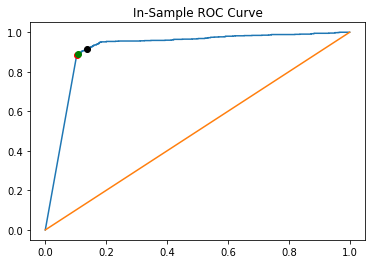

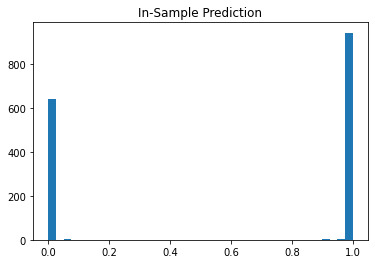

In [8]:
#######################################################
####
#### in-sample ROC curve to determine trading signal
####
#######################################################


y_score = model.predict(X_train.T).ravel()
fpr, tpr, threshold = roc_curve(y_train, y_score)

#### median, mean and optimal points on ROC curve
ind_med = np.argmin(np.abs(threshold-np.median(y_score)))
ind_mean = np.argmin(np.abs(threshold-np.mean(y_score)))
ind_opt = np.argmin(np.abs(tpr - (1-fpr) ))


plt.plot(fpr,tpr)
plt.plot(fpr,fpr);
plt.plot(fpr[ind_med],tpr[ind_med],'ro') 
plt.plot(fpr[ind_mean],tpr[ind_mean],'ko'); 
plt.plot(fpr[ind_opt],tpr[ind_opt],'go'); 
plt.title('In-Sample ROC Curve');
plt.show()

plt.hist(y_score,40);
plt.title('In-Sample Prediction');

Text(0.5, 1.0, 'Portfolio Value')

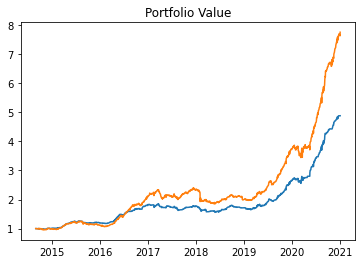

In [9]:
#######################################################
####
#### out-of-sample portfolio using trading signal
####
#######################################################

my_cutoff = threshold[ind_opt]   #### this is trading signal 

y_score = model.predict(X_test.T).ravel()
my_predict = (np.sign(y_score-my_cutoff)+1)/2

r_my_trade = my_predict*(r_trade[ind_test]) +(1-my_predict)*r*dt
p_my_trade = np.exp(np.cumsum(np.log(1+r_my_trade)))
p_trade = np.exp(np.cumsum(np.log(1+r_trade[ind_test])))

plt.plot(dates[ind_test],p_my_trade)
plt.plot(dates[ind_test],p_trade)
plt.title('Portfolio Value')

my return rate:  0.2493627277216411
(-1,2) return rate:  0.32212117951931796


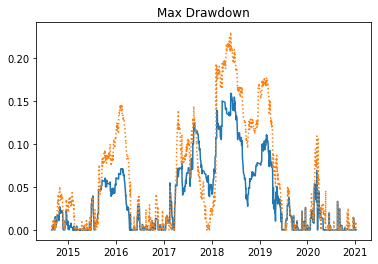

In [10]:
#######################################################
####
#### out-of-sample portfolio return rates and max drawdowns
####
#######################################################

print('my return rate: ',np.log(p_my_trade[-1])/(len(ind_test)*dt))
print('(-1,2) return rate: ',np.log(p_trade[-1])/(len(ind_test)*dt))

my_dd = (np.maximum.accumulate(p_my_trade)-p_my_trade)/np.maximum.accumulate(p_my_trade)
dd = (np.maximum.accumulate(p_trade)-p_trade)/np.maximum.accumulate(p_trade)
plt.plot(dates[ind_test],my_dd)
plt.plot(dates[ind_test],dd,':');
plt.title('Max Drawdown');

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 1000)              12000     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              1